In [1]:
### import data

### upload kaggle api token
from google.colab import files
files.upload()

### make kaggle directory
!mkdir ~/.kaggle

### change token's directory
!mv kaggle.json ~/.kaggle/

### change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

### download data
### for competitions
# !kaggle competitions download -c [COMPETITION]
###

### for dataset
!kaggle datasets download -d mdmahmudulhasansuzan/students-adaptability-level-in-online-education
###

### unzip data
!unzip /content/students-adaptability-level-in-online-education.zip

### delete token
!rm /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
  0% 0.00/6.43k [00:00<?, ?B/s]
100% 6.43k/6.43k [00:00<00:00, 6.25MB/s]
Archive:  /content/students-adaptability-level-in-online-education.zip
  inflating: students_adaptability_level_online_education.csv  


In [2]:
### install/upgrade libraries
!pip install category_encoders
!pip install xgboost --upgrade
!pip install eli5
!pip install pdpbox --upgrade
!pip install shap --upgrade
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 720 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.6 MB 55 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 6.6 MB/s 
     |████████████████████████████████| 133 kB 49.4 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=51f1defe8a0de6d8882ad7299092fd47b8eced2f4859c67e1ba134bafa897988
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Fou

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
### import libraries

### base libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### data preprocessing
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

### models and pipelines
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTEN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


### model evaluations
from sklearn.metrics import f1_score, classification_report, roc_curve, ConfusionMatrixDisplay, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

### model interpretation
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap


### ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv("/content/students_adaptability_level_online_education.csv")
data.head()

Gender    Age Education Level Institution Type IT Student Location  \
0    Boy  21-25      University   Non Government         No      Yes   
1   Girl  21-25      University   Non Government         No      Yes   
2   Girl  16-20         College       Government         No      Yes   
3   Girl  11-15          School   Non Government         No      Yes   
4   Girl  16-20          School   Non Government         No      Yes   

  Load-shedding Financial Condition Internet Type Network Type Class Duration  \
0           Low                 Mid          Wifi           4G            3-6   
1          High                 Mid   Mobile Data           4G            1-3   
2           Low                 Mid          Wifi           4G            1-3   
3           Low                 Mid   Mobile Data           4G            1-3   
4           Low                Poor   Mobile Data           3G              0   

  Self Lms  Device Adaptivity Level  
0       No     Tab         Moderate  
1      Yes  Mobile         Moderate  
2       No  Mobile         Moderate  
3       No  Mobile         Moderate  
4       No  Mobile              Low

In [3]:
target = "Adaptivity Level"

In [4]:
### EDA
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               1205 non-null   object
 1   Age                  1205 non-null   object
 2   Education Level      1205 non-null   object
 3   Institution Type     1205 non-null   object
 4   IT Student           1205 non-null   object
 5   Location             1205 non-null   object
 6   Load-shedding        1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Class Duration       1205 non-null   object
 11  Self Lms             1205 non-null   object
 12  Device               1205 non-null   object
 13  Adaptivity Level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


In [114]:
data[~data.duplicated()]

Gender    Age Education Level Institution Type IT Student Location  \
0       Boy  21-25      University   Non Government         No      Yes   
1      Girl  21-25      University   Non Government         No      Yes   
2      Girl  16-20         College       Government         No      Yes   
3      Girl  11-15          School   Non Government         No      Yes   
4      Girl  16-20          School   Non Government         No      Yes   
...     ...    ...             ...              ...        ...      ...   
1124    Boy  21-25      University   Non Government        Yes       No   
1132    Boy  16-20         College       Government         No      Yes   
1149   Girl  16-20         College   Non Government         No       No   
1160    Boy  21-25      University   Non Government        Yes       No   
1197    Boy  21-25      University   Non Government        Yes      Yes   

     Load-shedding Financial Condition Internet Type Network Type  \
0              Low                 Mid          Wifi           4G   
1             High                 Mid   Mobile Data           4G   
2              Low                 Mid          Wifi           4G   
3              Low                 Mid   Mobile Data           4G   
4              Low                Poor   Mobile Data           3G   
...            ...                 ...           ...          ...   
1124          High                 Mid   Mobile Data           3G   
1132           Low                 Mid   Mobile Data           3G   
1149           Low                 Mid   Mobile Data           3G   
1160          High                 Mid   Mobile Data           3G   
1197           Low                 Mid   Mobile Data           4G   

     Class Duration Self Lms    Device Adaptivity Level  
0               3-6       No       Tab         Moderate  
1               1-3      Yes    Mobile         Moderate  
2               1-3       No    Mobile         Moderate  
3               1-3       No    Mobile         Moderate  
4                 0       No    Mobile              Low  
...             ...      ...       ...              ...  
1124            3-6       No  Computer              Low  
1132            1-3       No    Mobile         Moderate  
1149            1-3      Yes    Mobile              Low  
1160            1-3      Yes    Mobile         Moderate  
1197            3-6       No  Computer         Moderate  

[256 rows x 14 columns]

In [5]:
data.describe()

Gender    Age Education Level Institution Type IT Student Location  \
count    1205   1205            1205             1205       1205     1205   
unique      2      6               3                2          2        2   
top       Boy  21-25          School   Non Government         No      Yes   
freq      663    374             530              823        901      935   

       Load-shedding Financial Condition Internet Type Network Type  \
count           1205                1205          1205         1205   
unique             2                   3             2            3   
top              Low                 Mid   Mobile Data           4G   
freq            1004                 878           695          775   

       Class Duration Self Lms  Device Adaptivity Level  
count            1205     1205    1205             1205  
unique              3        2       3                3  
top               1-3       No  Mobile         Moderate  
freq              840      995    1013              625

In [6]:
for i in data.columns:
    print(i, ":", data[i].unique().tolist())

Gender : ['Boy', 'Girl']
Age : ['21-25', '16-20', '11-15', '26-30', '6-10', '1-5']
Education Level : ['University', 'College', 'School']
Institution Type : ['Non Government', 'Government']
IT Student : ['No', 'Yes']
Location : ['Yes', 'No']
Load-shedding : ['Low', 'High']
Financial Condition : ['Mid', 'Poor', 'Rich']
Internet Type : ['Wifi', 'Mobile Data']
Network Type : ['4G', '3G', '2G']
Class Duration : ['3-6', '1-3', '0']
Self Lms : ['No', 'Yes']
Device : ['Tab', 'Mobile', 'Computer']
Adaptivity Level : ['Moderate', 'Low', 'High']


In [7]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.dpi"] = 200

In [8]:
order = {}
for key in data.columns:
    order[key] = data[key].unique().tolist()

for key, values in order.items():
    if "Yes" in values:
        order[key] = ["No", "Yes"]

order["Age"] = ["1-5", "6-10", "11-15", "16-20", "21-25", "26-30"]
order["Education Level"] = ["School", "College", "University"]
order["Financial Condition"] = ["Poor", "Mid", "Rich"]
order["Network Type"] = ["2G", "3G", "4G"]
order["Class Duration"] = ["0", "1-3", "3-6"]
order["Adaptivity Level"] = ['Low', 'Moderate', 'High']

In [9]:
order

{'Gender': ['Boy', 'Girl'],
 'Age': ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30'],
 'Education Level': ['School', 'College', 'University'],
 'Institution Type': ['Non Government', 'Government'],
 'IT Student': ['No', 'Yes'],
 'Location': ['No', 'Yes'],
 'Load-shedding': ['Low', 'High'],
 'Financial Condition': ['Poor', 'Mid', 'Rich'],
 'Internet Type': ['Wifi', 'Mobile Data'],
 'Network Type': ['2G', '3G', '4G'],
 'Class Duration': ['0', '1-3', '3-6'],
 'Self Lms': ['No', 'Yes'],
 'Device': ['Tab', 'Mobile', 'Computer'],
 'Adaptivity Level': ['Low', 'Moderate', 'High']}

In [10]:
for i in order:
    print(list(zip(range(len(order[i])), order[i])))

[(0, 'Boy'), (1, 'Girl')]
[(0, '1-5'), (1, '6-10'), (2, '11-15'), (3, '16-20'), (4, '21-25'), (5, '26-30')]
[(0, 'School'), (1, 'College'), (2, 'University')]
[(0, 'Non Government'), (1, 'Government')]
[(0, 'No'), (1, 'Yes')]
[(0, 'No'), (1, 'Yes')]
[(0, 'Low'), (1, 'High')]
[(0, 'Poor'), (1, 'Mid'), (2, 'Rich')]
[(0, 'Wifi'), (1, 'Mobile Data')]
[(0, '2G'), (1, '3G'), (2, '4G')]
[(0, '0'), (1, '1-3'), (2, '3-6')]
[(0, 'No'), (1, 'Yes')]
[(0, 'Tab'), (1, 'Mobile'), (2, 'Computer')]
[(0, 'Low'), (1, 'Moderate'), (2, 'High')]


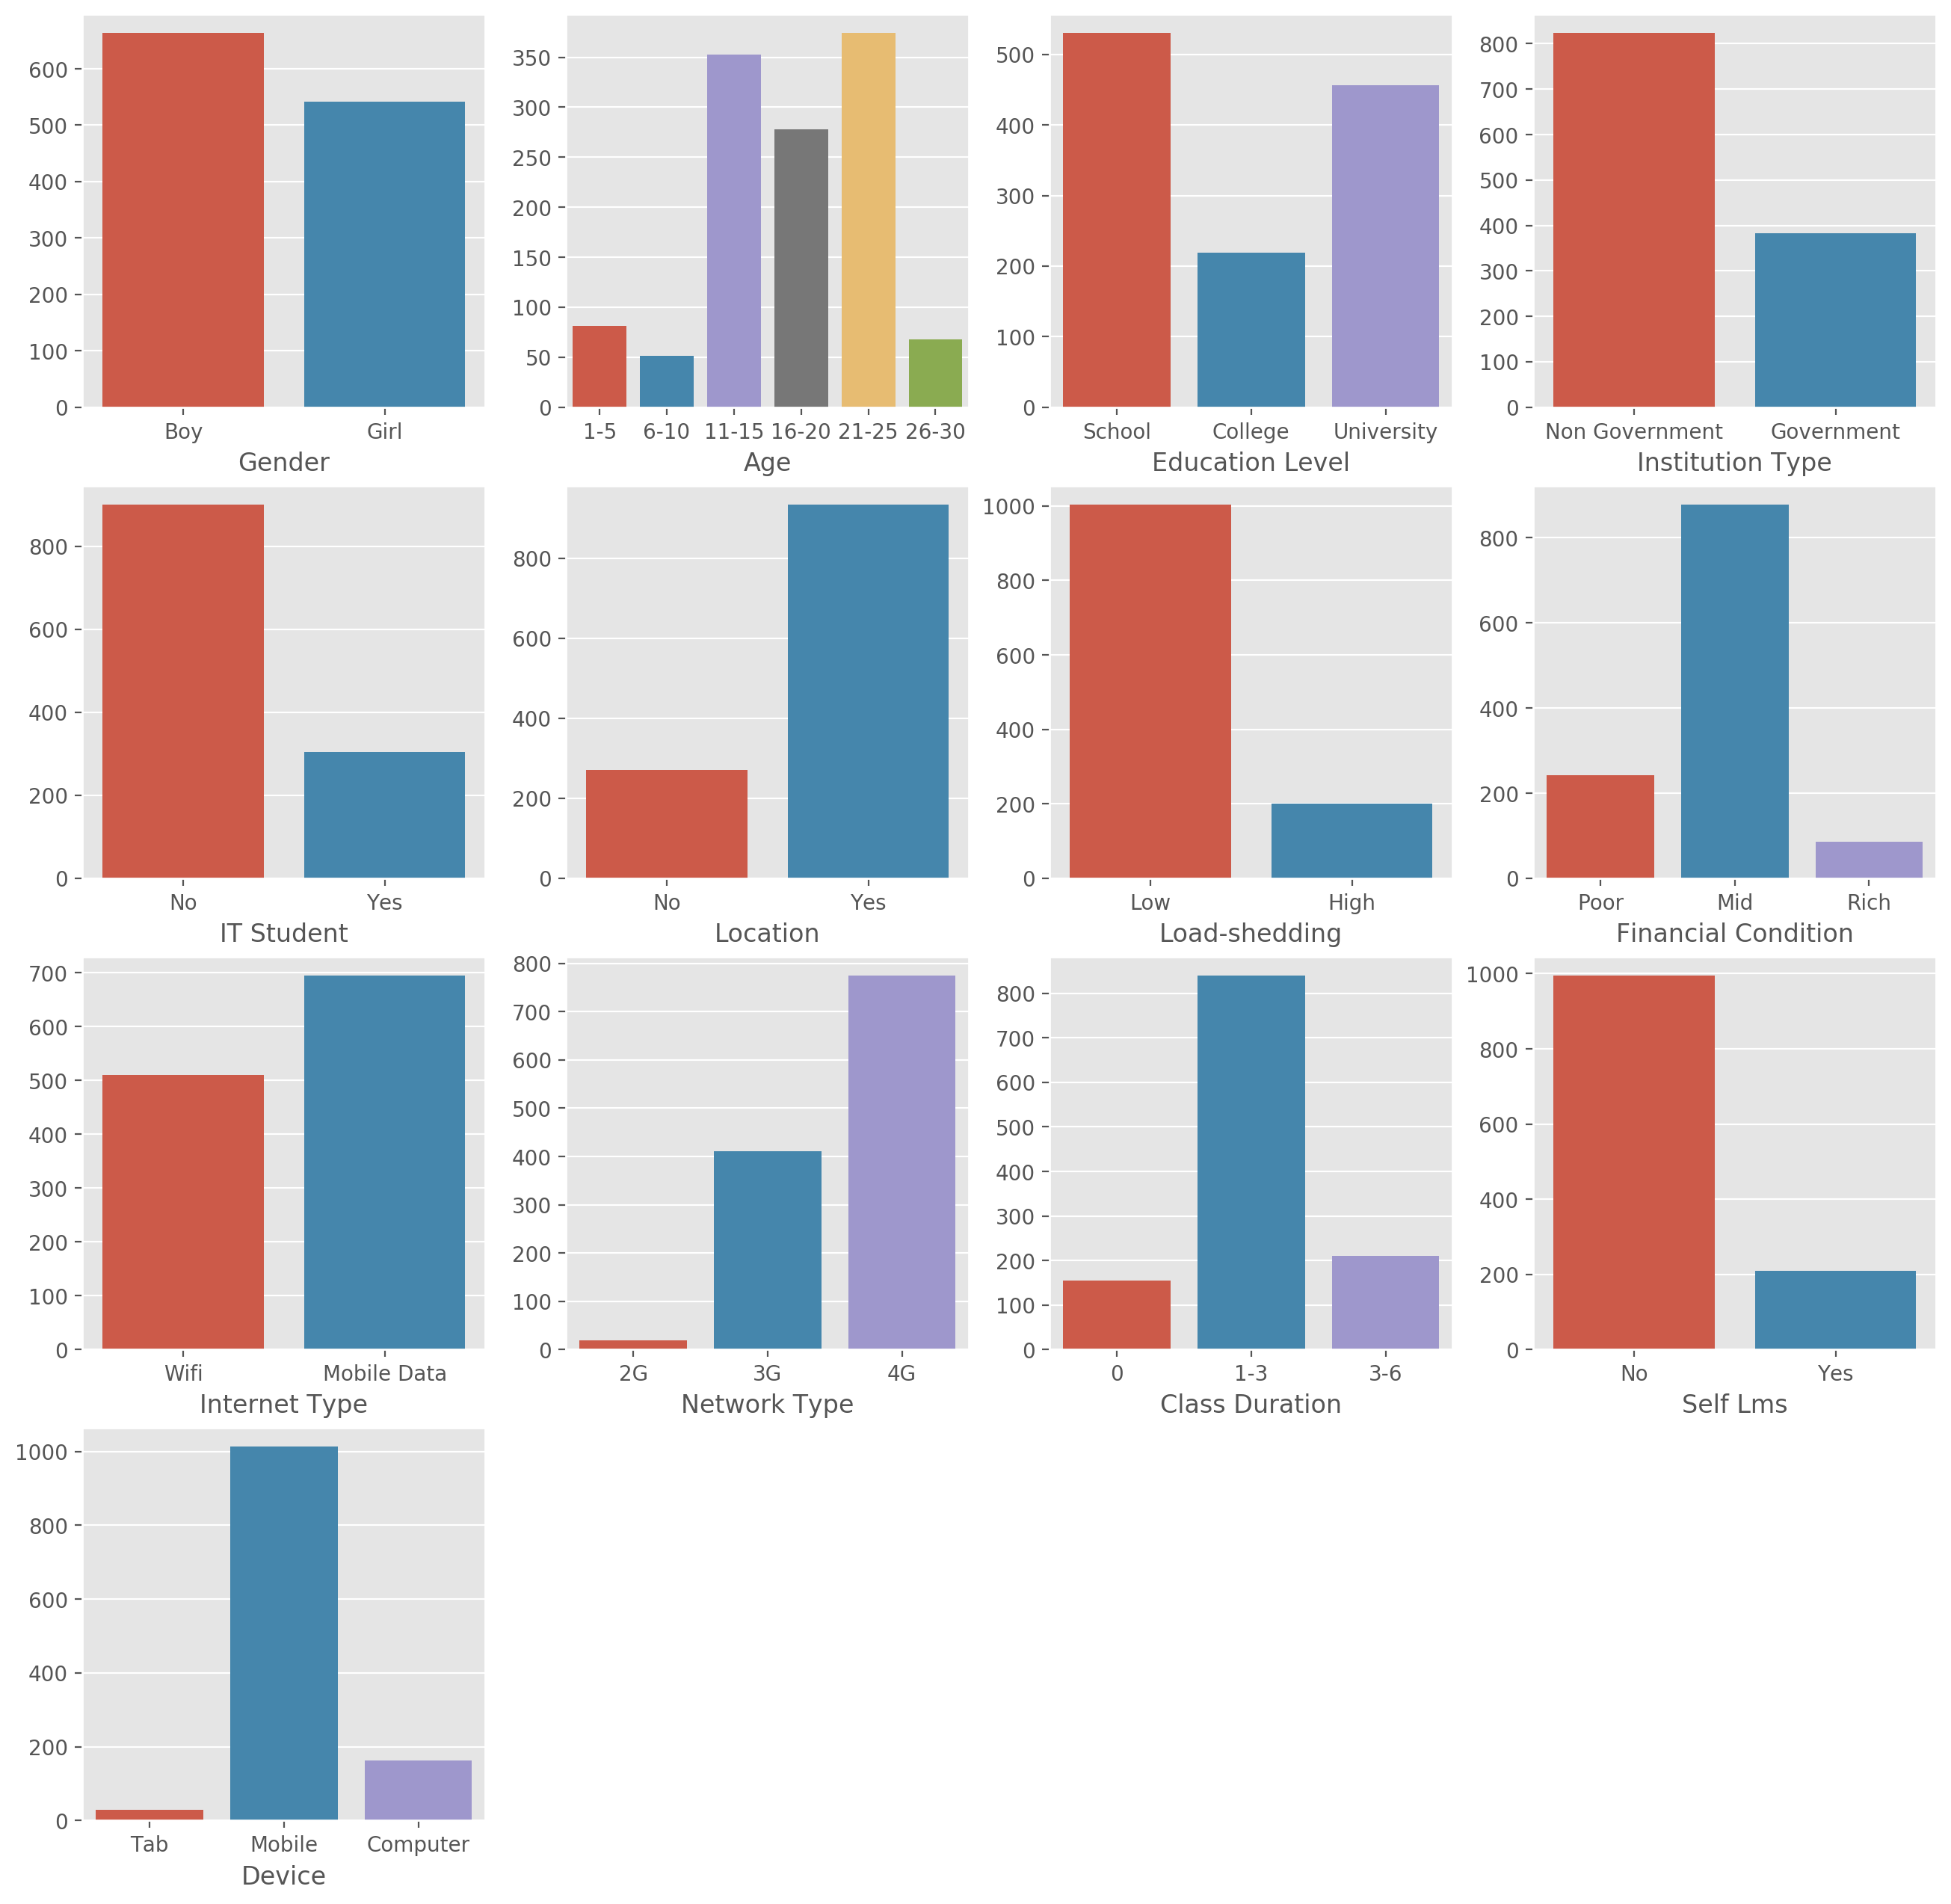

In [12]:
f = plt.figure(figsize = (16,16))
for idx, col in enumerate(data.columns[:-1]):
    ax = plt.subplot(4, 4, idx + 1)
    sns.countplot(data=data,
                  x=col,
                  order=order[col],
                  ax=ax
    )
    plt.ylabel(None)
plt.show;

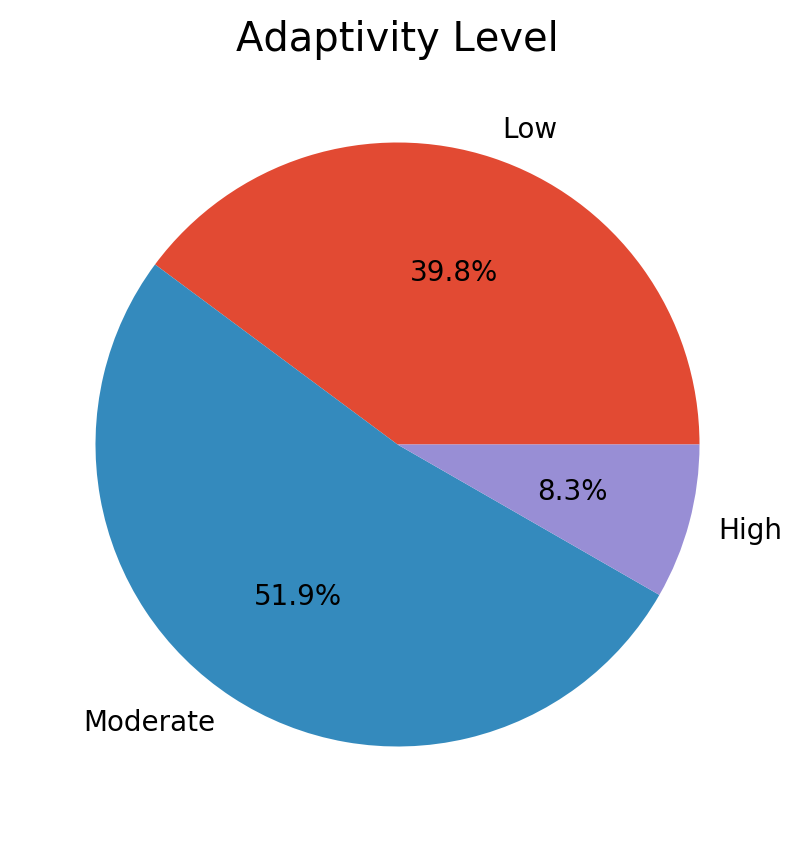

In [40]:
target_ratio = data["Adaptivity Level"].value_counts().reindex(["Low", "Moderate", "High"])
plt.title("Adaptivity Level", x=0.5)
plt.pie(target_ratio, labels=target_ratio.index, autopct="%.1f%%");

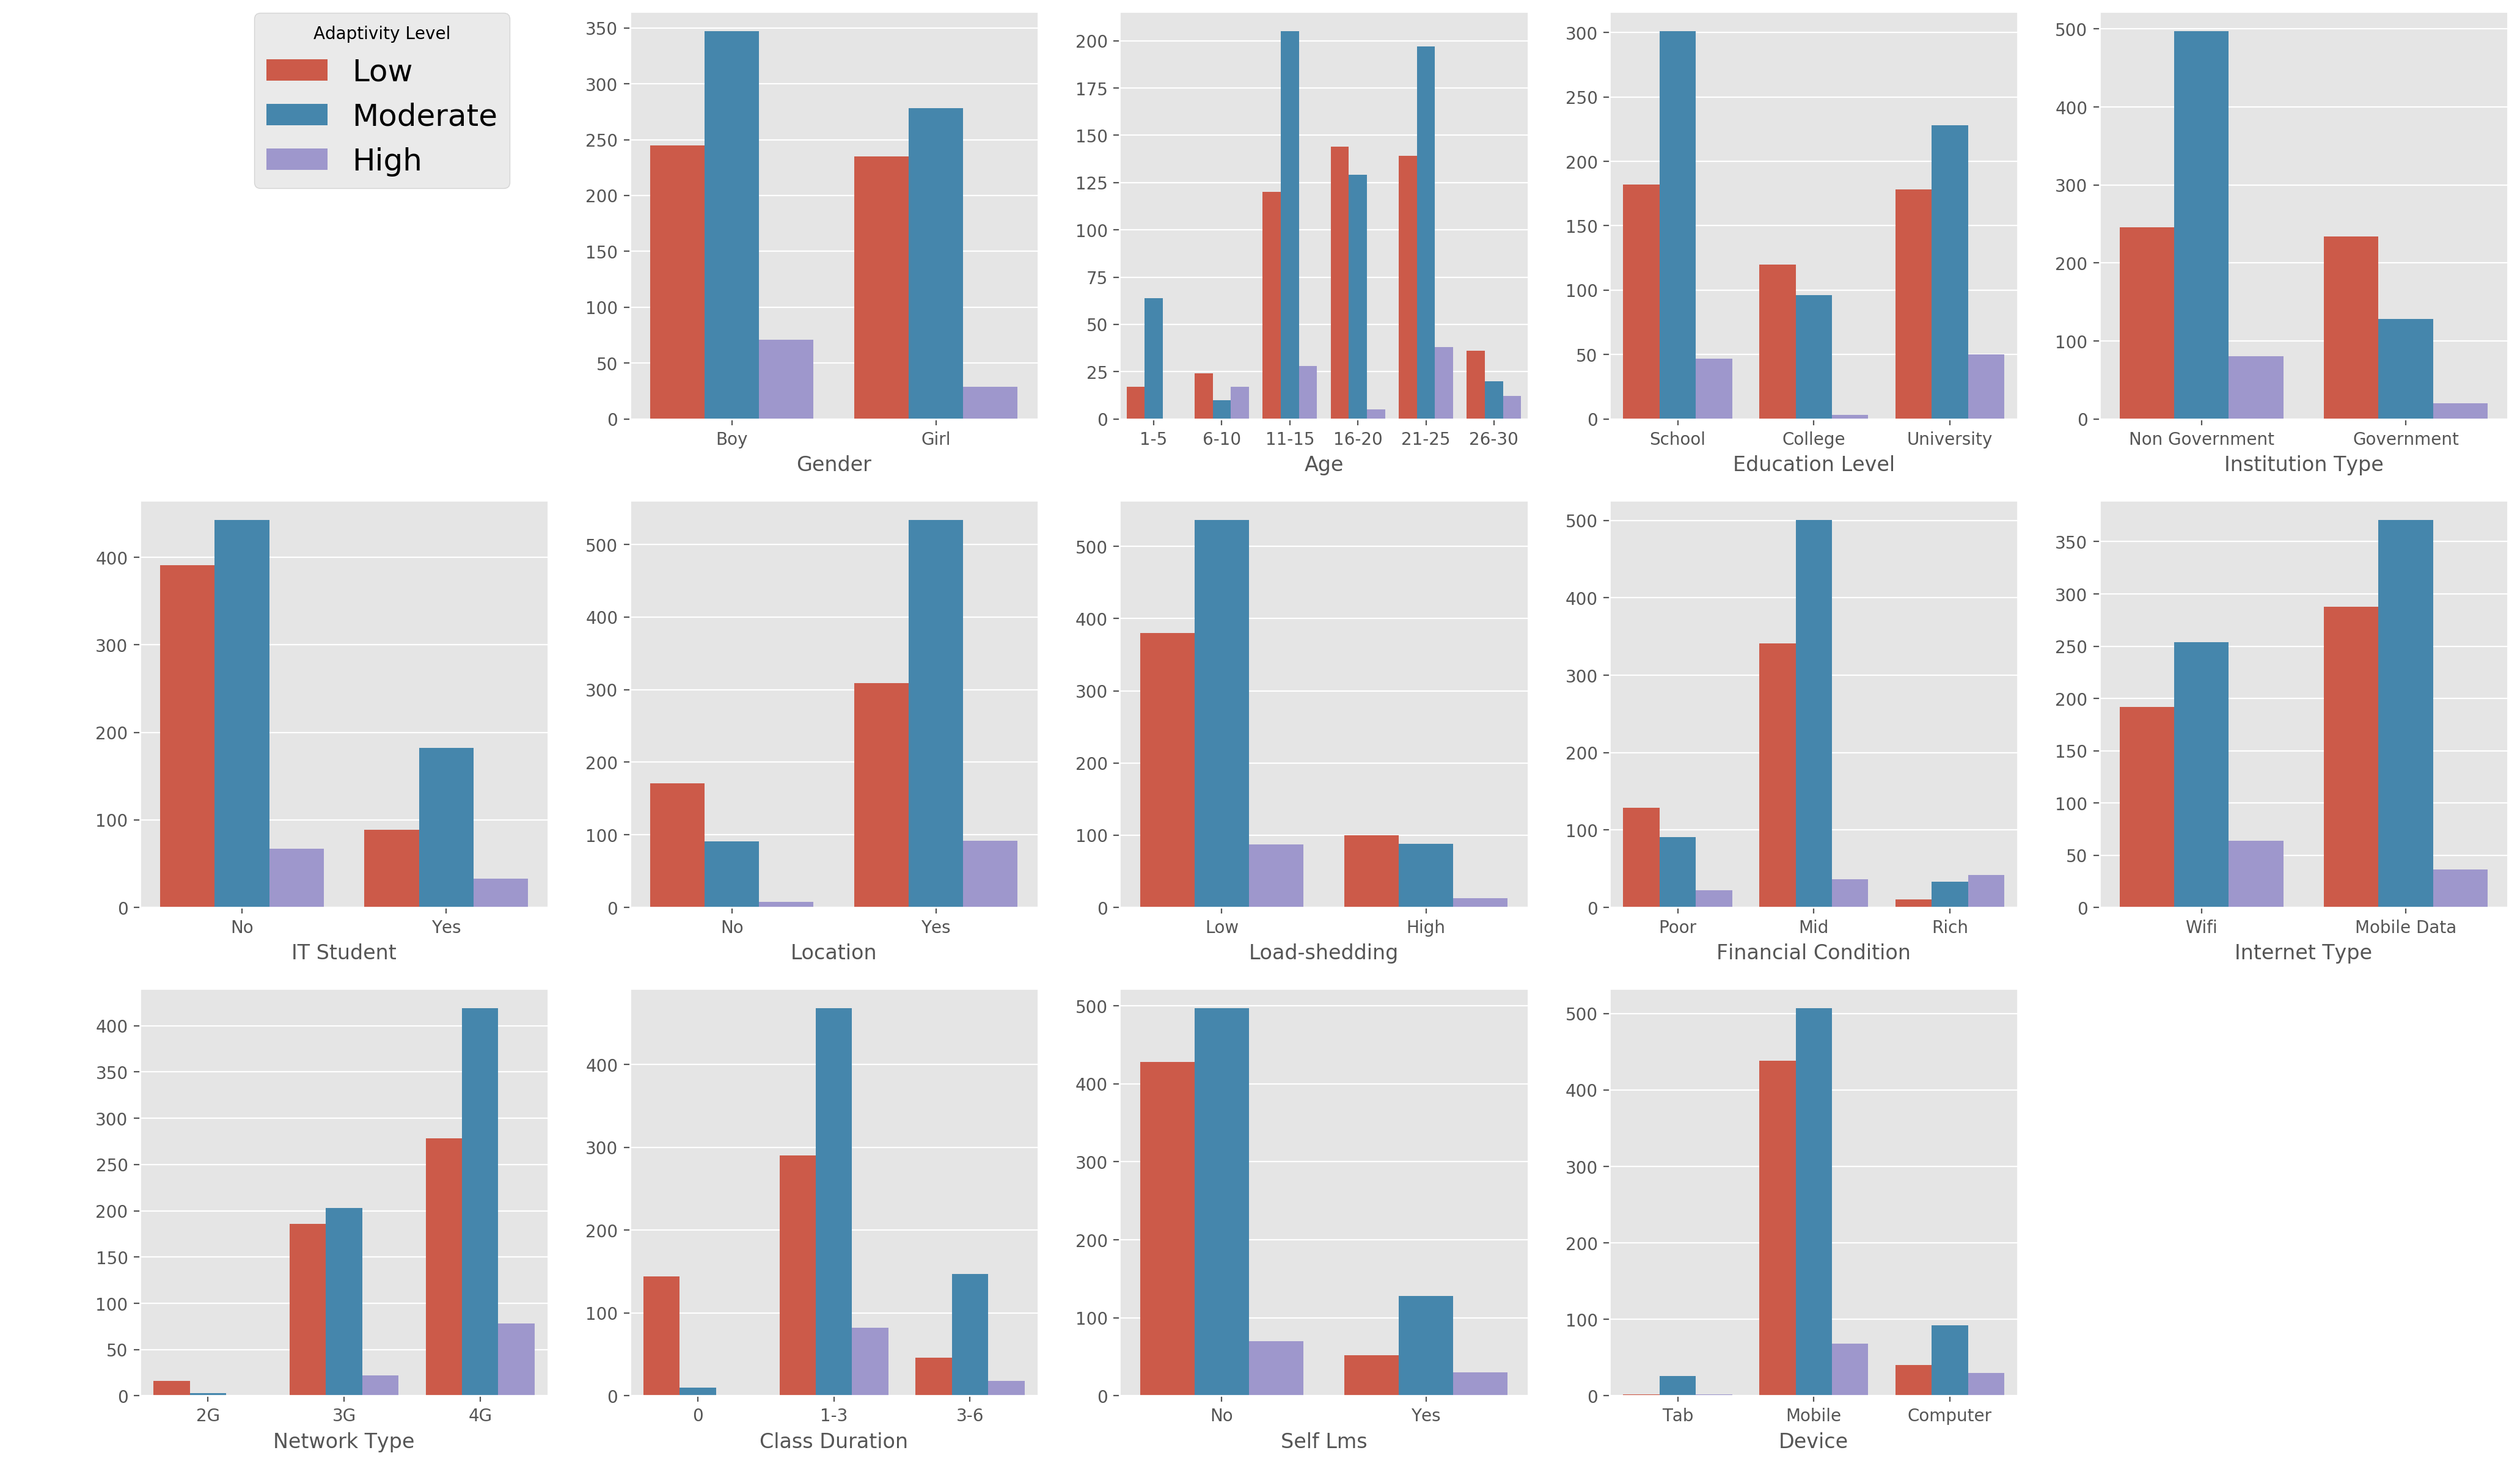

In [14]:
f = plt.figure(figsize = (25,15))
for idx, col in enumerate(data.columns[:-1]):
    ax = plt.subplot(3, 5, idx + 2)
    sns.countplot(data=data,
                  x=col,
                  hue=target,
                  hue_order=order[target],
                  order=order[col],
                  ax=ax
    )
    
    if not idx:
        handles, labels = ax.get_legend_handles_labels()
    
    ax.get_legend().remove()
    ax.set_ylabel("")
    

f.legend(handles=handles, labels=labels, loc="upper center", bbox_to_anchor=(0.125, 0.8), prop={'size': 18}, title="Adaptivity Level")
plt.show;

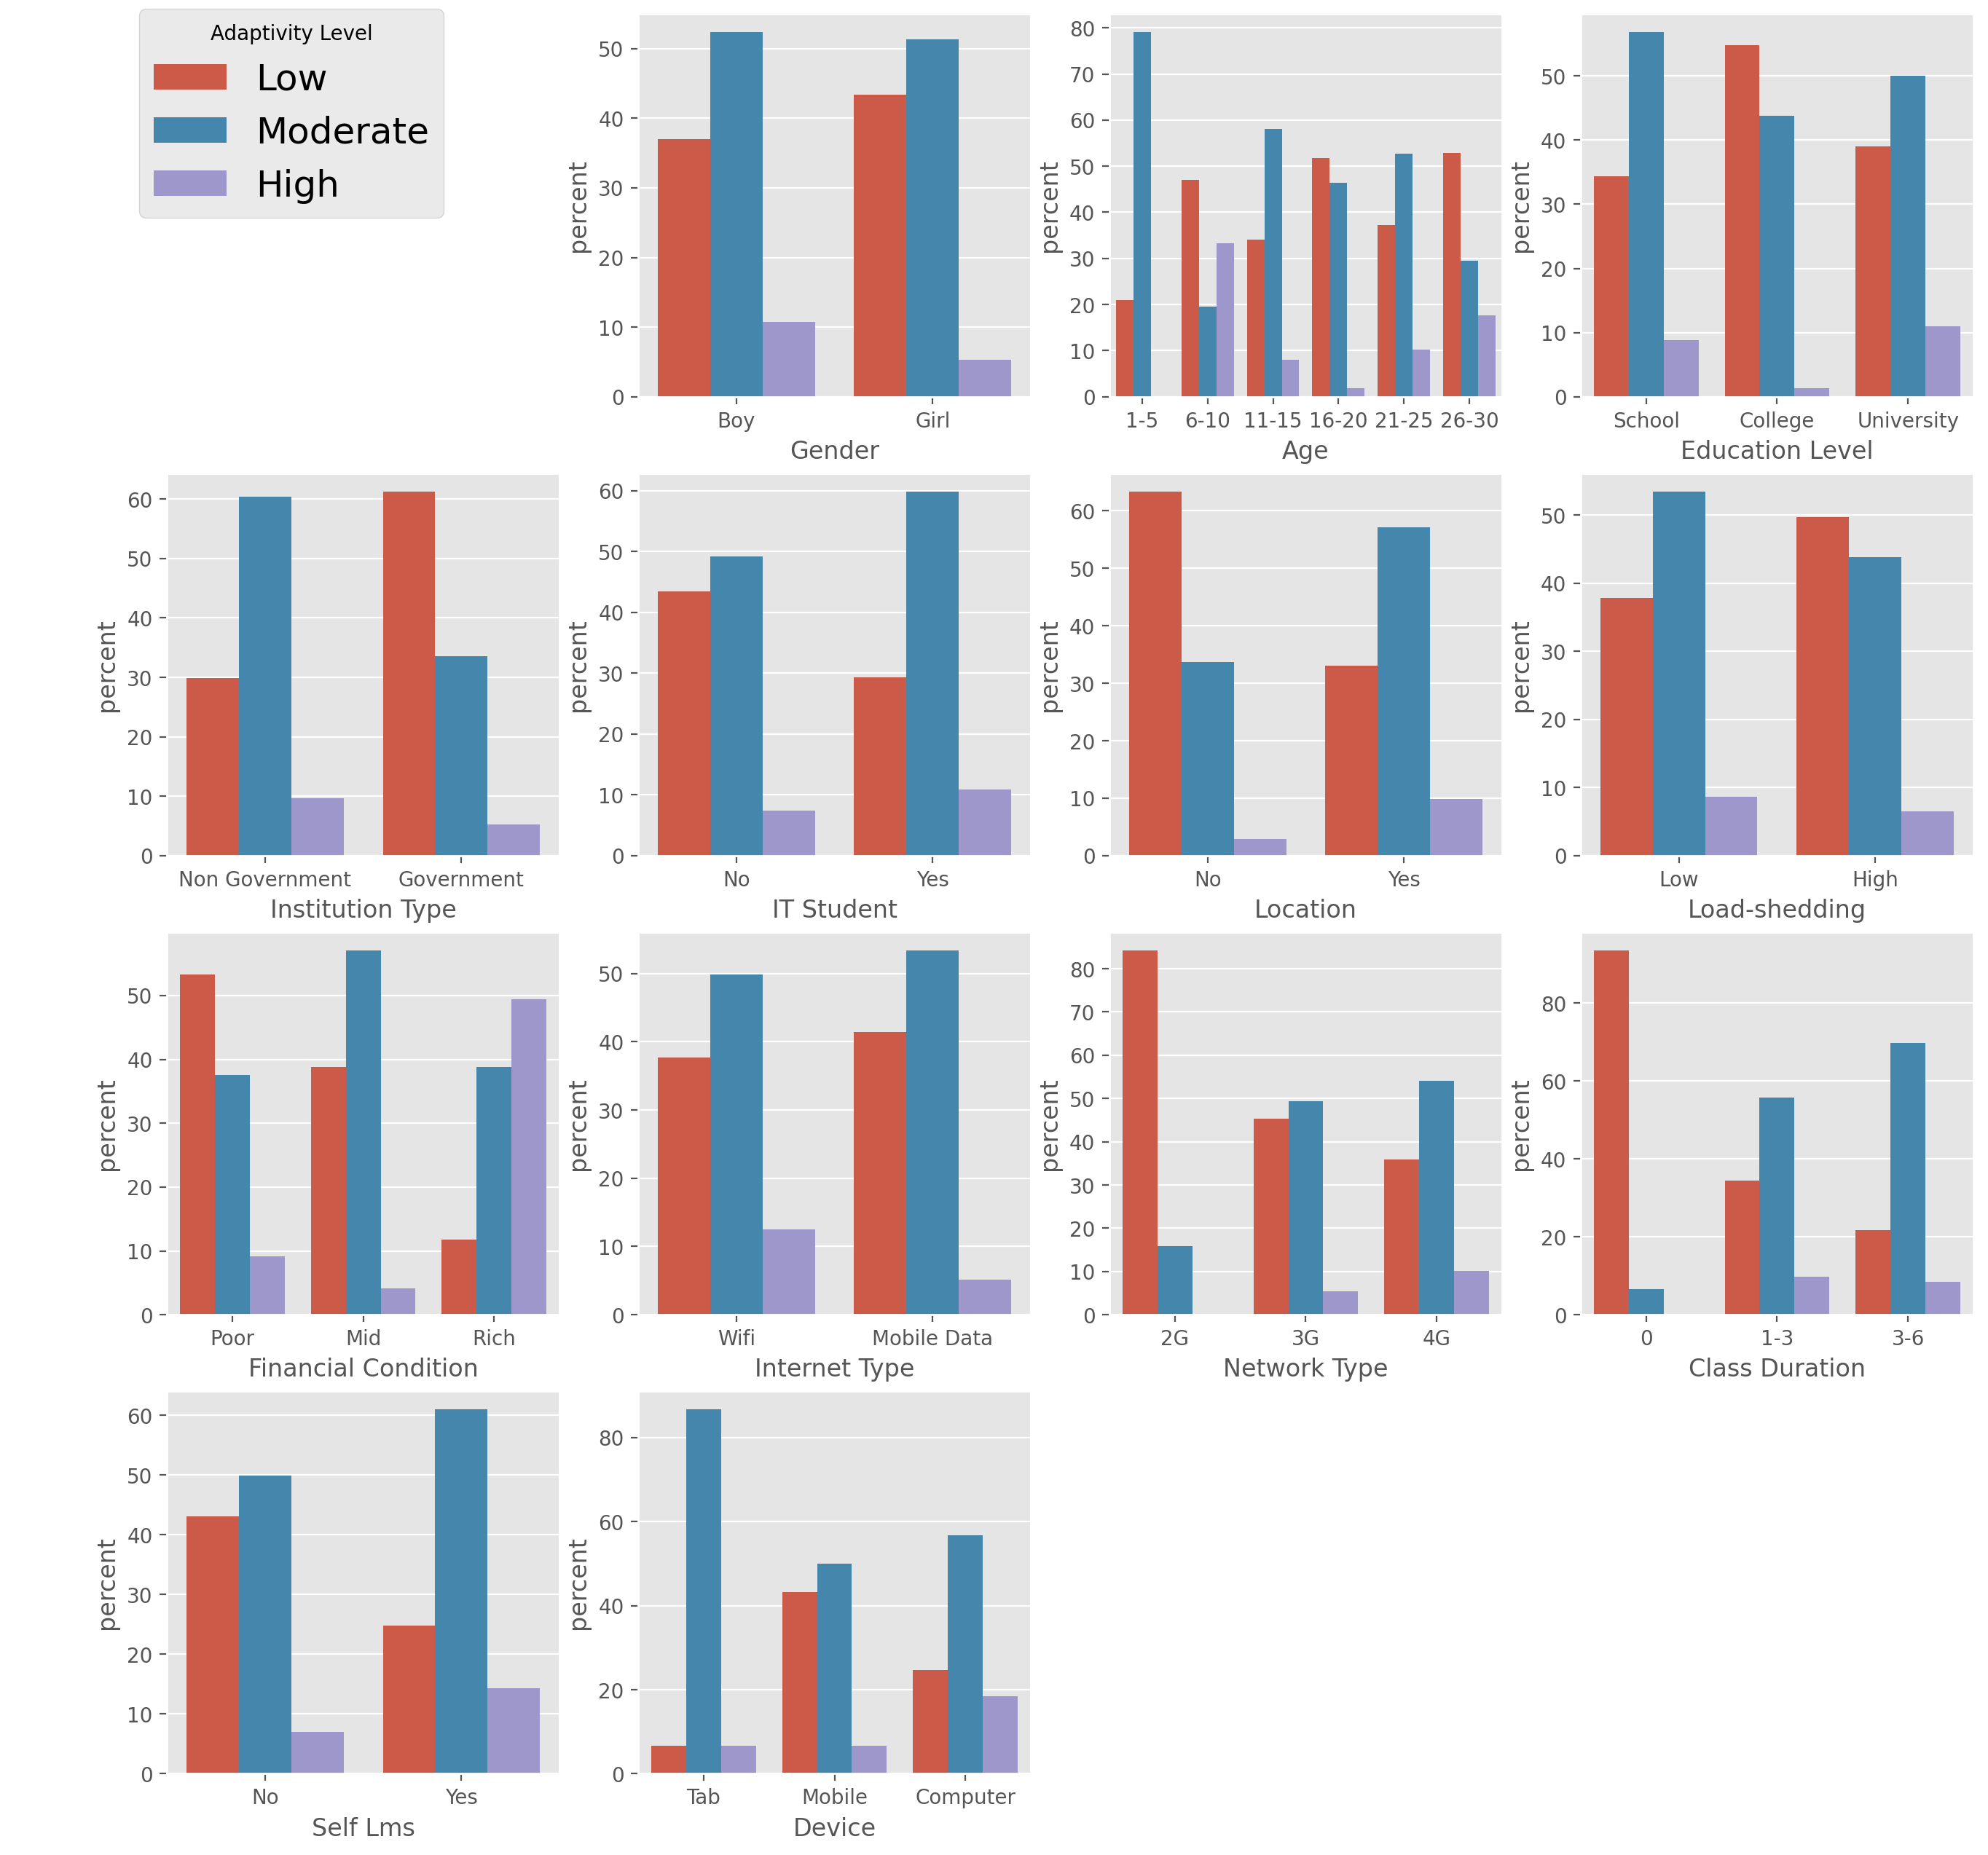

In [ ]:
f = plt.figure(figsize = (16,16))
for idx, col in enumerate(data.columns[:-1]):
    ax = plt.subplot(4, 4, idx + 2)
    x, y = col, target

    (data
    .groupby(x)[y]
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pipe((sns.barplot,'data'), x=x, y='percent', hue=y, hue_order=order[target], order=order[col], ax=ax))
    
    if not idx:
        handles, labels = ax.get_legend_handles_labels()
    
    ax.get_legend().remove()
    

f.legend(handles=handles, labels=labels, loc="upper center", bbox_to_anchor=(0.125, 0.8), prop={'size': 18}, title="Adaptivity Level")
plt.show;


In [17]:
### to use sklearn algorithm, type of features must be numerical, so use Ordinal Encoder
mapping = []
for key, values in order.items():
    tmp_dict = dict()
    tmp_dict["col"] = key
    tmp_dict_mapping = dict()
    for idx, cat in enumerate(values):
        tmp_dict_mapping[cat] = idx

    tmp_dict["mapping"] = tmp_dict_mapping
    mapping.append(tmp_dict)
ord = OrdinalEncoder(mapping=mapping)
data_encoded = ord.fit_transform(data)

In [18]:
mapping

[{'col': 'Gender', 'mapping': {'Boy': 0, 'Girl': 1}},
 {'col': 'Age',
  'mapping': {'1-5': 0,
   '6-10': 1,
   '11-15': 2,
   '16-20': 3,
   '21-25': 4,
   '26-30': 5}},
 {'col': 'Education Level',
  'mapping': {'School': 0, 'College': 1, 'University': 2}},
 {'col': 'Institution Type',
  'mapping': {'Non Government': 0, 'Government': 1}},
 {'col': 'IT Student', 'mapping': {'No': 0, 'Yes': 1}},
 {'col': 'Location', 'mapping': {'No': 0, 'Yes': 1}},
 {'col': 'Load-shedding', 'mapping': {'Low': 0, 'High': 1}},
 {'col': 'Financial Condition', 'mapping': {'Poor': 0, 'Mid': 1, 'Rich': 2}},
 {'col': 'Internet Type', 'mapping': {'Wifi': 0, 'Mobile Data': 1}},
 {'col': 'Network Type', 'mapping': {'2G': 0, '3G': 1, '4G': 2}},
 {'col': 'Class Duration', 'mapping': {'0': 0, '1-3': 1, '3-6': 2}},
 {'col': 'Self Lms', 'mapping': {'No': 0, 'Yes': 1}},
 {'col': 'Device', 'mapping': {'Tab': 0, 'Mobile': 1, 'Computer': 2}},
 {'col': 'Adaptivity Level', 'mapping': {'Low': 0, 'Moderate': 1, 'High': 2}}]

In [19]:
data_encoded.describe()

Gender          Age  Education Level  Institution Type  \
count  1205.000000  1205.000000      1205.000000       1205.000000   
mean      0.449793     2.843983         0.938589          0.317012   
std       0.497679     1.257096         0.902863          0.465506   
min       0.000000     0.000000         0.000000          0.000000   
25%       0.000000     2.000000         0.000000          0.000000   
50%       0.000000     3.000000         1.000000          0.000000   
75%       1.000000     4.000000         2.000000          1.000000   
max       1.000000     5.000000         2.000000          1.000000   

        IT Student     Location  Load-shedding  Financial Condition  \
count  1205.000000  1205.000000    1205.000000          1205.000000   
mean      0.252282     0.775934       0.166805             0.869710   
std       0.434503     0.417139       0.372956             0.504584   
min       0.000000     0.000000       0.000000             0.000000   
25%       0.000000     1.000000       0.000000             1.000000   
50%       0.000000     1.000000       0.000000             1.000000   
75%       1.000000     1.000000       0.000000             1.000000   
max       1.000000     1.000000       1.000000             2.000000   

       Internet Type  Network Type  Class Duration     Self Lms       Device  \
count    1205.000000   1205.000000     1205.000000  1205.000000  1205.000000   
mean        0.576763      1.627386        1.047303     0.174274     1.109544   
std         0.494277      0.515295        0.548559     0.379502     0.384003   
min         0.000000      0.000000        0.000000     0.000000     0.000000   
25%         0.000000      1.000000        1.000000     0.000000     1.000000   
50%         1.000000      2.000000        1.000000     0.000000     1.000000   
75%         1.000000      2.000000        1.000000     0.000000     1.000000   
max         1.000000      2.000000        2.000000     1.000000     2.000000   

       Adaptivity Level  
count       1205.000000  
mean           0.684647  
std            0.618221  
min            0.000000  
25%            0.000000  
50%            1.000000  
75%            1.000000  
max            2.000000

In [37]:
from scipy.stats import chi2_contingency, ttest_ind
dist = pd.crosstab(data_encoded["Adaptivity Level"], data_encoded["Financial Condition"])
p = chi2_contingency(dist)[1]
print(p)

4.391228197442381e-50


In [33]:
dist = pd.crosstab(data_encoded["Adaptivity Level"], data_encoded["Self Lms"])
ttest_ind(dist[0], dist[1])

Ttest_indResult(statistic=1.9292711033280023, pvalue=0.12592091684481752)

In [34]:
ttest_ind(dist[0], dist[1], alternative="greater")

Ttest_indResult(statistic=1.9292711033280023, pvalue=0.06296045842240876)

In [35]:
dist = pd.crosstab(data_encoded["Adaptivity Level"], data_encoded["Institution Type"])
ttest_ind(dist[0], dist[1], alternative="greater")

Ttest_indResult(statistic=1.0805351346651062, pvalue=0.1703506734096329)

In [20]:
### seperate target and feature variables
def seperate_target(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    return X, y


X, y = seperate_target(data_encoded, target)

In [47]:
### split data to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=141592)

In [48]:
type(None)

NoneType

In [ ]:
a = pd.Series([3,5], index=[0,1])
b = pd.Series([3,5], index=[1,0])
a + b

0    8
1    8
dtype: int64

In [ ]:
### brief prediction by LazyClassifier
from lazypredict.Supervised import LazyClassifier
lazy_X, lazy_y = X_train.copy().reset_index(drop=True), y_train.copy().reset_index(drop=True)
skf = StratifiedKFold()
pred = None
for train_index, val_index in skf.split(lazy_X, lazy_y):
    lazy_X_train, lazy_X_val = lazy_X.loc[train_index], lazy_X.loc[val_index]
    lazy_y_train, lazy_y_val = lazy_y.loc[train_index], lazy_y.loc[val_index]
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(lazy_X_train, lazy_X_val, lazy_y_train, lazy_y_val)
    if type(pred) == type(None):
        pred = models.copy()
    else:
        for i in pred.columns:
            pred[i] += models[i]
for i in pred.columns:
    pred[i] /= 5
pred.sort_values(by="F1 Score", ascending=False)

100%|██████████| 29/29 [00:01<00:00, 17.18it/s]


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier         0.885913           0.824508     NaN  0.884515   
ExtraTreesClassifier           0.885908           0.814196     NaN  0.883847   
XGBClassifier                  0.883835           0.805465     NaN  0.881447   
DecisionTreeClassifier         0.882804           0.812606     NaN  0.880933   
LabelPropagation               0.881768           0.811541     NaN  0.880257   
LabelSpreading                 0.881768           0.811541     NaN  0.880257   
ExtraTreeClassifier            0.880737           0.807772     NaN  0.878791   
BaggingClassifier              0.874498           0.806243     NaN  0.872833   
LGBMClassifier                 0.855845           0.786469     NaN  0.853762   
SVC                            0.792563           0.685490     NaN  0.786304   
KNeighborsClassifier           0.790479           0.689051     NaN  0.785331   
QuadraticDiscriminantAnalysis  0.762468           0.728935     NaN  0.762966   
AdaBoostClassifier             0.683636           0.576685     NaN  0.675234   
LogisticRegression             0.693998           0.527022     NaN  0.672793   
SGDClassifier                  0.671206           0.517272     NaN  0.656286   
LinearDiscriminantAnalysis     0.678443           0.513239     NaN  0.655466   
GaussianNB                     0.654555           0.579486     NaN  0.653644   
CalibratedClassifierCV         0.675329           0.485031     NaN  0.643282   
LinearSVC                      0.674293           0.481263     NaN  0.641846   
RidgeClassifier                0.670148           0.477600     NaN  0.636633   
RidgeClassifierCV              0.670148           0.477600     NaN  0.636633   
PassiveAggressiveClassifier    0.643210           0.479895     NaN  0.625476   
BernoulliNB                    0.639022           0.490877     NaN  0.617100   
NearestCentroid                0.551905           0.550684     NaN  0.585463   
Perceptron                     0.597544           0.462548     NaN  0.584810   
DummyClassifier                0.518674           0.333333     NaN  0.354287   

                               Time Taken  
Model                                      
RandomForestClassifier           0.156245  
ExtraTreesClassifier             0.131060  
XGBClassifier                    0.178576  
DecisionTreeClassifier           0.009158  
LabelPropagation                 0.044443  
LabelSpreading                   0.060072  
ExtraTreeClassifier              0.008274  
BaggingClassifier                0.030252  
LGBMClassifier                   0.136605  
SVC                              0.066989  
KNeighborsClassifier             0.016070  
QuadraticDiscriminantAnalysis    0.008574  
AdaBoostClassifier               0.090870  
LogisticRegression               0.022506  
SGDClassifier                    0.045399  
LinearDiscriminantAnalysis       0.019624  
GaussianNB                       0.010492  
CalibratedClassifierCV           0.407613  
LinearSVC                        0.154713  
RidgeClassifier                  0.011479  
RidgeClassifierCV                0.018903  
PassiveAggressiveClassifier      0.010975  
BernoulliNB                      0.010459  
NearestCentroid                  0.009486  
Perceptron                       0.010398  
DummyClassifier                  0.007806

In [ ]:
### lazy predict changes pandas display option
pd.reset_option("all")

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [49]:
### use 3 eval metrics, which are accuracy, f1 score macro average(for multiclass), and auc score macro average by one vs rest(for multiclass)
multiscorer = {
    "accuracy":"accuracy",
    "f1_macro":"f1_macro",
    "roc_auc_ovr":"roc_auc_ovr"
}


### make base model, note that stratified and uniform are not deterministic(although f1 of stratified and accuracy of uniform will converge to 1/(# of classes))
for s in ["most_frequent", "prior", "stratified", "uniform"]:
    base = DummyClassifier(strategy=s)
    score = cross_validate(estimator=base,
                           X=X_train,
                           y=y_train,
                           cv=5,
                           scoring=multiscorer)
    print("Model : ", "base_", s, sep="")
    for i in score:
        if "test" in i:
            print(i[5:], ":", np.mean(score[i]))

Model : base_most_frequent
accuracy : 0.518674438687392
f1_macro : 0.2276871288980317
roc_auc_ovr : 0.5
Model : base_prior
accuracy : 0.518674438687392
f1_macro : 0.2276871288980317
roc_auc_ovr : 0.5
Model : base_stratified
accuracy : 0.42014248704663204
f1_macro : 0.3275380132538658
roc_auc_ovr : 0.5130895442696517
Model : base_uniform
accuracy : 0.32259283246977544
f1_macro : 0.2886613692855401
roc_auc_ovr : 0.5


In [ ]:
### f1 of stratified and accuracy of uniform will converge to 1/(# of classes)
s_a, s_f, u_a, u_f = [], [], [], []
for i in range(10000):
    base = DummyClassifier(strategy="stratified")
    score = cross_validate(estimator=base,
                           X=X_train,
                           y=y_train,
                           cv=5,
                           scoring=multiscorer)
    s_a.append(np.mean(score["test_accuracy"]))
    s_f.append(np.mean(score["test_f1_macro"]))
    base = DummyClassifier(strategy="uniform")
    score = cross_validate(estimator=base,
                           X=X_train,
                           y=y_train,
                           cv=5,
                           scoring=multiscorer)
    u_a.append(np.mean(score["test_accuracy"]))
    u_f.append(np.mean(score["test_f1_macro"]))

print(np.mean(s_a),np.mean(s_f),np.mean(u_a),np.mean(u_f))

0.43462459790587216 0.33257527269713266 0.33318747733160625 0.29967015431694244


In [66]:
### base model : mode
base = DummyClassifier(strategy="most_frequent")
score = cross_validate(estimator=base,
                       X=X_train,
                       y=y_train,
                       cv=5,
                       scoring=multiscorer)
scores = ["base_most_frequent", np.mean(score["test_accuracy"]), np.mean(score["test_f1_macro"]), np.mean(score["test_roc_auc_ovr"])]
scores = pd.DataFrame(data=np.array(scores), index = ["model", "accuracy", "f1_macro", "roc_auc_ovr"]).T
for i in scores.columns[1:]:
    scores[i] = scores[i].astype(float)

In [65]:
scores

model  accuracy  f1_macro  roc_auc_ovr
0  base_most_frequent  0.518674  0.227687          0.5

In [ ]:
### make ternary classification models by Logistic Regression, Decision Tree Classifier, Random Forest Classifier, and XGBoost Classifier
estimators = ["logreg", "dt", "rf", "xgb"]


### since it is classificaition on imbalanced data, we can use oversampling and weighted class
balancing_methods = ["none", "os_rand", "os_smoten", "wc"]


### make pipelines for each model
pipelines = dict()
from itertools import product
for estimator, balancing in product(estimators, balancing_methods):
    if estimator == "logreg":
        pipeline = Pipeline([(estimator, LogisticRegression(
            multi_class="ovr",
            n_jobs=-1
        ))])
    elif estimator == "dt":
        pipeline = Pipeline([(estimator, DecisionTreeClassifier())])
    elif estimator == "rf":
        pipeline = Pipeline([(estimator, RandomForestClassifier(
            n_estimators=1000,
            n_jobs=-1
        ))])
    elif estimator == "xgb":
        pipeline = Pipeline([(estimator, XGBClassifier(
            n_estimators=500,
            tree_method="gpu_hist",
        ))])
    
    if balancing == "os_rand":
        pipeline.steps.insert(0, (balancing, RandomOverSampler()))
    elif balancing == "os_smoten":
        pipeline.steps.insert(0, (balancing, SMOTEN()))
    elif (estimator != "xgb") and (balancing == "wc"):
        pipeline[-1].set_params(class_weight="balanced")
    pipelines[estimator+"_"+balancing] = pipeline

sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

In [ ]:
### base model and not tuned models
scores = scores.drop(scores.index[1:])
pipelines_base = dict()
for key in pipelines:
    pipelines_base[key] = clone(pipelines[key])
    model_score = [key]
    acc = []
    f1 = []
    auc = []
    for _ in range(10):
        if key == "xgb_wc":
            score = cross_validate(estimator=pipelines_base[key],
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring=multiscorer,
                                fit_params={"xgb__sample_weight":sample_weight})
        else:
            score = cross_validate(estimator=pipelines_base[key],
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring=multiscorer)
        for i in score:
            if i == "test_accuracy":
                acc.append(np.mean(score[i]))
            if i == "test_f1_macro":
                f1.append(np.mean(score[i]))
            if i == "test_roc_auc_ovr":
                auc.append(np.mean(score[i]))
    model_score.append(np.mean(acc))
    model_score.append(np.mean(f1))
    model_score.append(np.mean(auc))
    scores.loc[len(scores)] = model_score
scores

model  accuracy  f1_macro  roc_auc_ovr
0   base_most_frequent  0.518674  0.227687     0.500000
1          logreg_none  0.683614  0.478376     0.776295
2       logreg_os_rand  0.589948  0.537895     0.766110
3     logreg_os_smoten  0.611645  0.548336     0.758593
4            logreg_wc  0.634888  0.560417     0.772439
5              dt_none  0.885602  0.833619     0.939903
6           dt_os_rand  0.864531  0.819522     0.935882
7         dt_os_smoten  0.858015  0.800900     0.934950
8                dt_wc  0.857264  0.812794     0.930459
9              rf_none  0.885184  0.837904     0.962287
10          rf_os_rand  0.867539  0.825794     0.959991
11        rf_os_smoten  0.862676  0.811282     0.955622
12               rf_wc  0.864631  0.817761     0.958731
13            xgb_none  0.889022  0.837110     0.948468
14         xgb_os_rand  0.865253  0.819050     0.947434
15       xgb_os_smoten  0.862880  0.806072     0.947374
16              xgb_wc  0.865150  0.820415     0.949523

In [ ]:
### draw colors at maximum
def draw_color_at_maxmum(x,color):
    color = f'border:{color}'
    _max = x.max()
    is_max = x == _max
    return [color if b else '' for b in is_max]


scores.style.apply(draw_color_at_maxmum,color='2px solid yellow',subset=scores.columns[1:],axis=0)

In [ ]:
### hyperparameter tuning
n = len(X_train.columns)
min_sampling_features = min(0.25, np.sqrt(n)/n, np.log2(n)/n)
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]
param_logreg = {
    "logreg__C":hp.choice("C", np.logspace(-5, 4, 10))
}
param_dt = {
    "dt__max_depth":hp.quniform("max_depth", 2, 50, 2),
    "dt__max_features":hp.uniform("max_features", min_sampling_features, 1),
    "dt__min_samples_leaf":hp.quniform("min_samples_leaf", 1, 16, 1),
}
param_rf = {
    "rf__max_depth":hp.quniform("max_depth", 2, 20, 2),
    "rf__max_features":hp.uniform("max_features", min_sampling_features, 1),
    "rf__min_samples_leaf":hp.quniform("min_samples_leaf", 1, 16, 1),
}
param_xgb = {
    "xgb__n_estimators":hp.quniform("n_estimators", 100, 1100, 100),
    "xgb__max_depth":hp.quniform("max_depth", 4, 22, 2),
    "xgb__colsample_bytree":hp.uniform("colsample_bytree", min_sampling_features, 0.8),
    "xgb__min_child_weight":hp.quniform("min_child_weight", 1, 16, 1),
    "xgb__learning_rate":hp.uniform("learning_rate", 0.001, 0.5),
    "xgb__reg_lambda":hp.choice('reg_lambda', reg_candidate),
}

In [ ]:
### since hyperopt loss function needs only one value, use f1 score(macro) as eval metric
trials = dict()
best_params = dict()
for key, values in pipelines.items():
    def myloss(params):
        pipe = values
        for i in params:
            if "max_depth" in i or "n_estimators" in i or "min" in i:
                params[i] = int(params[i])
        pipe.set_params(**params)
        if key == "xgb_wc":
            score = cross_val_score(estimator=pipe,
                                    X=X_train,
                                    y=y_train,
                                    cv=5,
                                    scoring="f1_macro",
                                    fit_params={"xgb__sample_weight":sample_weight})
        else:
            score = cross_val_score(estimator=pipe,
                                    X=X_train,
                                    y=y_train,
                                    cv=5,
                                    scoring="f1_macro")
        avg_cv_score = -np.mean(score)
        return {"loss": avg_cv_score, "status": STATUS_OK}
    

    if "dt" in key:
        space = param_dt
    elif "rf" in key:
        space = param_rf
    elif "xgb" in key:
        space = param_xgb
    else:
        space = param_logreg

    trials[key] = Trials()
    best_params[key] = fmin(
        fn=myloss,
        trials=trials[key],
        space=space,
        algo=tpe.suggest,
        max_evals=100
    )

100%|██████████| 100/100 [18:10<00:00, 10.90s/it, best loss: -0.8382939334190652]


In [ ]:
for key, trial in trials.items():
    print("Model : ", key)
    print("Optimal Hyperparameter : ", trial.best_trial["misc"]["vals"])
    print("Optimal F1 : ", -trial.best_trial["result"]["loss"])

Model :  logreg_none
Optimal Hyperparameter :  {'C': [6]}
Optimal F1 :  0.521108848597361
Model :  logreg_os_rand
Optimal Hyperparameter :  {'C': [4]}
Optimal F1 :  0.5524987979151122
Model :  logreg_os_smoten
Optimal Hyperparameter :  {'C': [7]}
Optimal F1 :  0.5639399880020877
Model :  logreg_wc
Optimal Hyperparameter :  {'C': [5]}
Optimal F1 :  0.5604174647629876
Model :  dt_none
Optimal Hyperparameter :  {'max_depth': [18.0], 'max_features': [0.43044771671500986], 'min_samples_leaf': [1.0]}
Optimal F1 :  0.8396570648342164
Model :  dt_os_rand
Optimal Hyperparameter :  {'max_depth': [32.0], 'max_features': [0.5349307449054455], 'min_samples_leaf': [1.0]}
Optimal F1 :  0.8287549297270942
Model :  dt_os_smoten
Optimal Hyperparameter :  {'max_depth': [20.0], 'max_features': [0.5931525210787759], 'min_samples_leaf': [1.0]}
Optimal F1 :  0.8102408458402348
Model :  dt_wc
Optimal Hyperparameter :  {'max_depth': [30.0], 'max_features': [0.7878686372849732], 'min_samples_leaf': [1.0]}
Optim

In [50]:
### copy optimal hyperparameter
import copy
optimal_hp = dict()
for key in pipelines:
    optimal_hp[key] = copy.deepcopy(trials[key].best_trial["misc"]["vals"])
    for hps in optimal_hp[key]:
        optimal_hp[key][hps] = optimal_hp[key][hps][0]
        if "max_depth" in hps or "n_estimators" in hps or "min" in hps:
            optimal_hp[key][hps] = int(optimal_hp[key][hps])
        if hps == "C":
            optimal_hp[key][hps] = np.logspace(-5, 4, 10)[optimal_hp[key][hps]]
        if hps == "reg_lambda":
            optimal_hp[key][hps] = reg_candidate[optimal_hp[key][hps]]

NameError: ignored

In [ ]:
optimal_hp

{'logreg_none': {'C': 10.0},
 'logreg_os_rand': {'C': 0.1},
 'logreg_os_smoten': {'C': 100.0},
 'logreg_wc': {'C': 1.0},
 'dt_none': {'max_depth': 18,
  'max_features': 0.43044771671500986,
  'min_samples_leaf': 1},
 'dt_os_rand': {'max_depth': 32,
  'max_features': 0.5349307449054455,
  'min_samples_leaf': 1},
 'dt_os_smoten': {'max_depth': 20,
  'max_features': 0.5931525210787759,
  'min_samples_leaf': 1},
 'dt_wc': {'max_depth': 30,
  'max_features': 0.7878686372849732,
  'min_samples_leaf': 1},
 'rf_none': {'max_depth': 18,
  'max_features': 0.37620957425281976,
  'min_samples_leaf': 1},
 'rf_os_rand': {'max_depth': 16,
  'max_features': 0.67467303344605,
  'min_samples_leaf': 1},
 'rf_os_smoten': {'max_depth': 16,
  'max_features': 0.951110866963423,
  'min_samples_leaf': 1},
 'rf_wc': {'max_depth': 14,
  'max_features': 0.2709645628488882,
  'min_samples_leaf': 1},
 'xgb_none': {'colsample_bytree': 0.670914094673397,
  'learning_rate': 0.2135708270467419,
  'max_depth': 8,
  'min

In [ ]:
### check other eval metrics with optimal hyperparameter
scores = scores.drop(scores.index[1:])
pipelines_optimal = dict()
for key in pipelines:
    pipelines_optimal[key] = clone(pipelines[key])
    model_score = [key]
    acc = []
    f1 = []
    auc = []

    pipelines_optimal[key][-1].set_params(**optimal_hp[key])
    for _ in range(10):
        if key == "xgb_wc":
            score = cross_validate(estimator=pipelines_optimal[key],
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring=multiscorer,
                                return_train_score=True,
                                fit_params={"xgb__sample_weight":sample_weight})
        else:
            score = cross_validate(estimator=pipelines_optimal[key],
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring=multiscorer,
                                return_train_score=True,)
        for i in score:
            if i == "test_accuracy":
                acc.append(np.mean(score[i]))
            if i == "test_f1_macro":
                f1.append(np.mean(score[i]))
            if i == "test_roc_auc_ovr":
                auc.append(np.mean(score[i]))
    model_score.append(np.mean(acc))
    model_score.append(np.mean(f1))
    model_score.append(np.mean(auc))
    scores.loc[len(scores)] = model_score
scores

model  accuracy  f1_macro  roc_auc_ovr
0   base_most_frequent  0.518674  0.227687     0.500000
1          logreg_none  0.693982  0.521109     0.777019
2       logreg_os_rand  0.584961  0.535200     0.764674
3     logreg_os_smoten  0.609573  0.546013     0.759040
4            logreg_wc  0.634888  0.560417     0.772439
5              dt_none  0.883001  0.830896     0.934468
6           dt_os_rand  0.861843  0.818311     0.933100
7         dt_os_smoten  0.859561  0.801838     0.936185
8                dt_wc  0.861839  0.818262     0.931750
9              rf_none  0.884250  0.836040     0.962221
10          rf_os_rand  0.859971  0.816377     0.958716
11        rf_os_smoten  0.860705  0.807070     0.950363
12               rf_wc  0.864216  0.817452     0.956546
13            xgb_none  0.886960  0.847837     0.946758
14         xgb_os_rand  0.867957  0.827884     0.944715
15       xgb_os_smoten  0.863612  0.812950     0.942287
16              xgb_wc  0.877596  0.838294     0.947586

In [ ]:
scores.style.apply(draw_color_at_maxmum,color='2px solid yellow',subset=scores.columns[1:],axis=0)

In [ ]:
### optimal model will be XGBClassifier with not weighted class
optimal_model = XGBClassifier(
    n_estimators=500,
    tree_method="gpu_hist",
)
optimal_model.set_params(**optimal_hp["xgb_none"])

optimal_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.670914094673397, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2135708270467419,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [41]:
### save model for risk hedge
import joblib
# joblib.dump(optimal_model, "./students-adaptability-level-in-online-education_xgb_optimal_model.pkl")

In [43]:
from google.colab import files
files.upload();

Saving students-adaptability-level-in-online-education_xgb_optimal_model.pkl to students-adaptability-level-in-online-education_xgb_optimal_model.pkl


In [45]:
optimal_model = joblib.load("/content/students-adaptability-level-in-online-education_xgb_optimal_model.pkl")

[05:08:33] WARNING: ../src/gbm/gbtree.cc:405: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[05:08:33] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


In [ ]:
y_pred = optimal_model.predict(X_test)
report = classification_report(y_test, y_pred, digits=5)
print(report)

              precision    recall  f1-score   support

           0    0.89474   0.88542   0.89005        96
           1    0.89231   0.92800   0.90980       125
           2    0.93750   0.75000   0.83333        20

    accuracy                        0.89627       241
   macro avg    0.90818   0.85447   0.87773       241
weighted avg    0.89703   0.89627   0.89559       241



In [54]:
y_score = optimal_model.predict_proba(X_test)
roc_auc_score(y_test, y_score, multi_class="ovr")

0.9844213995943205

In [68]:
### base model : mode
base = DummyClassifier(strategy="most_frequent")
base.fit(X_train, y_train)
scores = ["base_most_frequent", base.score(X_test, y_test), f1_score(y_test, base.predict(X_test), average="macro"), roc_auc_score(y_test, base.predict_proba(X_test), multi_class="ovr")]
scores = pd.DataFrame(data=np.array(scores), index = ["model", "accuracy", "f1_macro", "roc_auc_ovr"]).T
for i in scores.columns[1:]:
    scores[i] = scores[i].astype(float)
scores.loc[len(scores)] = ["optimal_model", optimal_model.score(X_test, y_test), f1_score(y_test, y_pred, average="macro"), roc_auc_score(y_test, y_score, multi_class="ovr")]
scores

model  accuracy  f1_macro  roc_auc_ovr
0  base_most_frequent  0.518672  0.227687     0.500000
1       optimal_model  0.896266  0.877730     0.984421

In [59]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   model        1 non-null      object
 1   accuracy     1 non-null      object
 2   f1_macro     1 non-null      object
 3   roc_auc_ovr  1 non-null      object
dtypes: object(4)
memory usage: 160.0+ bytes


In [79]:
reverse_mapping = dict()
for feature in mapping:
    tmp = dict()
    key = feature["col"]
    for k, v in feature["mapping"].items():
        tmp[v] = k
    reverse_mapping[key] = tmp
target_mapping = reverse_mapping[target]
reverse_mapping

{'Gender': {0: 'Boy', 1: 'Girl'},
 'Age': {0: '1-5', 1: '6-10', 2: '11-15', 3: '16-20', 4: '21-25', 5: '26-30'},
 'Education Level': {0: 'School', 1: 'College', 2: 'University'},
 'Institution Type': {0: 'Non Government', 1: 'Government'},
 'IT Student': {0: 'No', 1: 'Yes'},
 'Location': {0: 'No', 1: 'Yes'},
 'Load-shedding': {0: 'Low', 1: 'High'},
 'Financial Condition': {0: 'Poor', 1: 'Mid', 2: 'Rich'},
 'Internet Type': {0: 'Wifi', 1: 'Mobile Data'},
 'Network Type': {0: '2G', 1: '3G', 2: '4G'},
 'Class Duration': {0: '0', 1: '1-3', 2: '3-6'},
 'Self Lms': {0: 'No', 1: 'Yes'},
 'Device': {0: 'Tab', 1: 'Mobile', 2: 'Computer'},
 'Adaptivity Level': {0: 'Low', 1: 'Moderate', 2: 'High'}}

In [80]:
target_mapping

{0: 'Low', 1: 'Moderate', 2: 'High'}

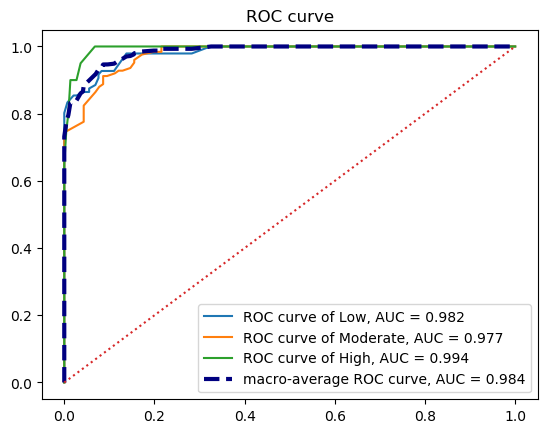

In [88]:
from sklearn.metrics import RocCurveDisplay
plt.title("ROC curve")
n_classes = len(target_mapping)
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    y_true = y_test == i
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label="ROC curve of {0}, AUC = {1:0.3f}".format(target_mapping[i], roc_auc[i]))

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = np.append(np.append([0], all_fpr),[1])
tpr["macro"] = np.append(np.append([0], mean_tpr),[1])
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve, AUC = {0:0.3f}".format(roc_auc["macro"]),
    color="navy",
    linestyle="--",
    lw=3
)


plt.plot([0,1], [0,1], linestyle=":")

plt.legend();

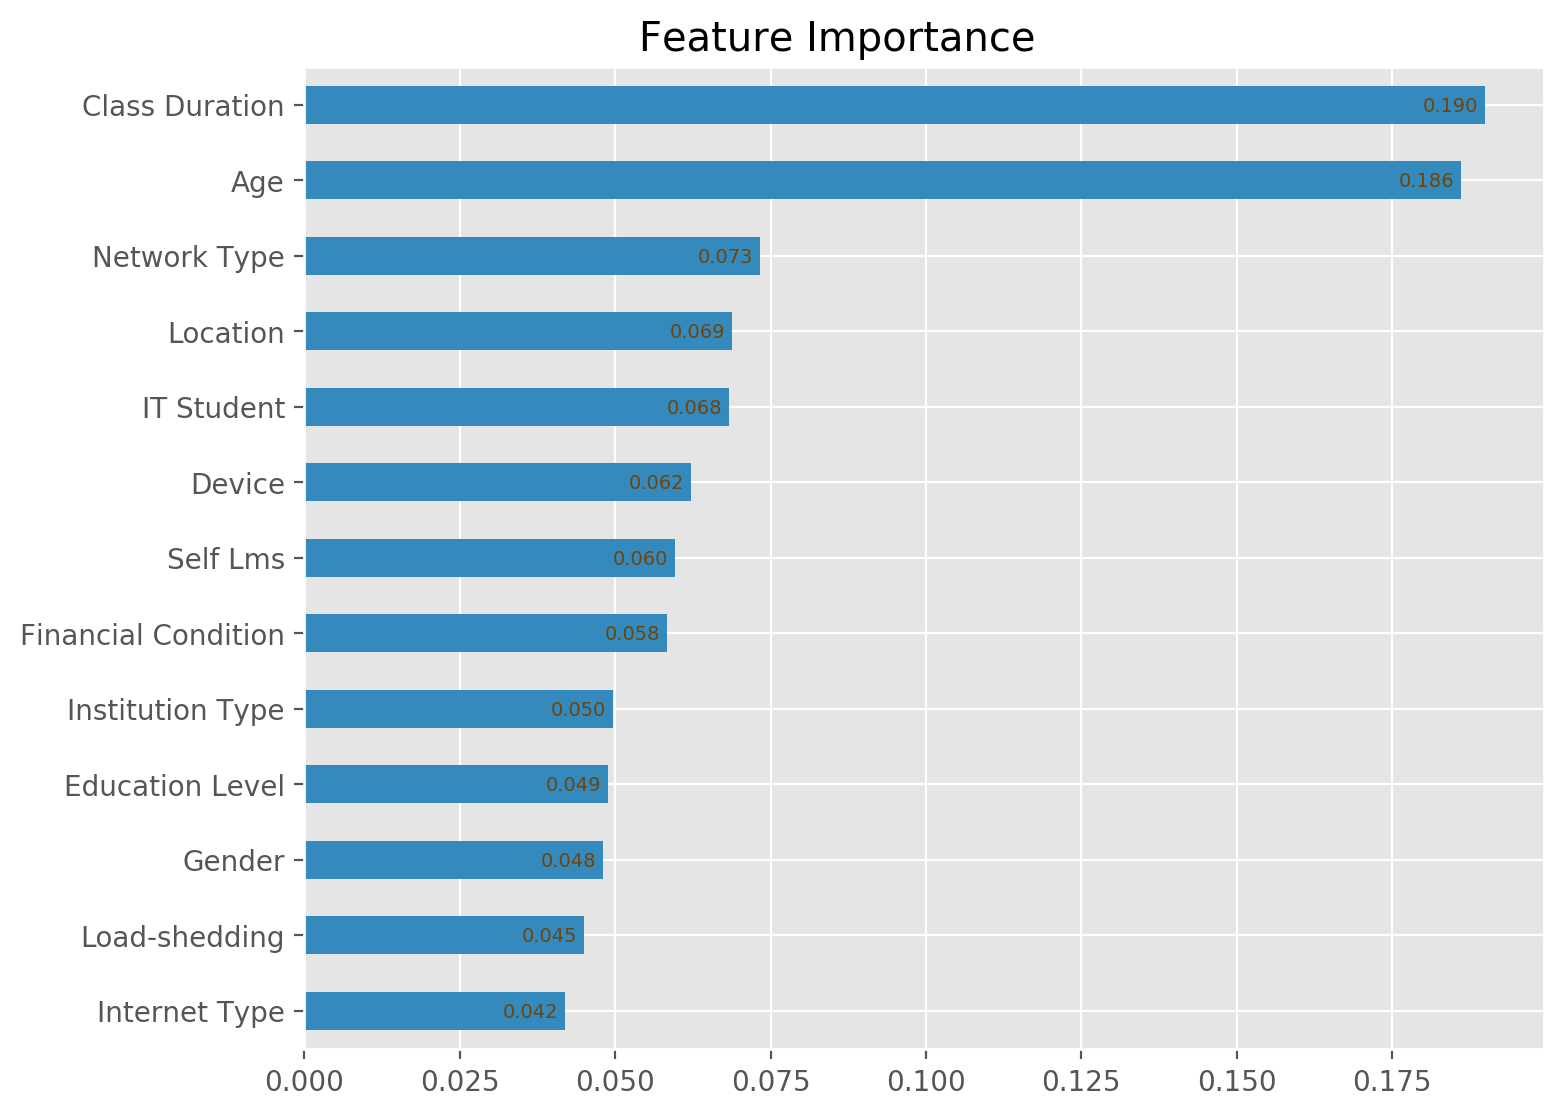

In [73]:
fi = pd.Series(data=optimal_model.feature_importances_, index=X_train.columns).sort_values()
plt.figure(figsize=(8,6.5))
fi.plot.barh(color="#348ABD")
plt.title("Feature Importance", x=0.43)
for i, c in enumerate(fi.index):
    plt.text(x=fi.loc[c]-0.01, y=i-0.01, s="{0:.3f}".format(fi.loc[c]), fontsize=7, ha="left", va = "center", color="#704409")

In [75]:
permuter = PermutationImportance(
    estimator=optimal_model,
    scoring="f1_macro",
    n_iter=1000,
    random_state=42
)

permuter.fit(X_test, y_test)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.670914094673397,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.2135708270467419,
        

In [76]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=X_test.columns.tolist()
)


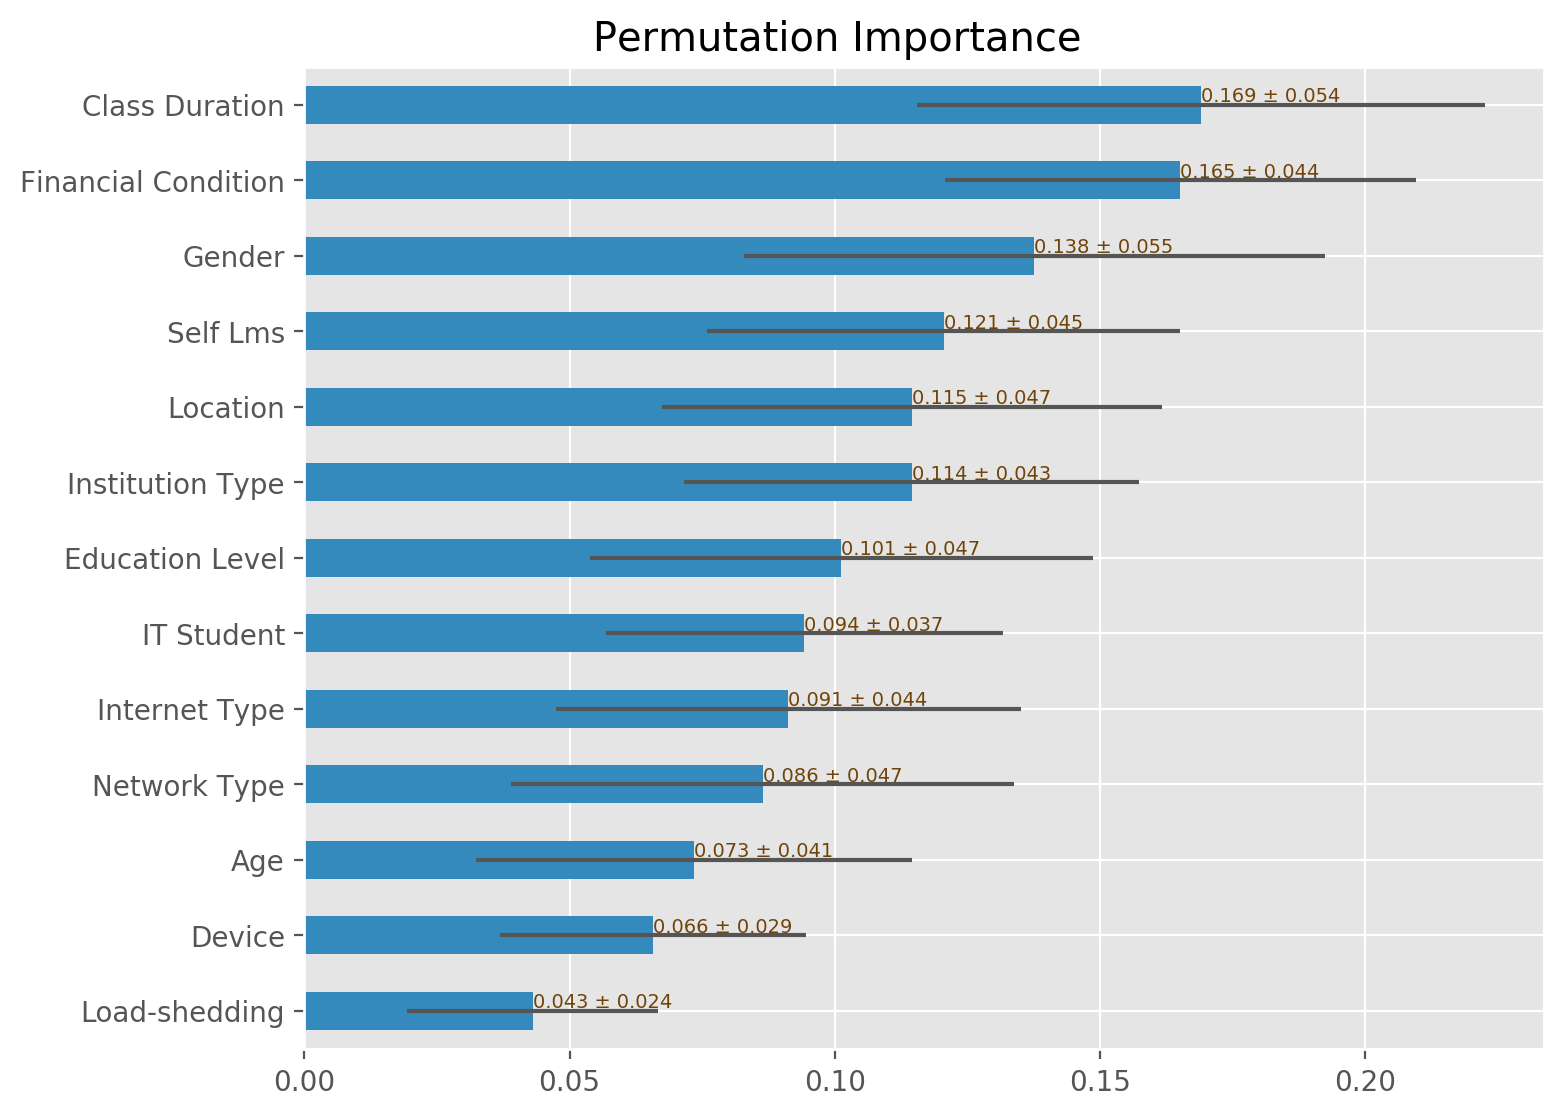

In [77]:
plt.figure(figsize=(8,6.5))
pi = pd.DataFrame(np.array([permuter.feature_importances_, permuter.feature_importances_std_*2]).T, index=X_test.columns, columns=["Permutation Importance", "std"])
pi = pi.sort_values(by="Permutation Importance")
pi, std = pi["Permutation Importance"], pi["std"]
pi.plot.barh(color="#348ABD", xerr=std)
plt.title("Permutation Importance", x=0.43)
for i, c in enumerate(pi.index):
    plt.text(x=pi.loc[c], y=i-0.01, s="{0:.3f} ± {1:.3f}".format(pi.loc[c], std.loc[c]), fontsize=7, ha="left", va = "bottom", color="#704409")

In [81]:
list(reverse_mapping[feature].keys())

TypeError: ignored

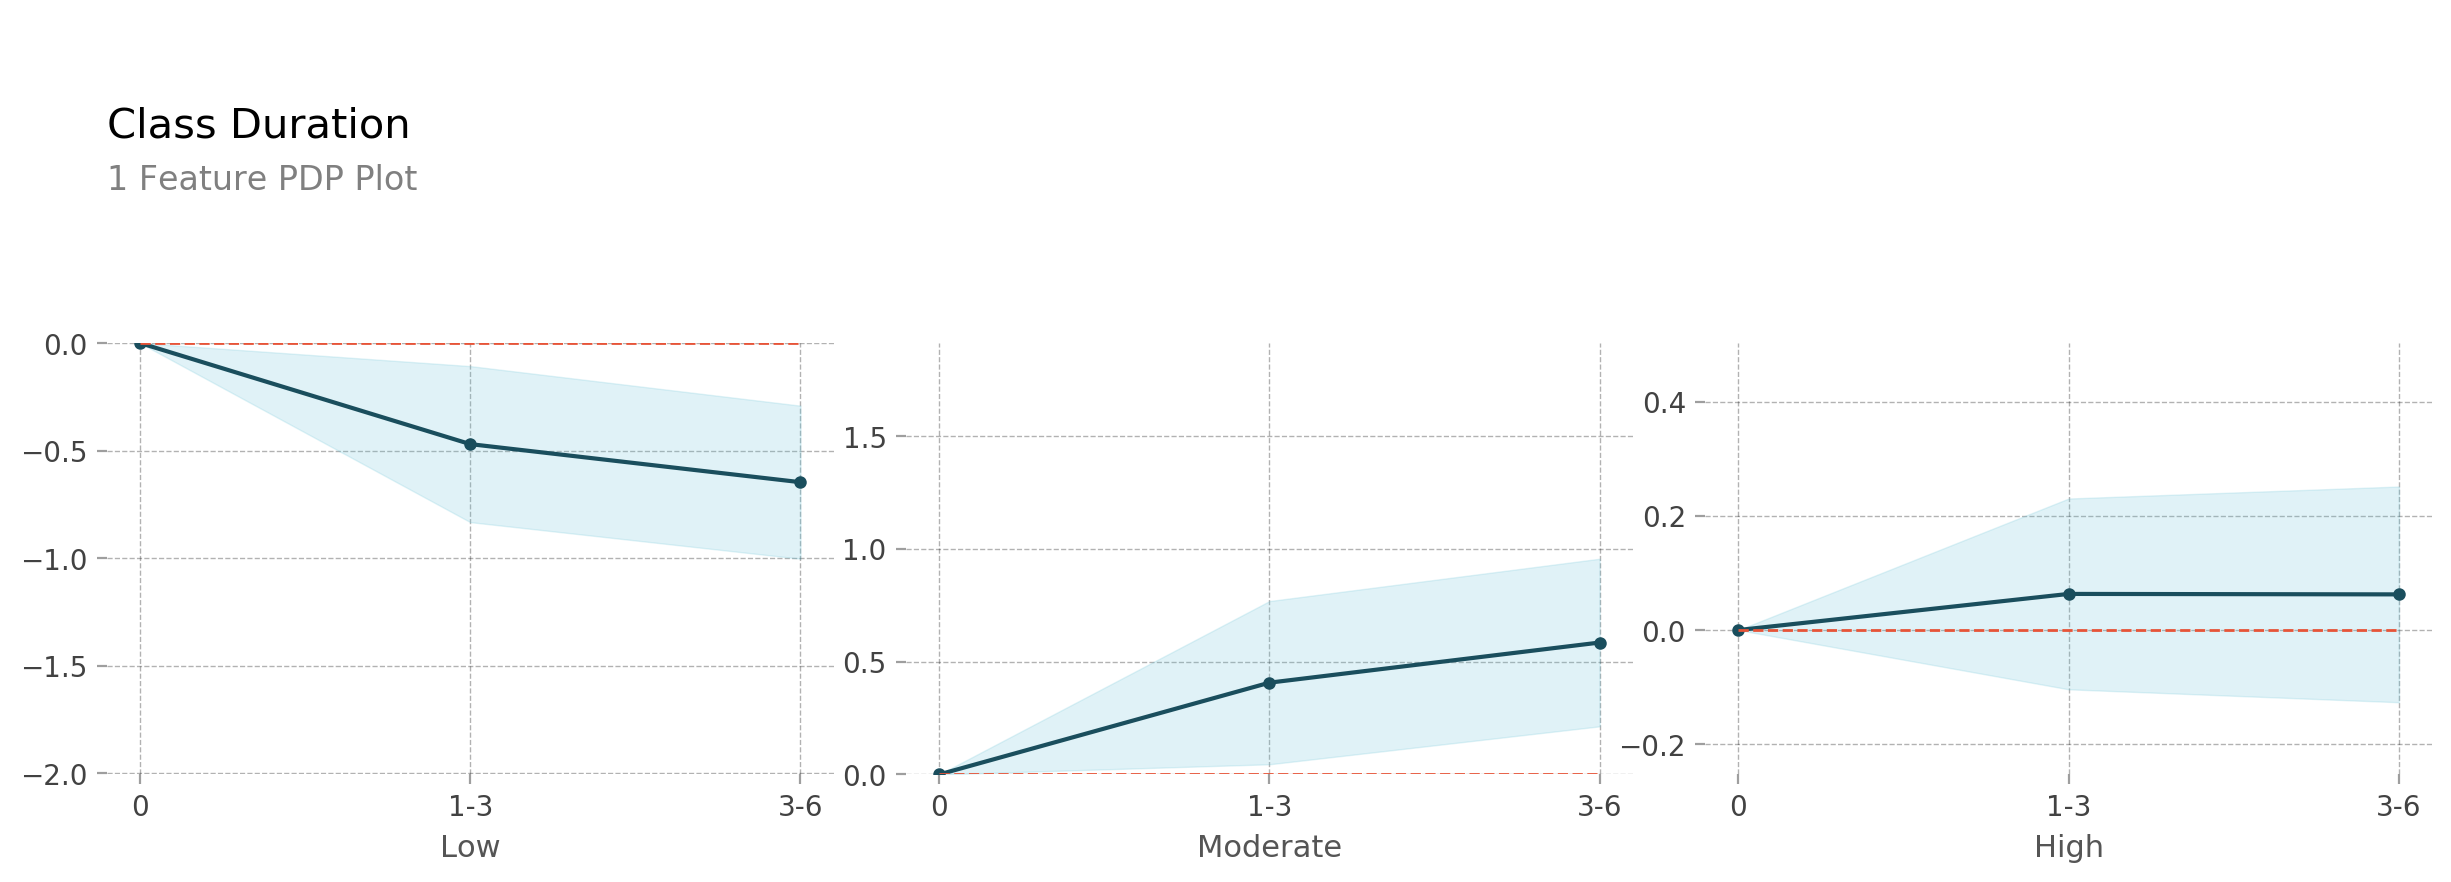

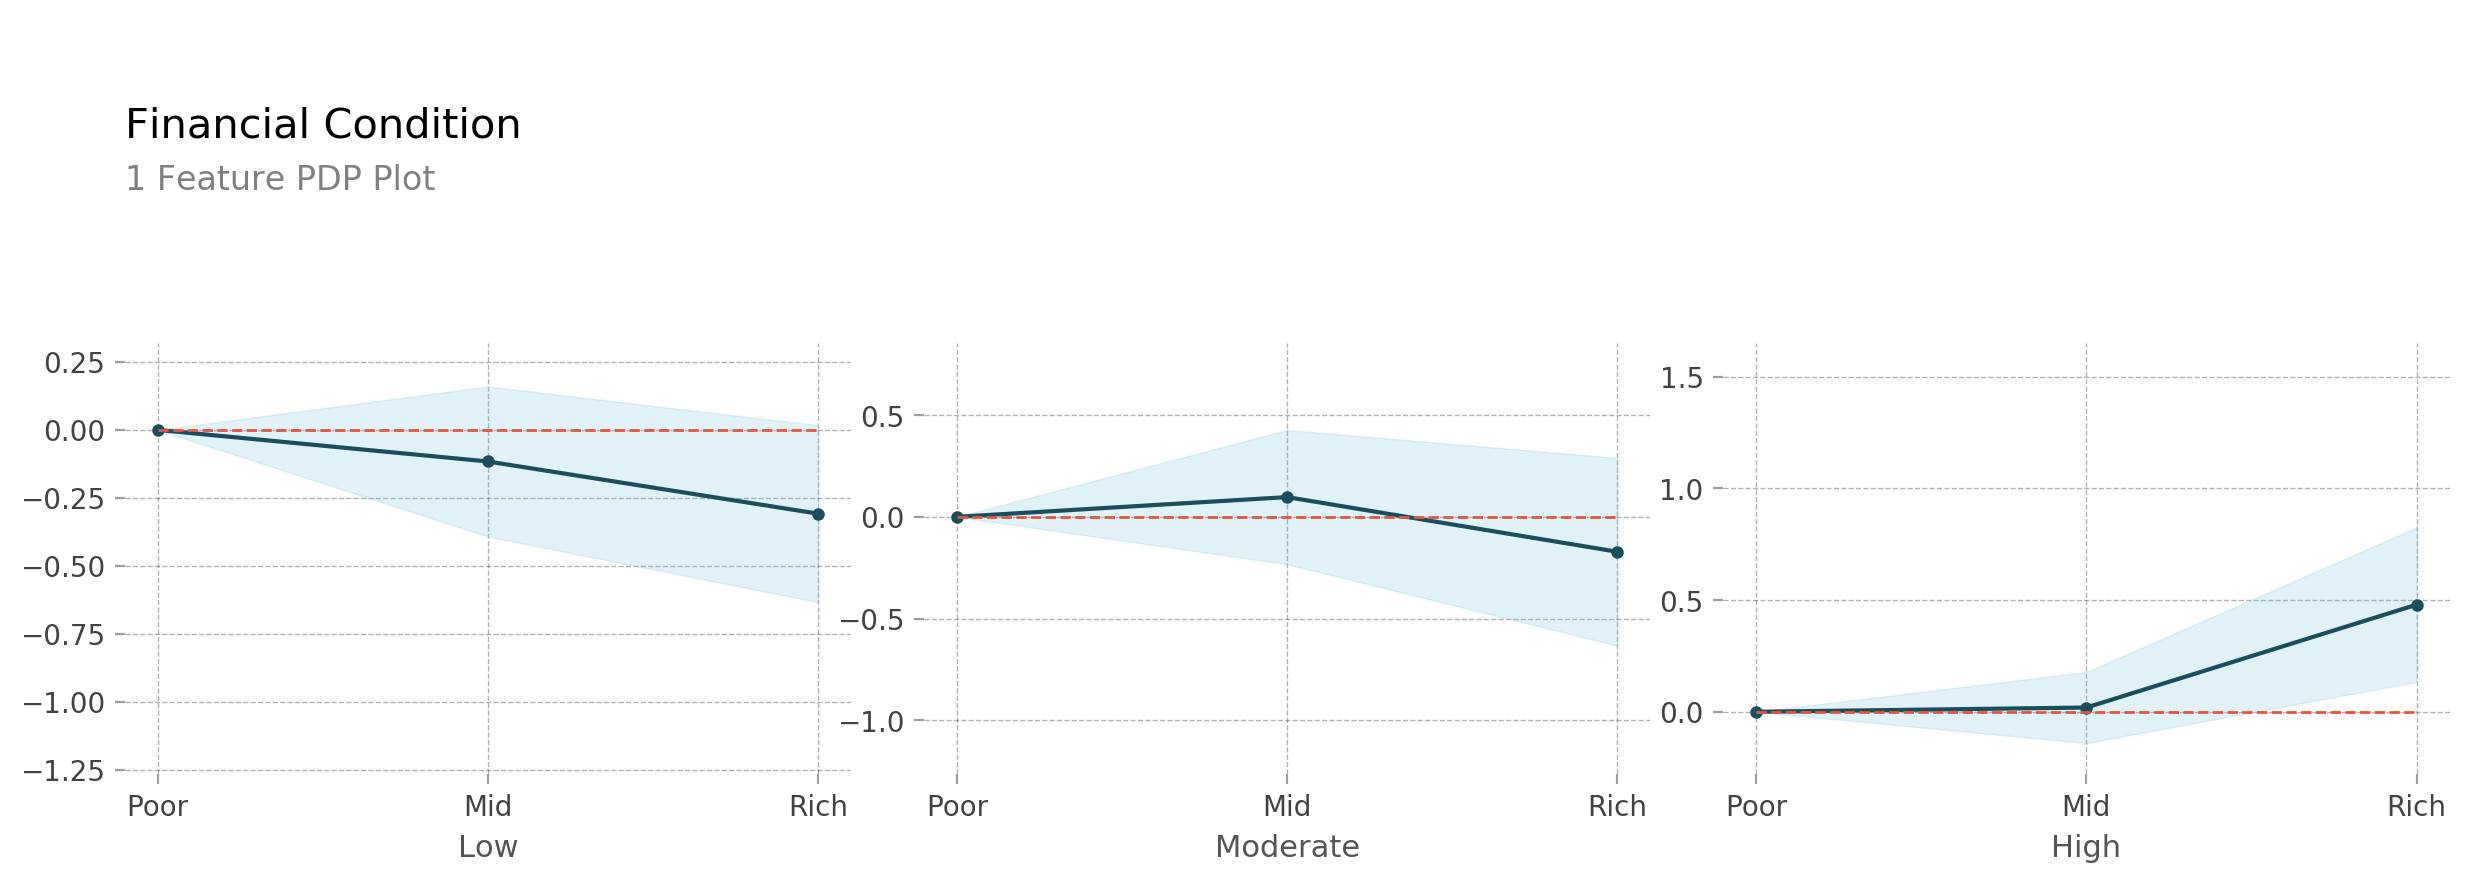

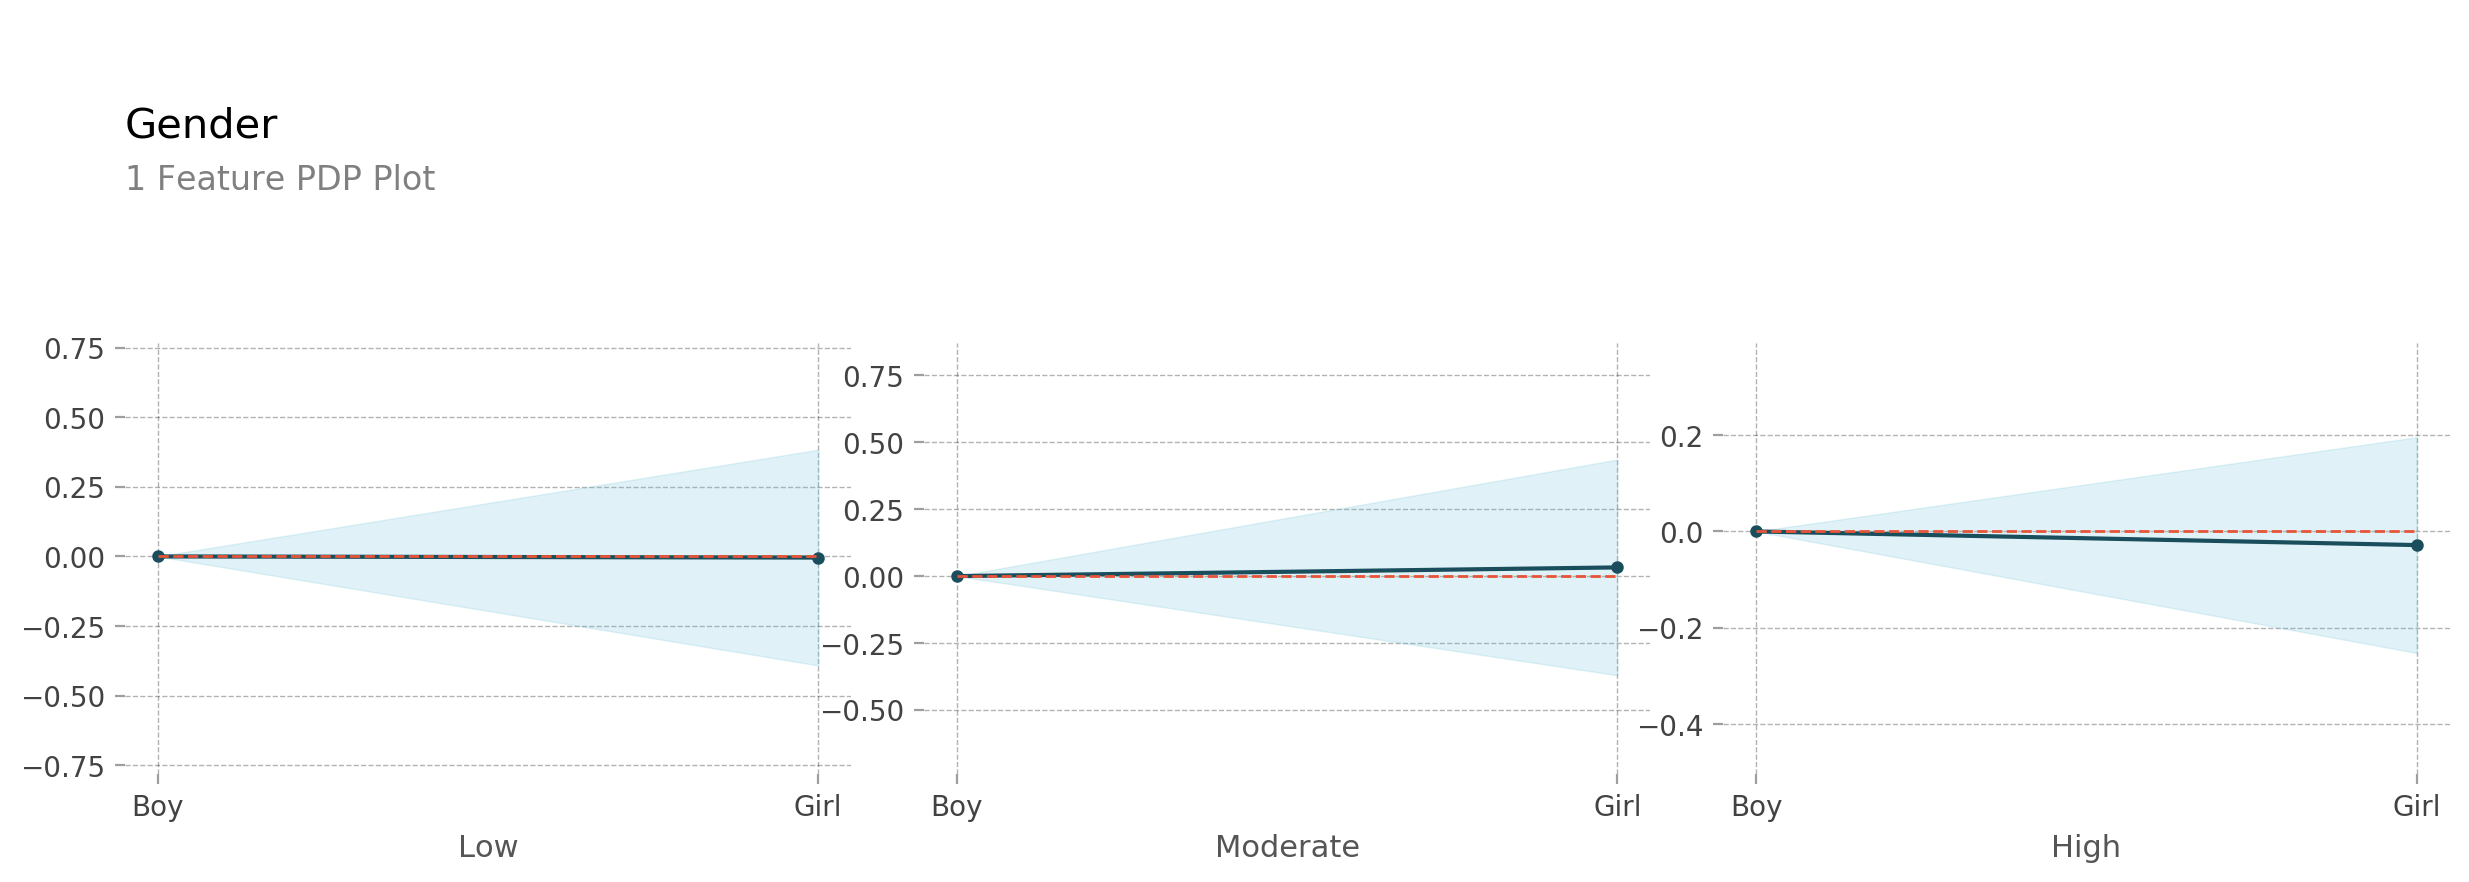

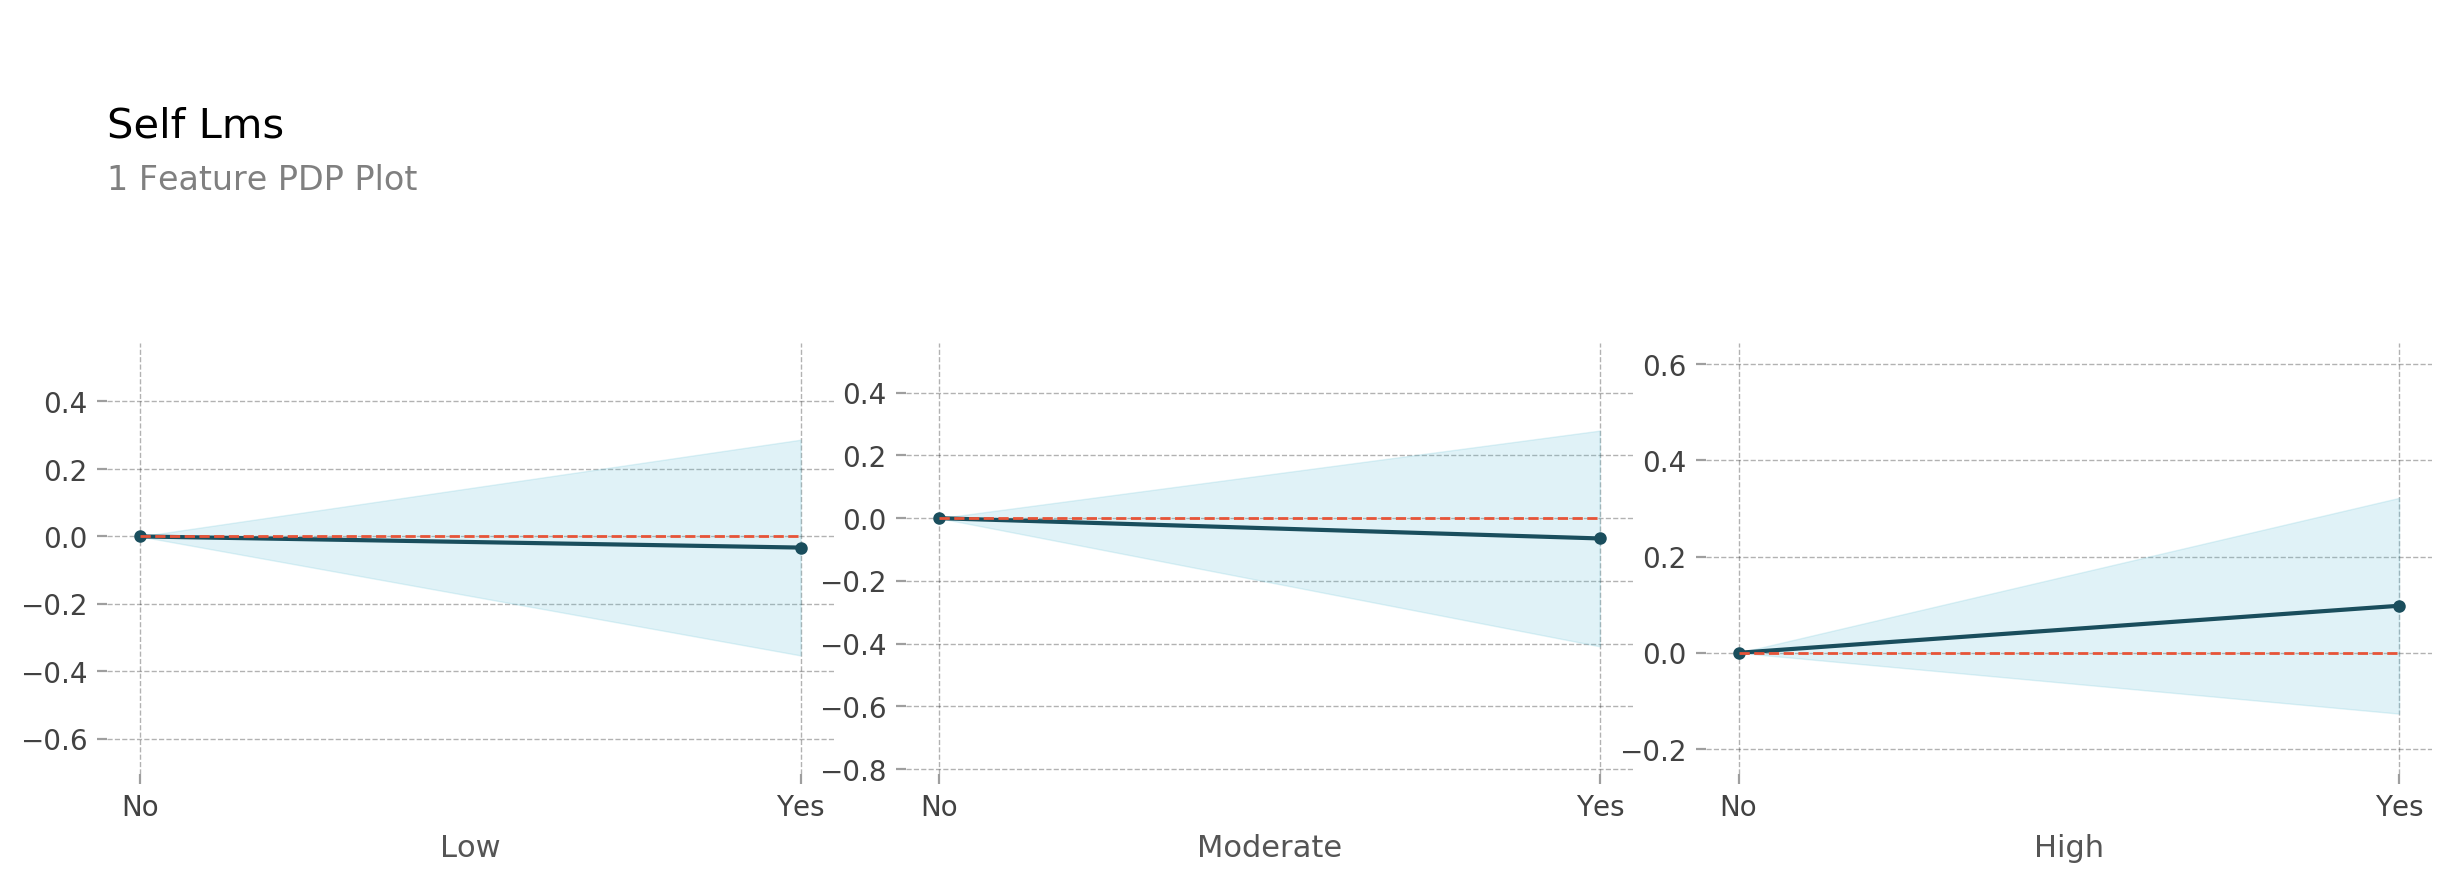

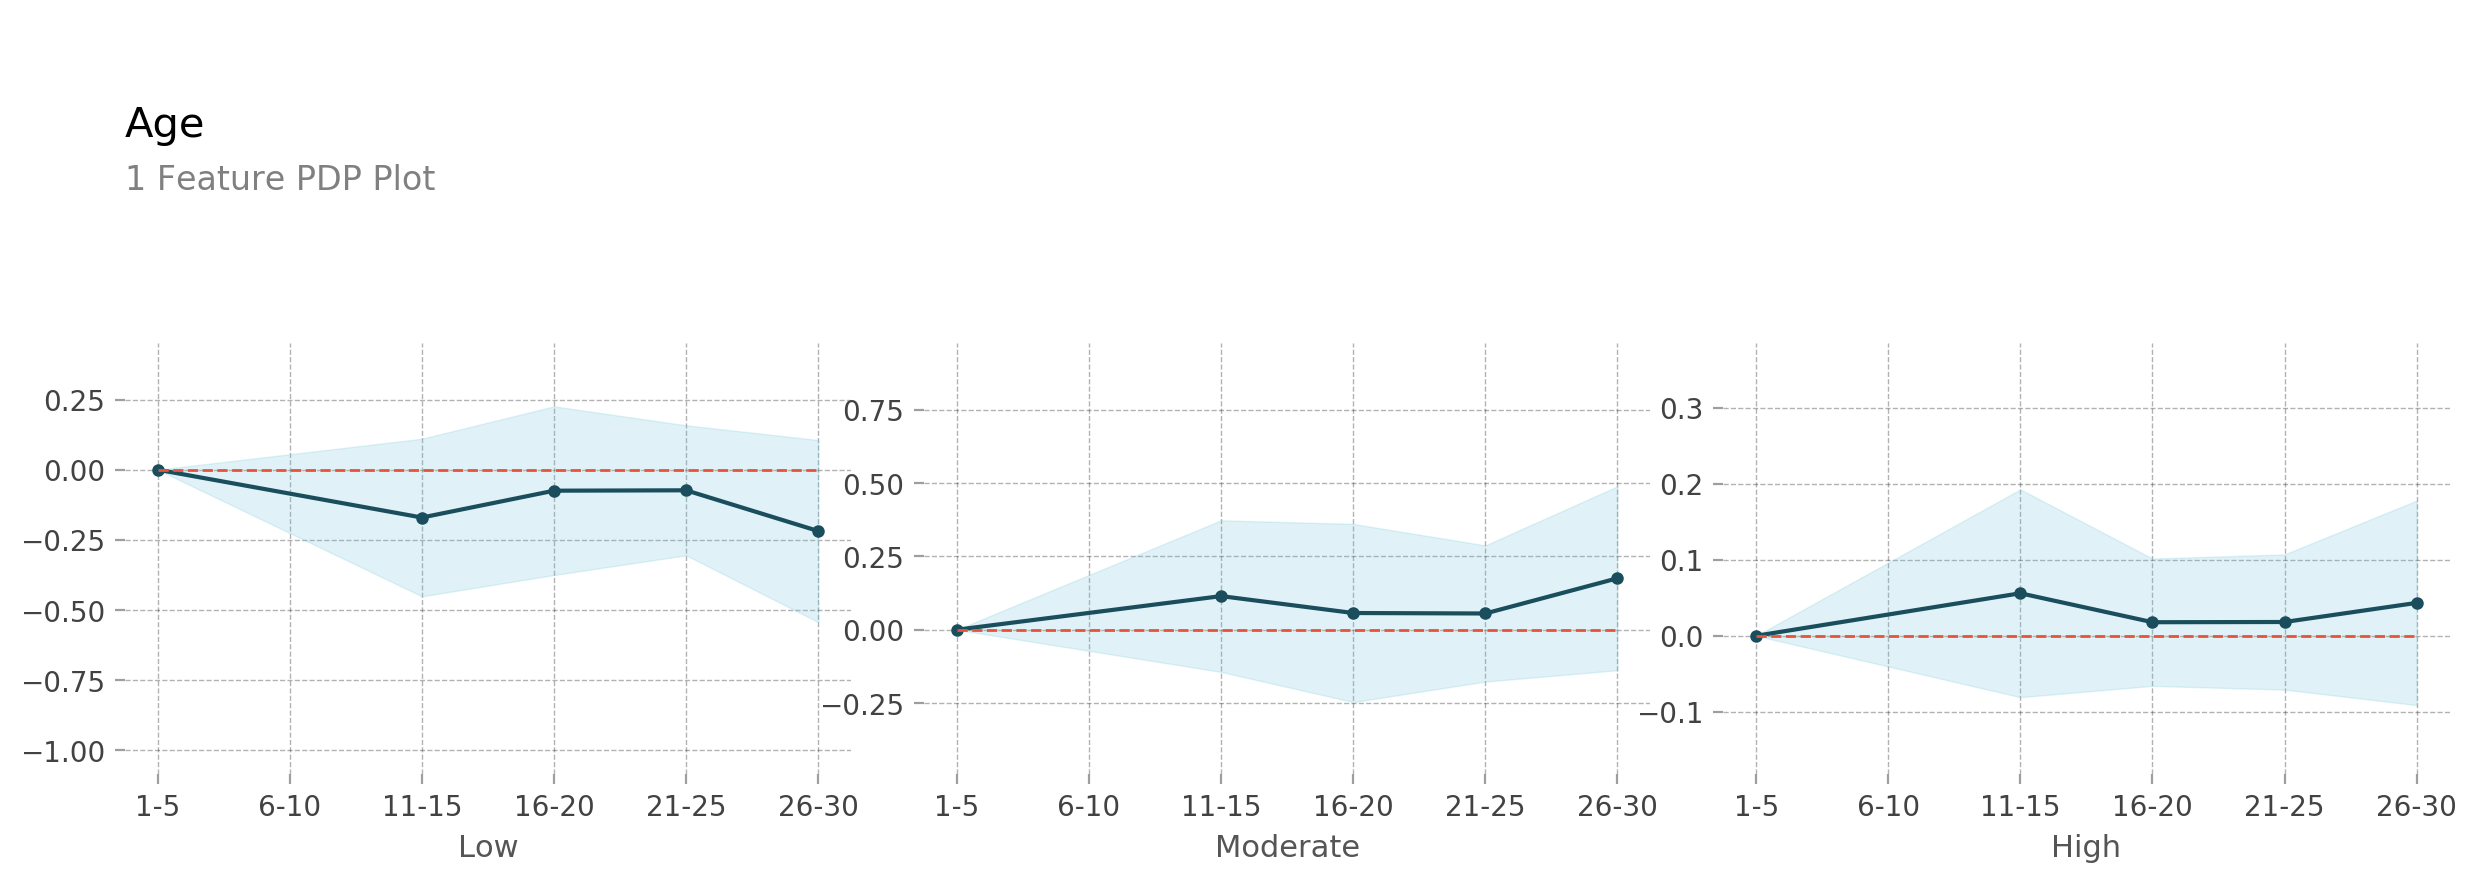

In [82]:
features = pi.index.tolist()[:-5:-1] + ["Age"]
for idx, feature in enumerate(features):
    ticks = list(reverse_mapping[feature].keys())
    labels = list(reverse_mapping[feature].values())
    isolated = pdp_isolate(
        model=optimal_model, 
        dataset=X_test, 
        model_features=X_test.columns, 
        feature=feature,
        num_grid_points=10,
    )
    f, axes = pdp_plot(isolated,
                     feature_name=feature,
                     ncols=3,
                     plot_params = {
                         "title":"%s"%feature,
                         "subtitle":"1 Feature PDP Plot"
                     }
    )
    for class_idx, ax in enumerate(axes["pdp_ax"]):
        ax.set_xticks(ticks=ticks)
        ax.set_xticklabels(labels=labels)
        ax.set_xlabel(target_mapping[class_idx])

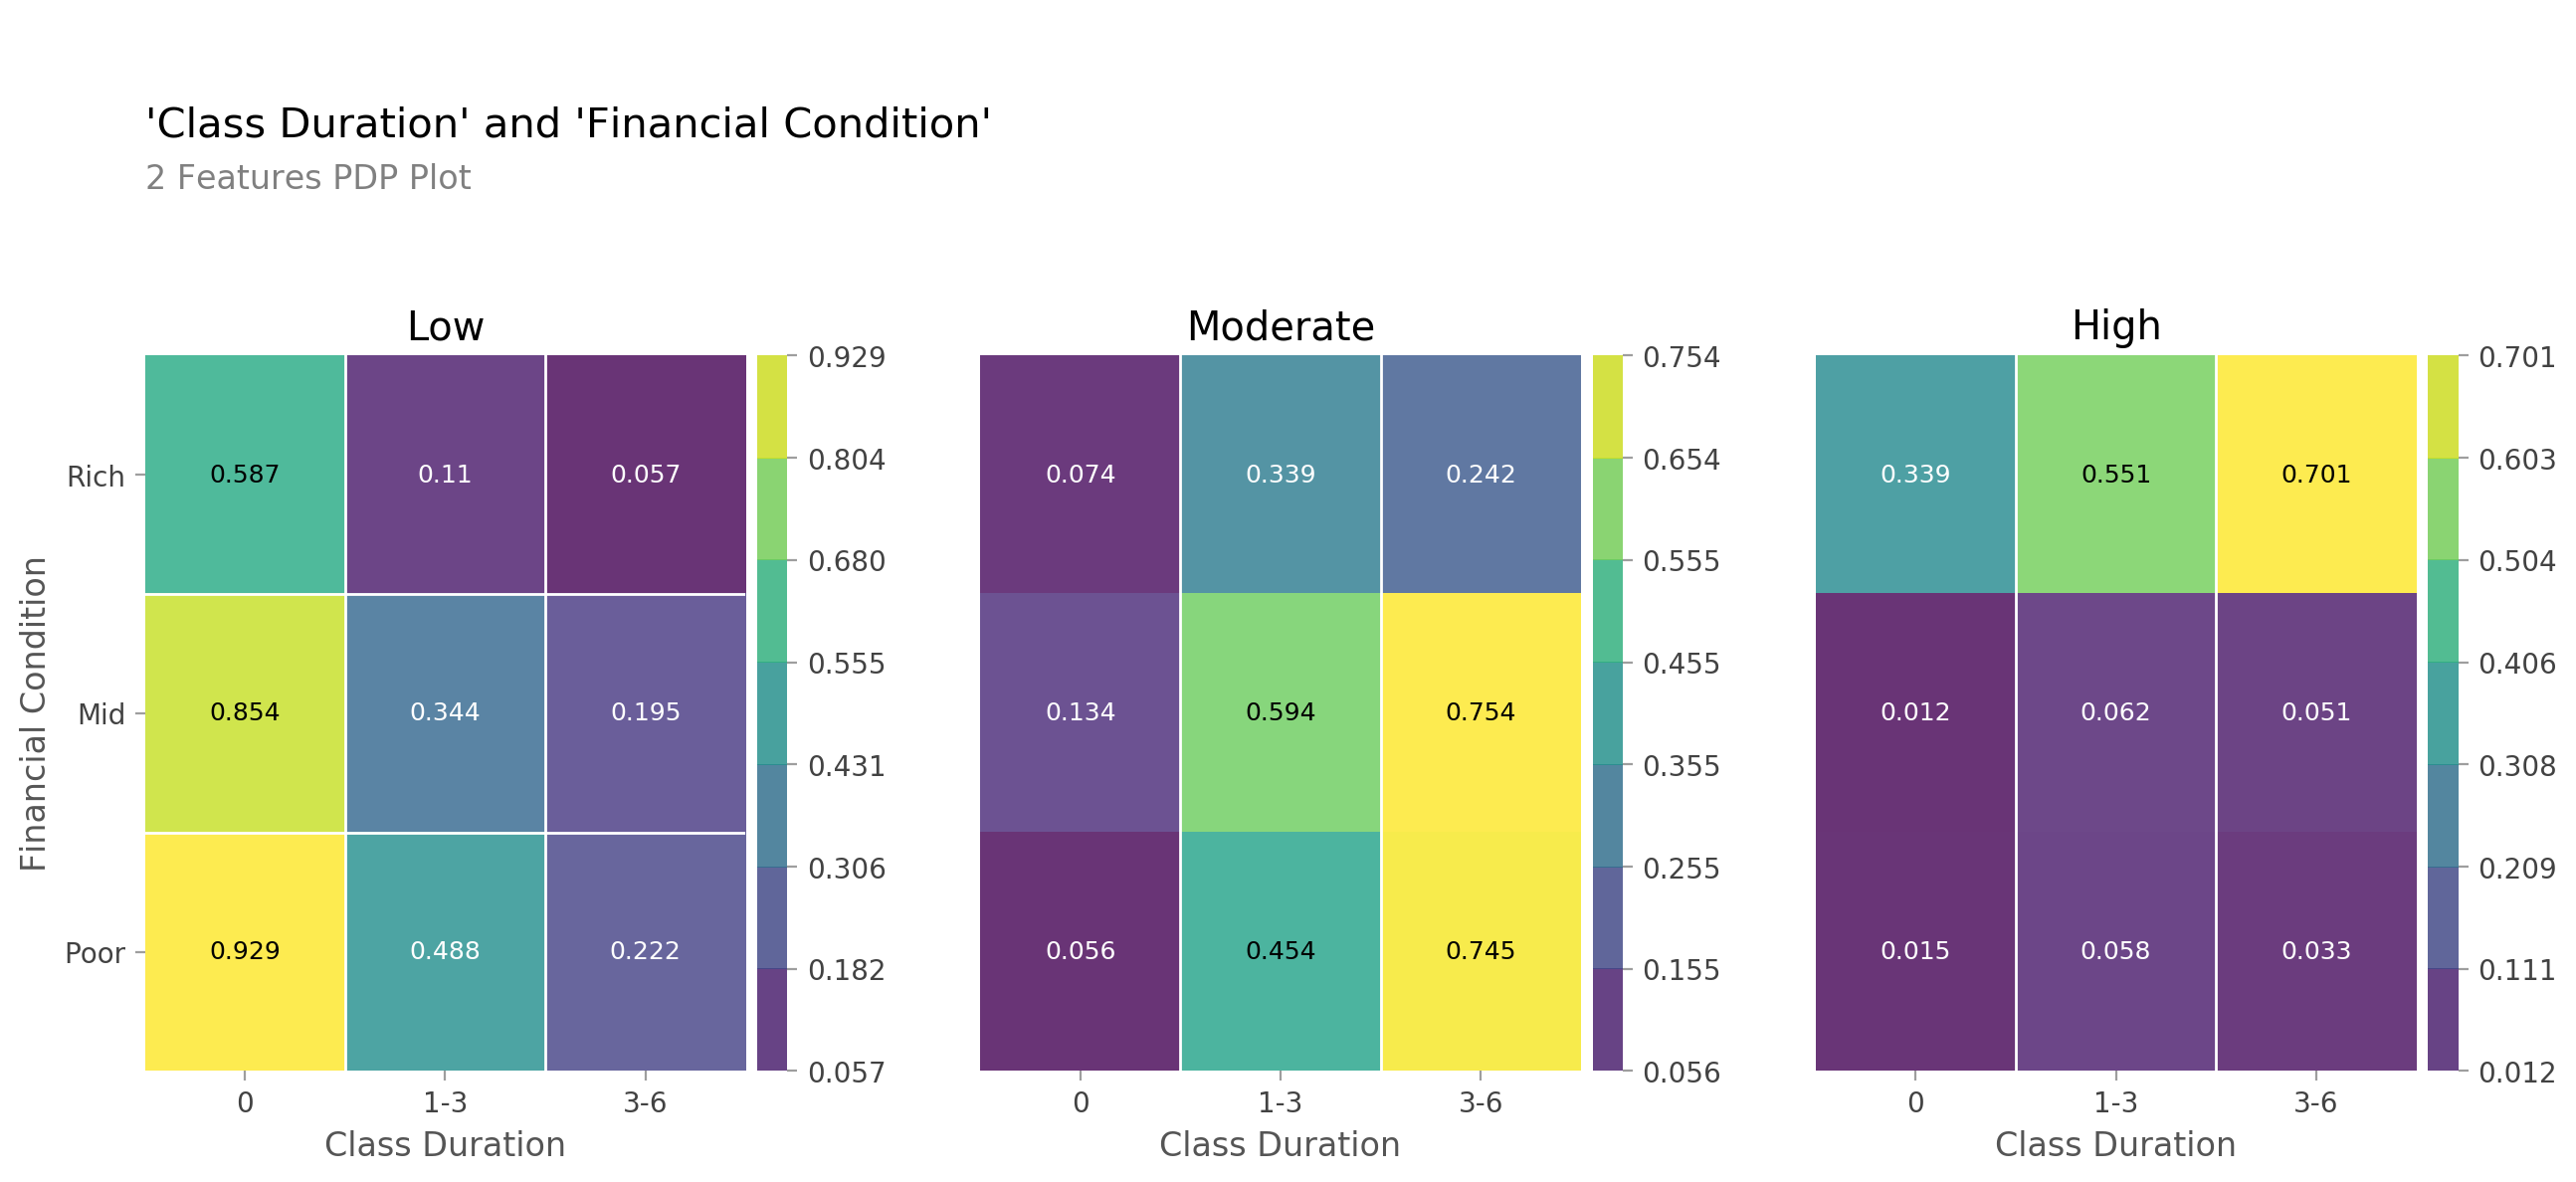

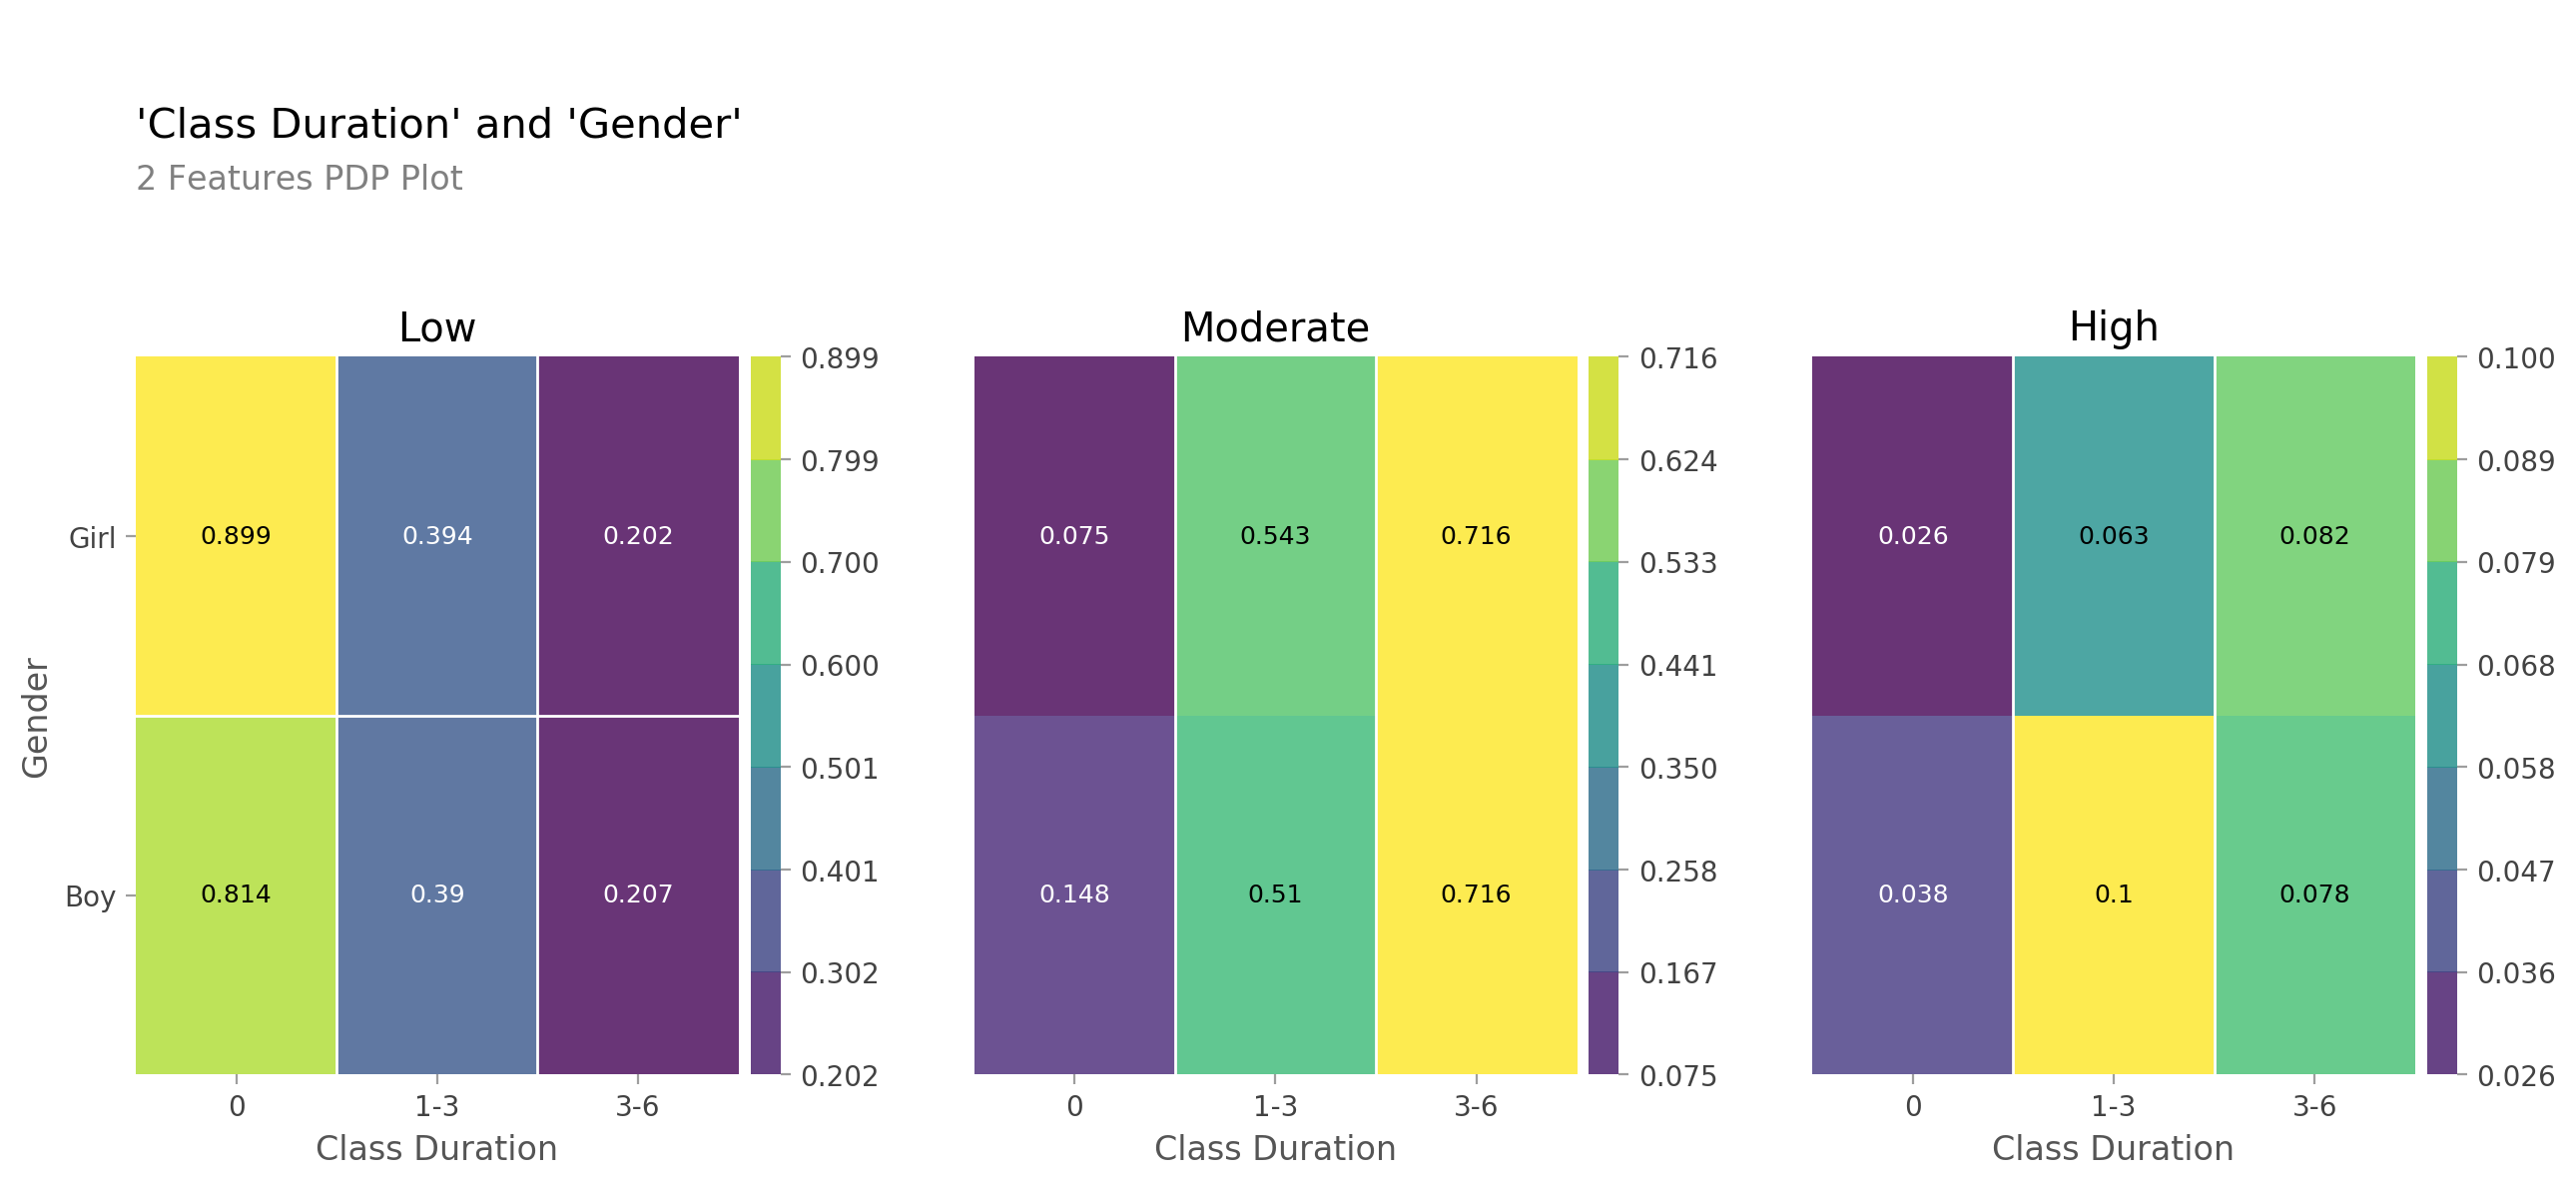

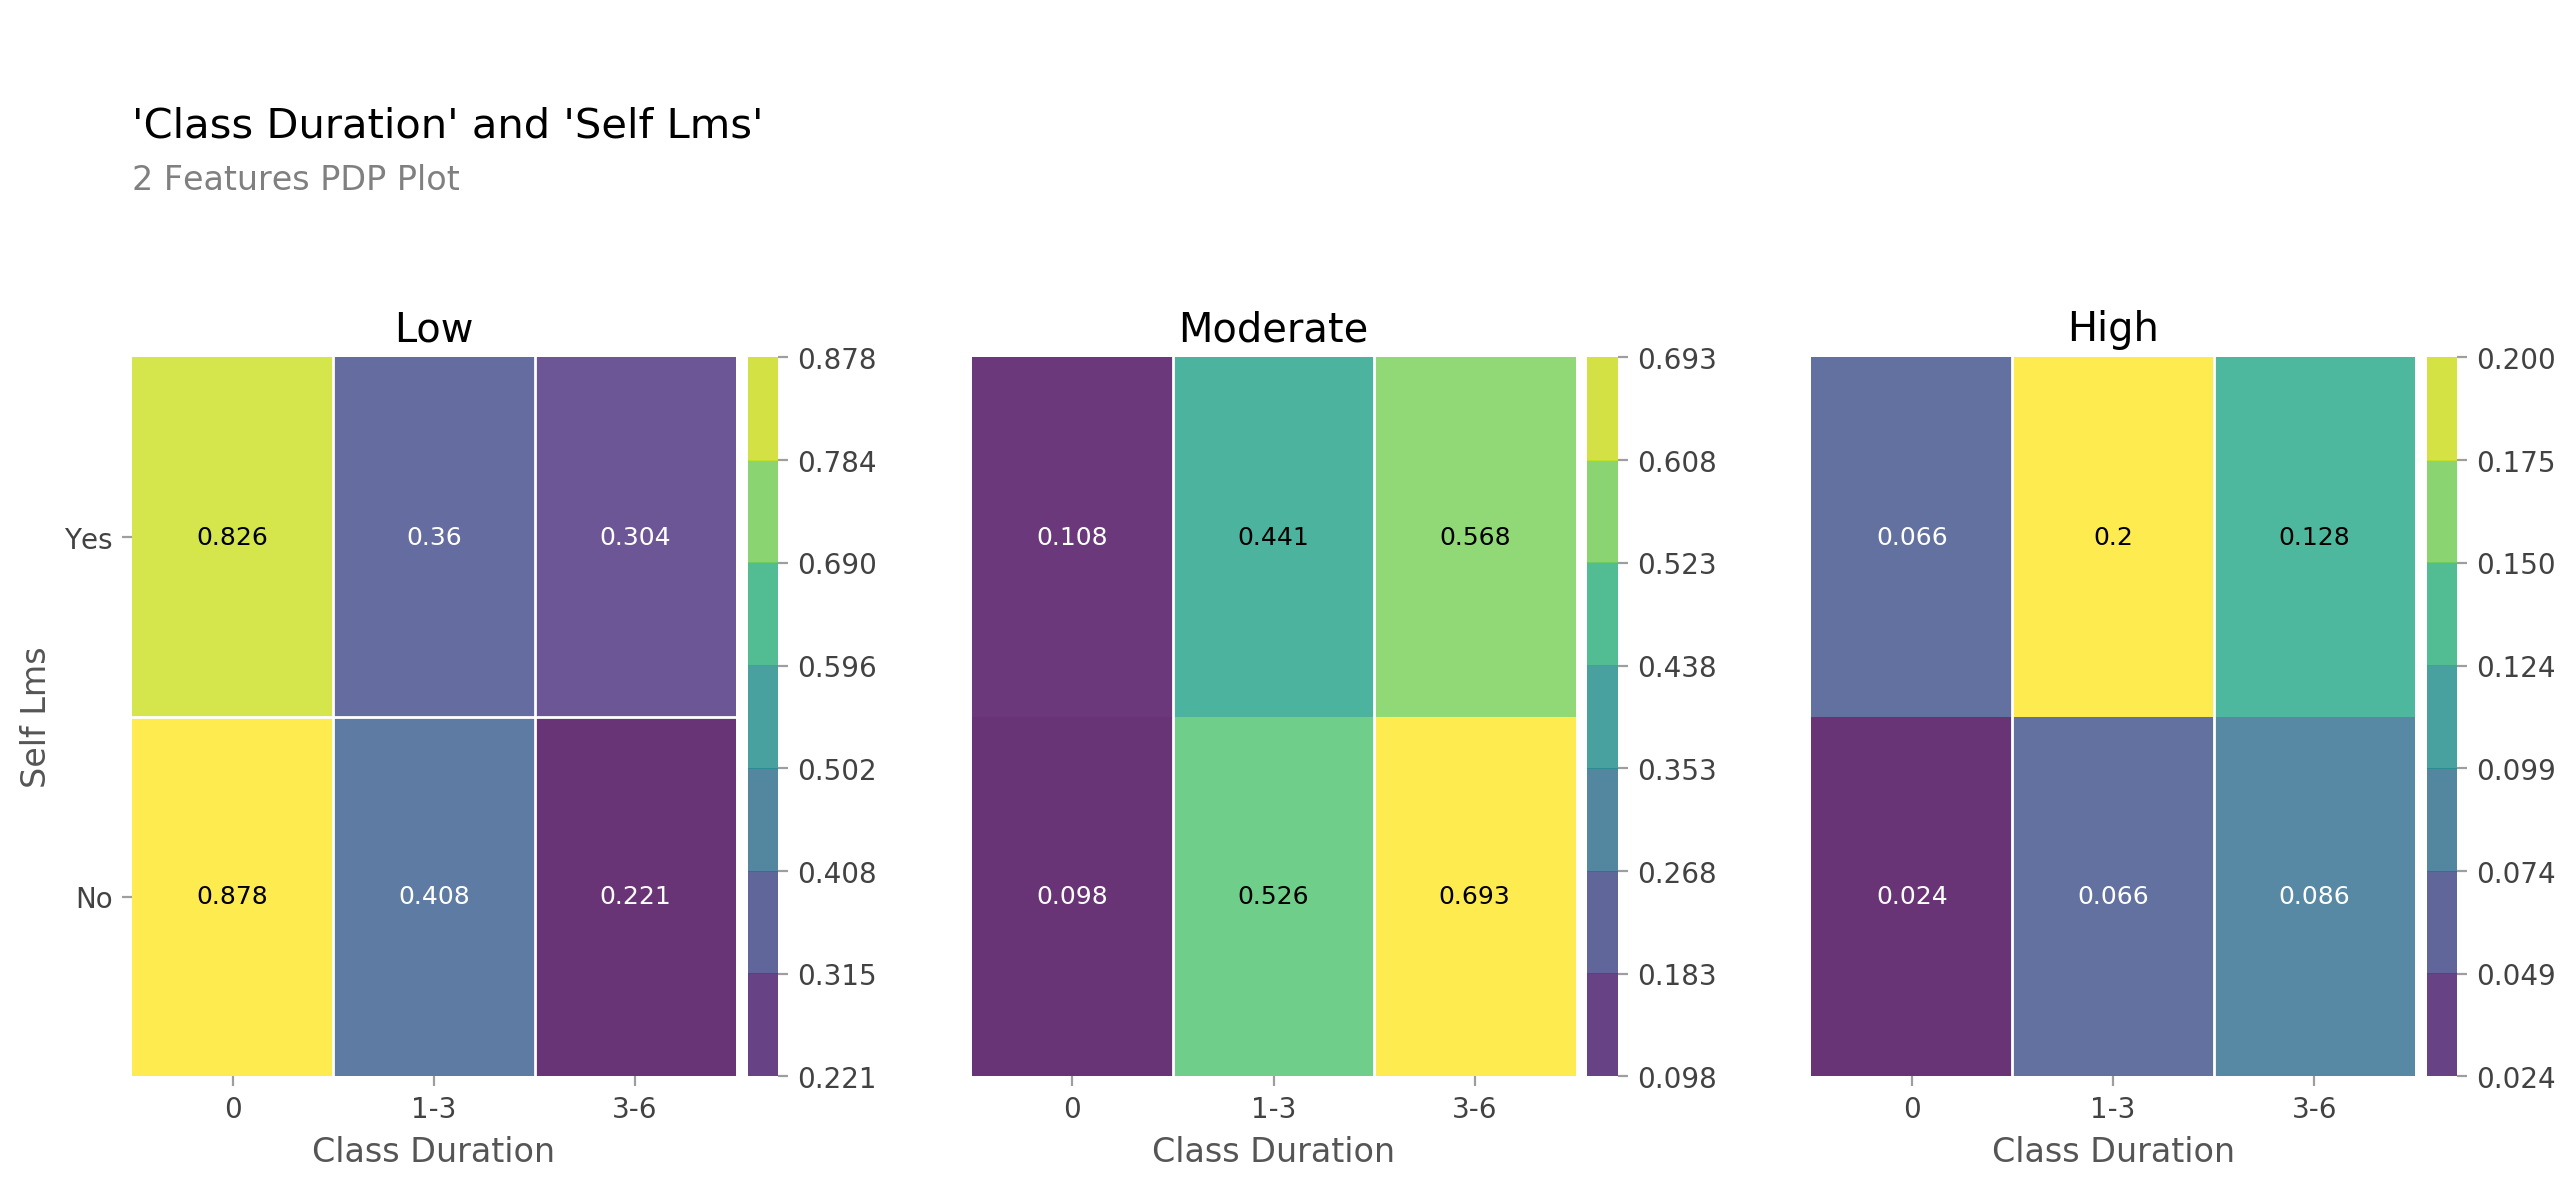

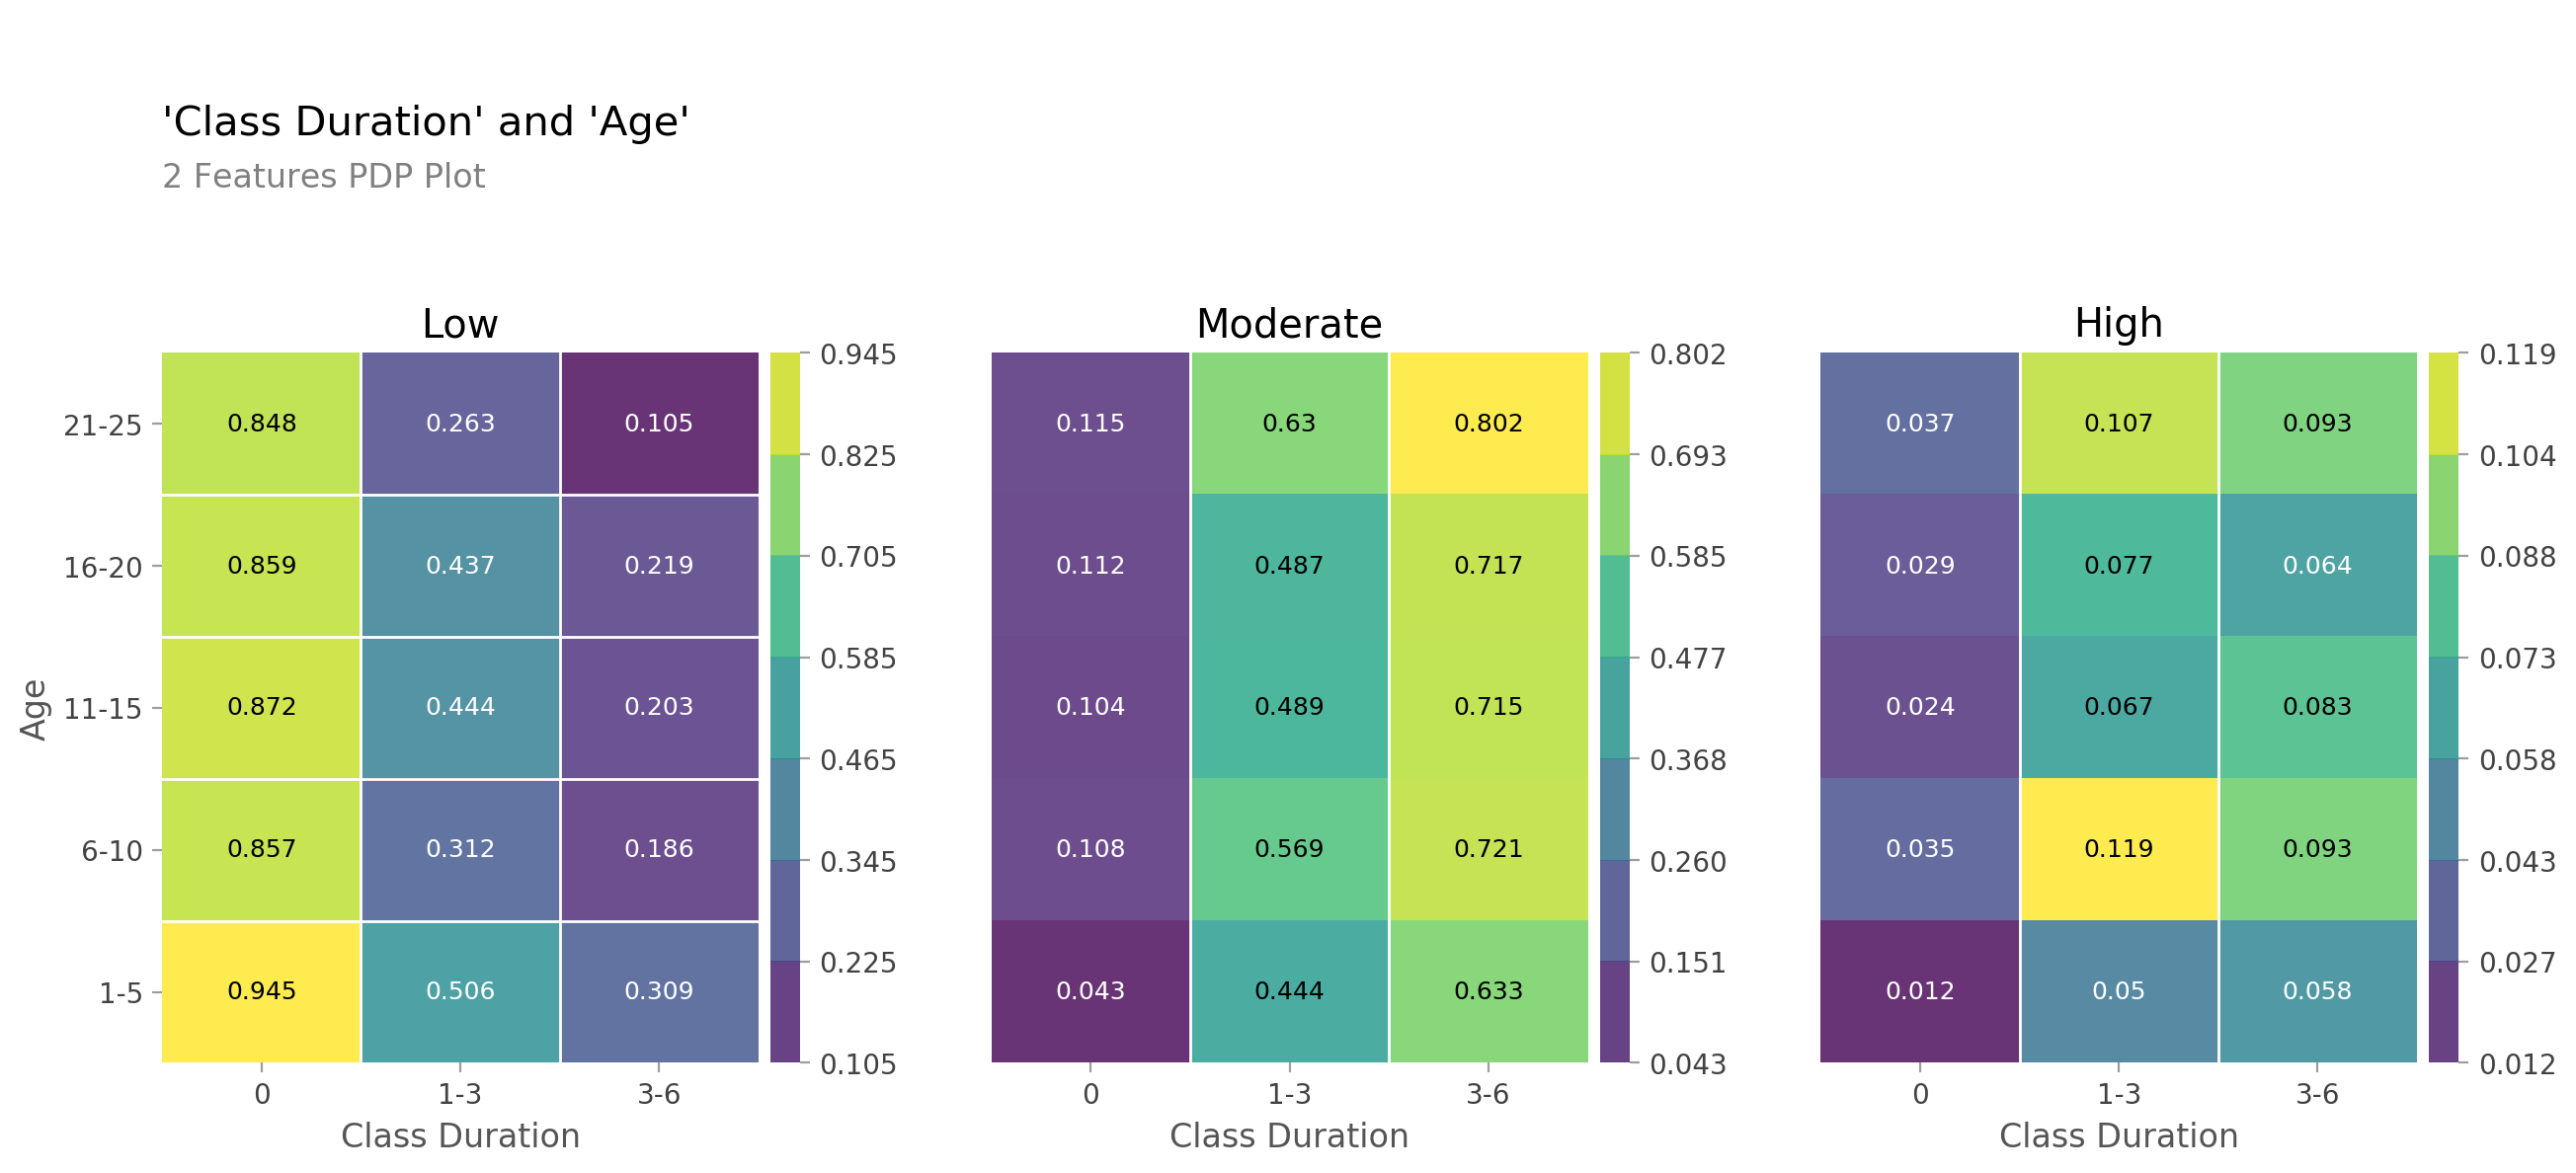

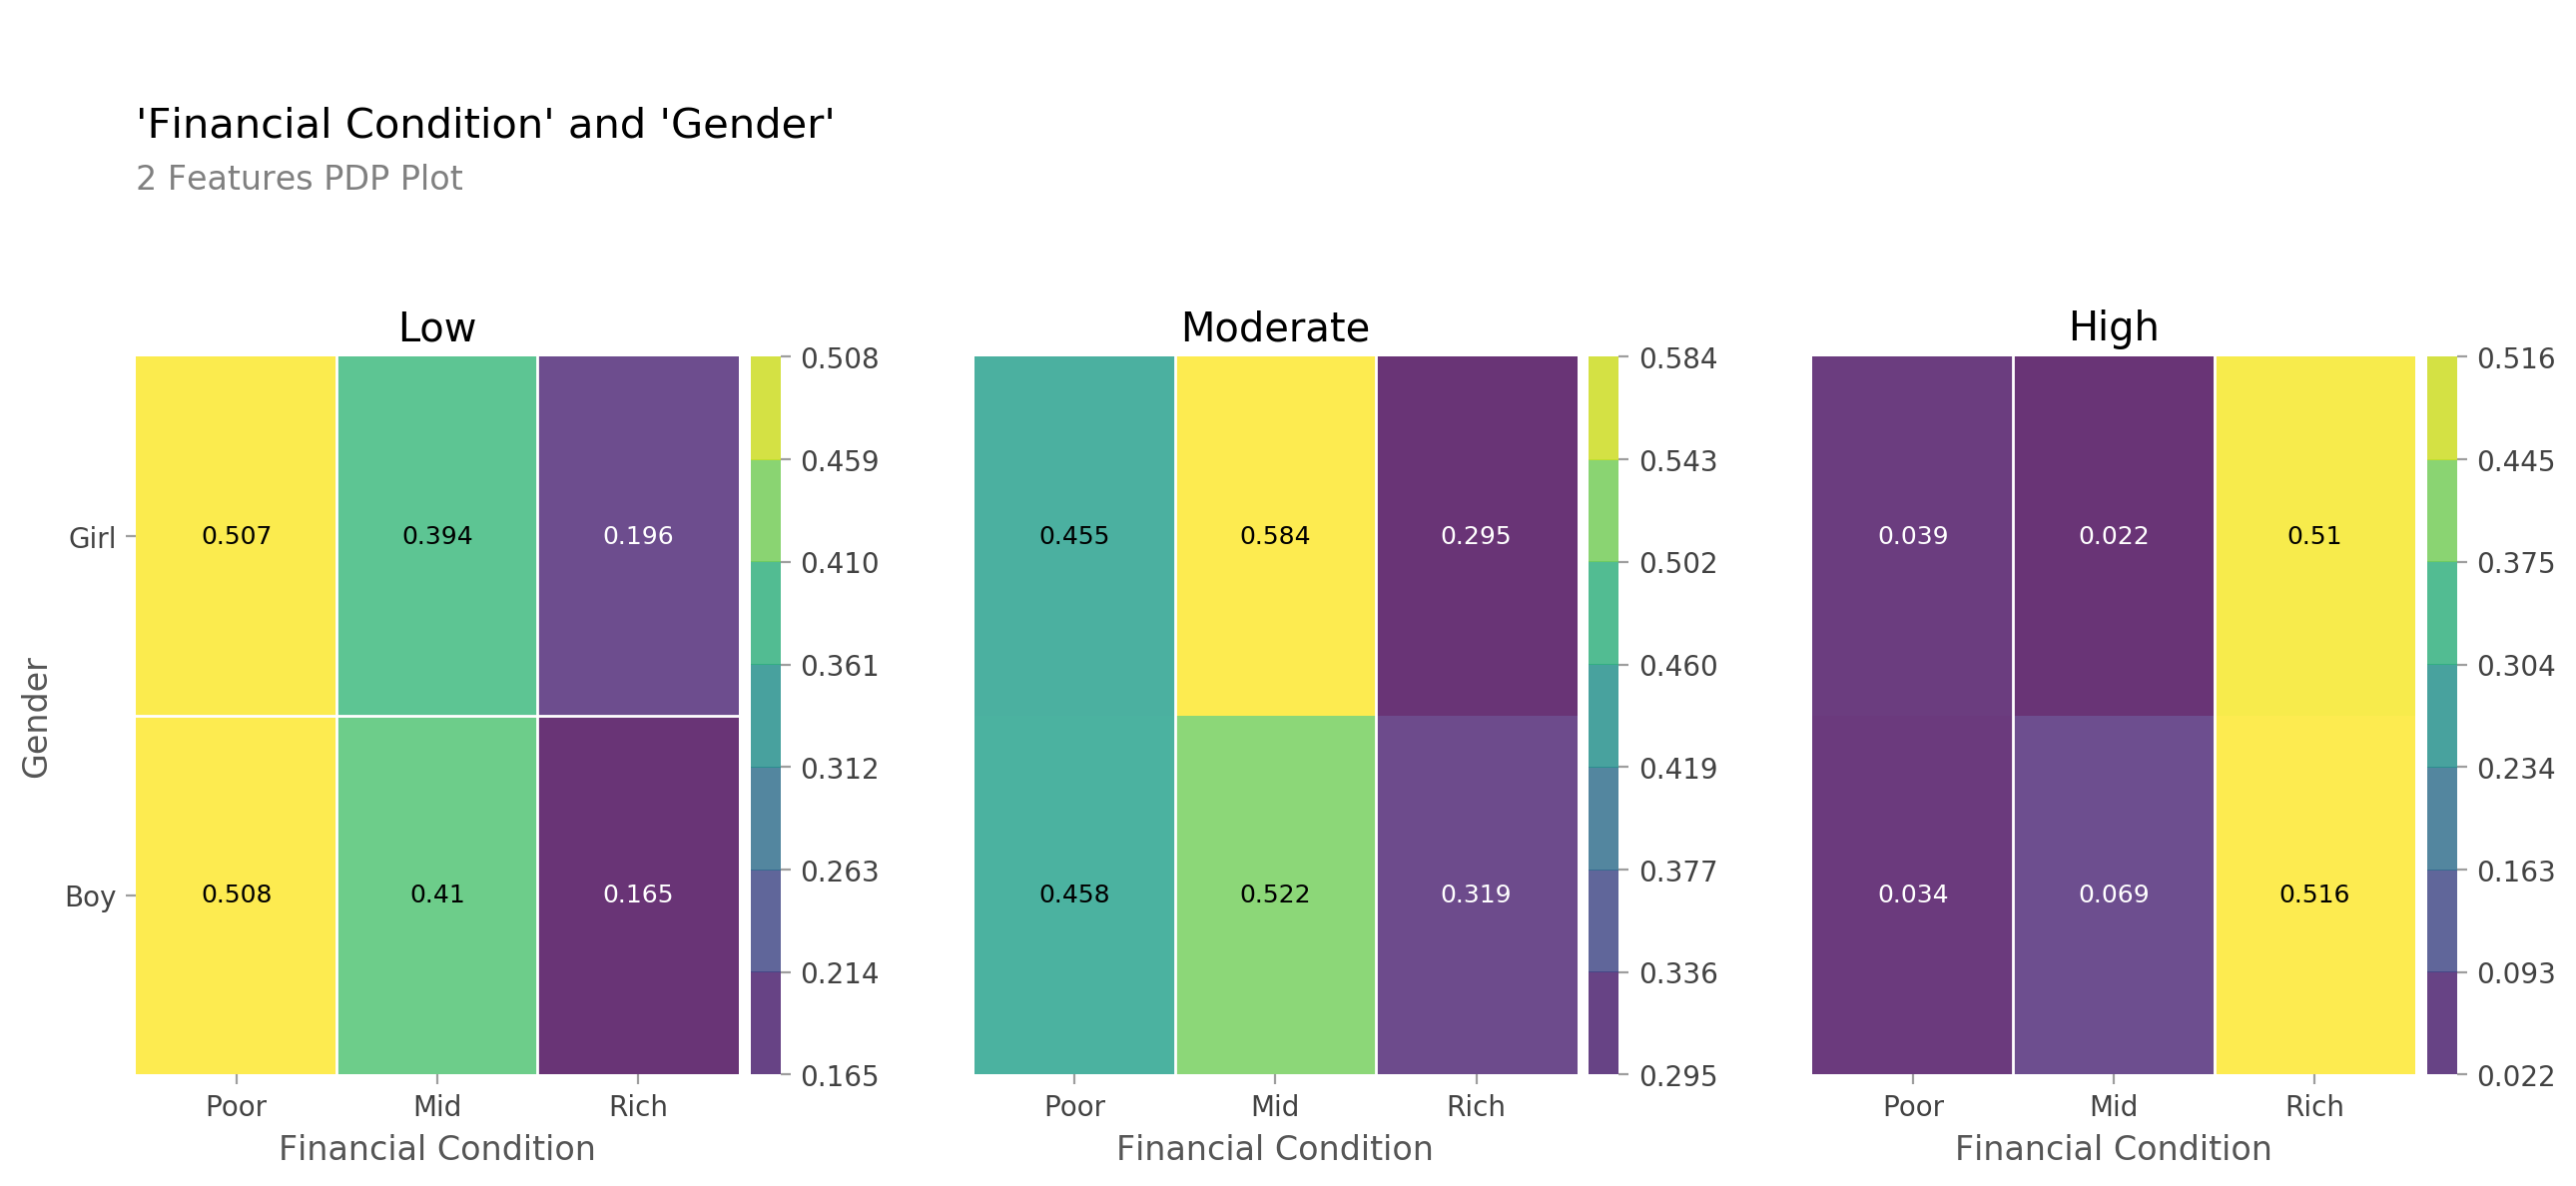

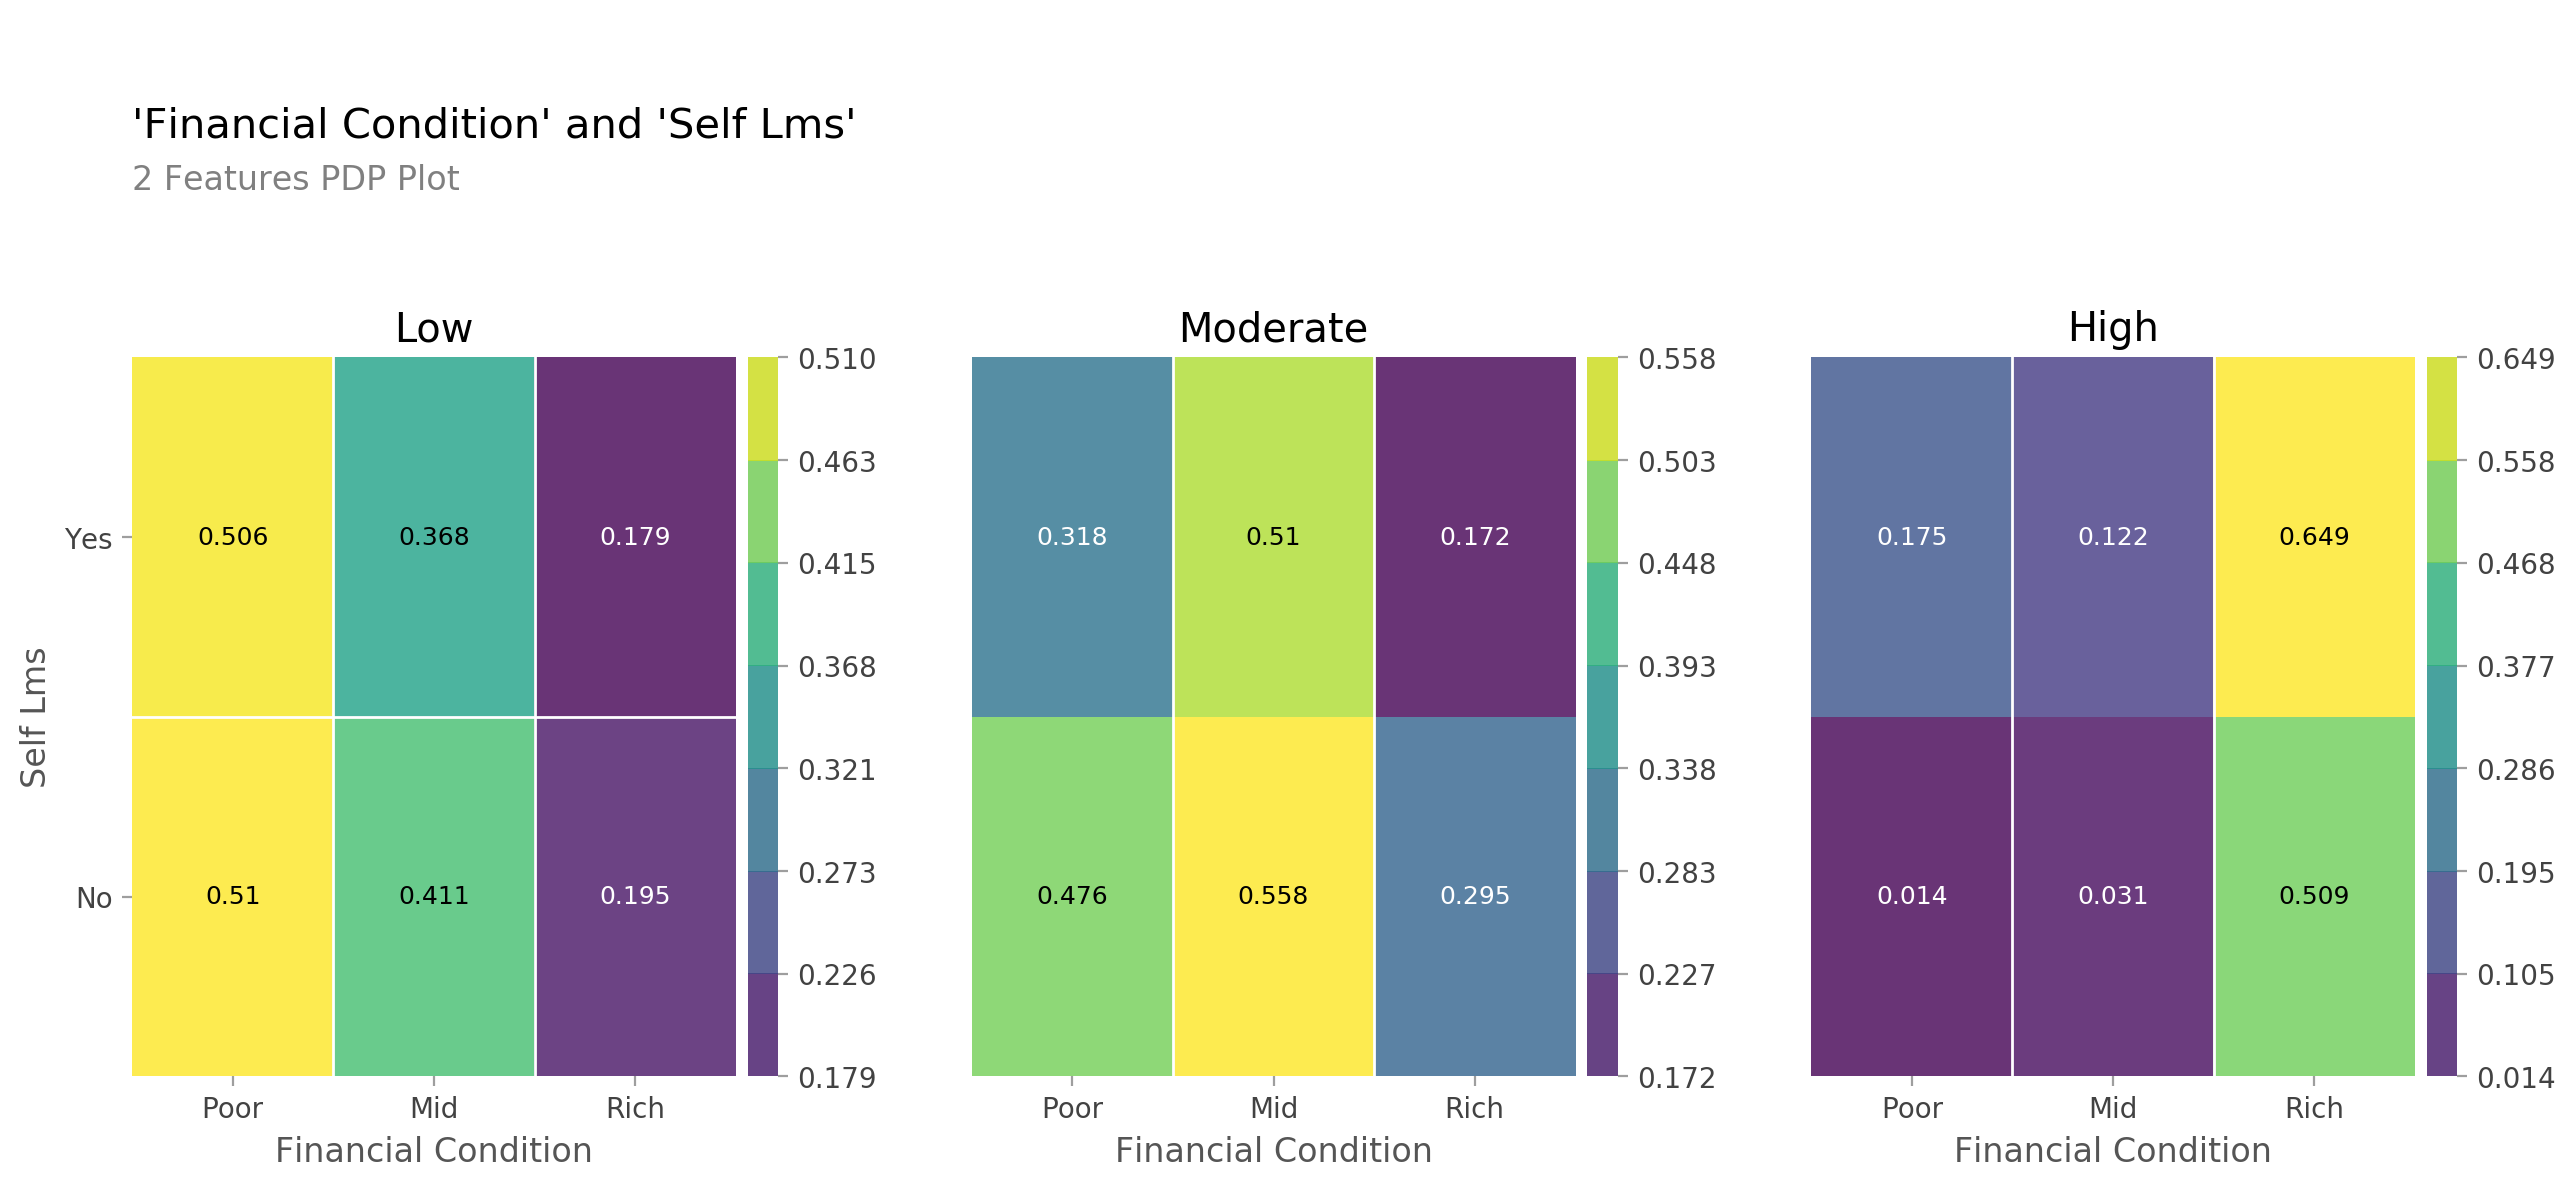

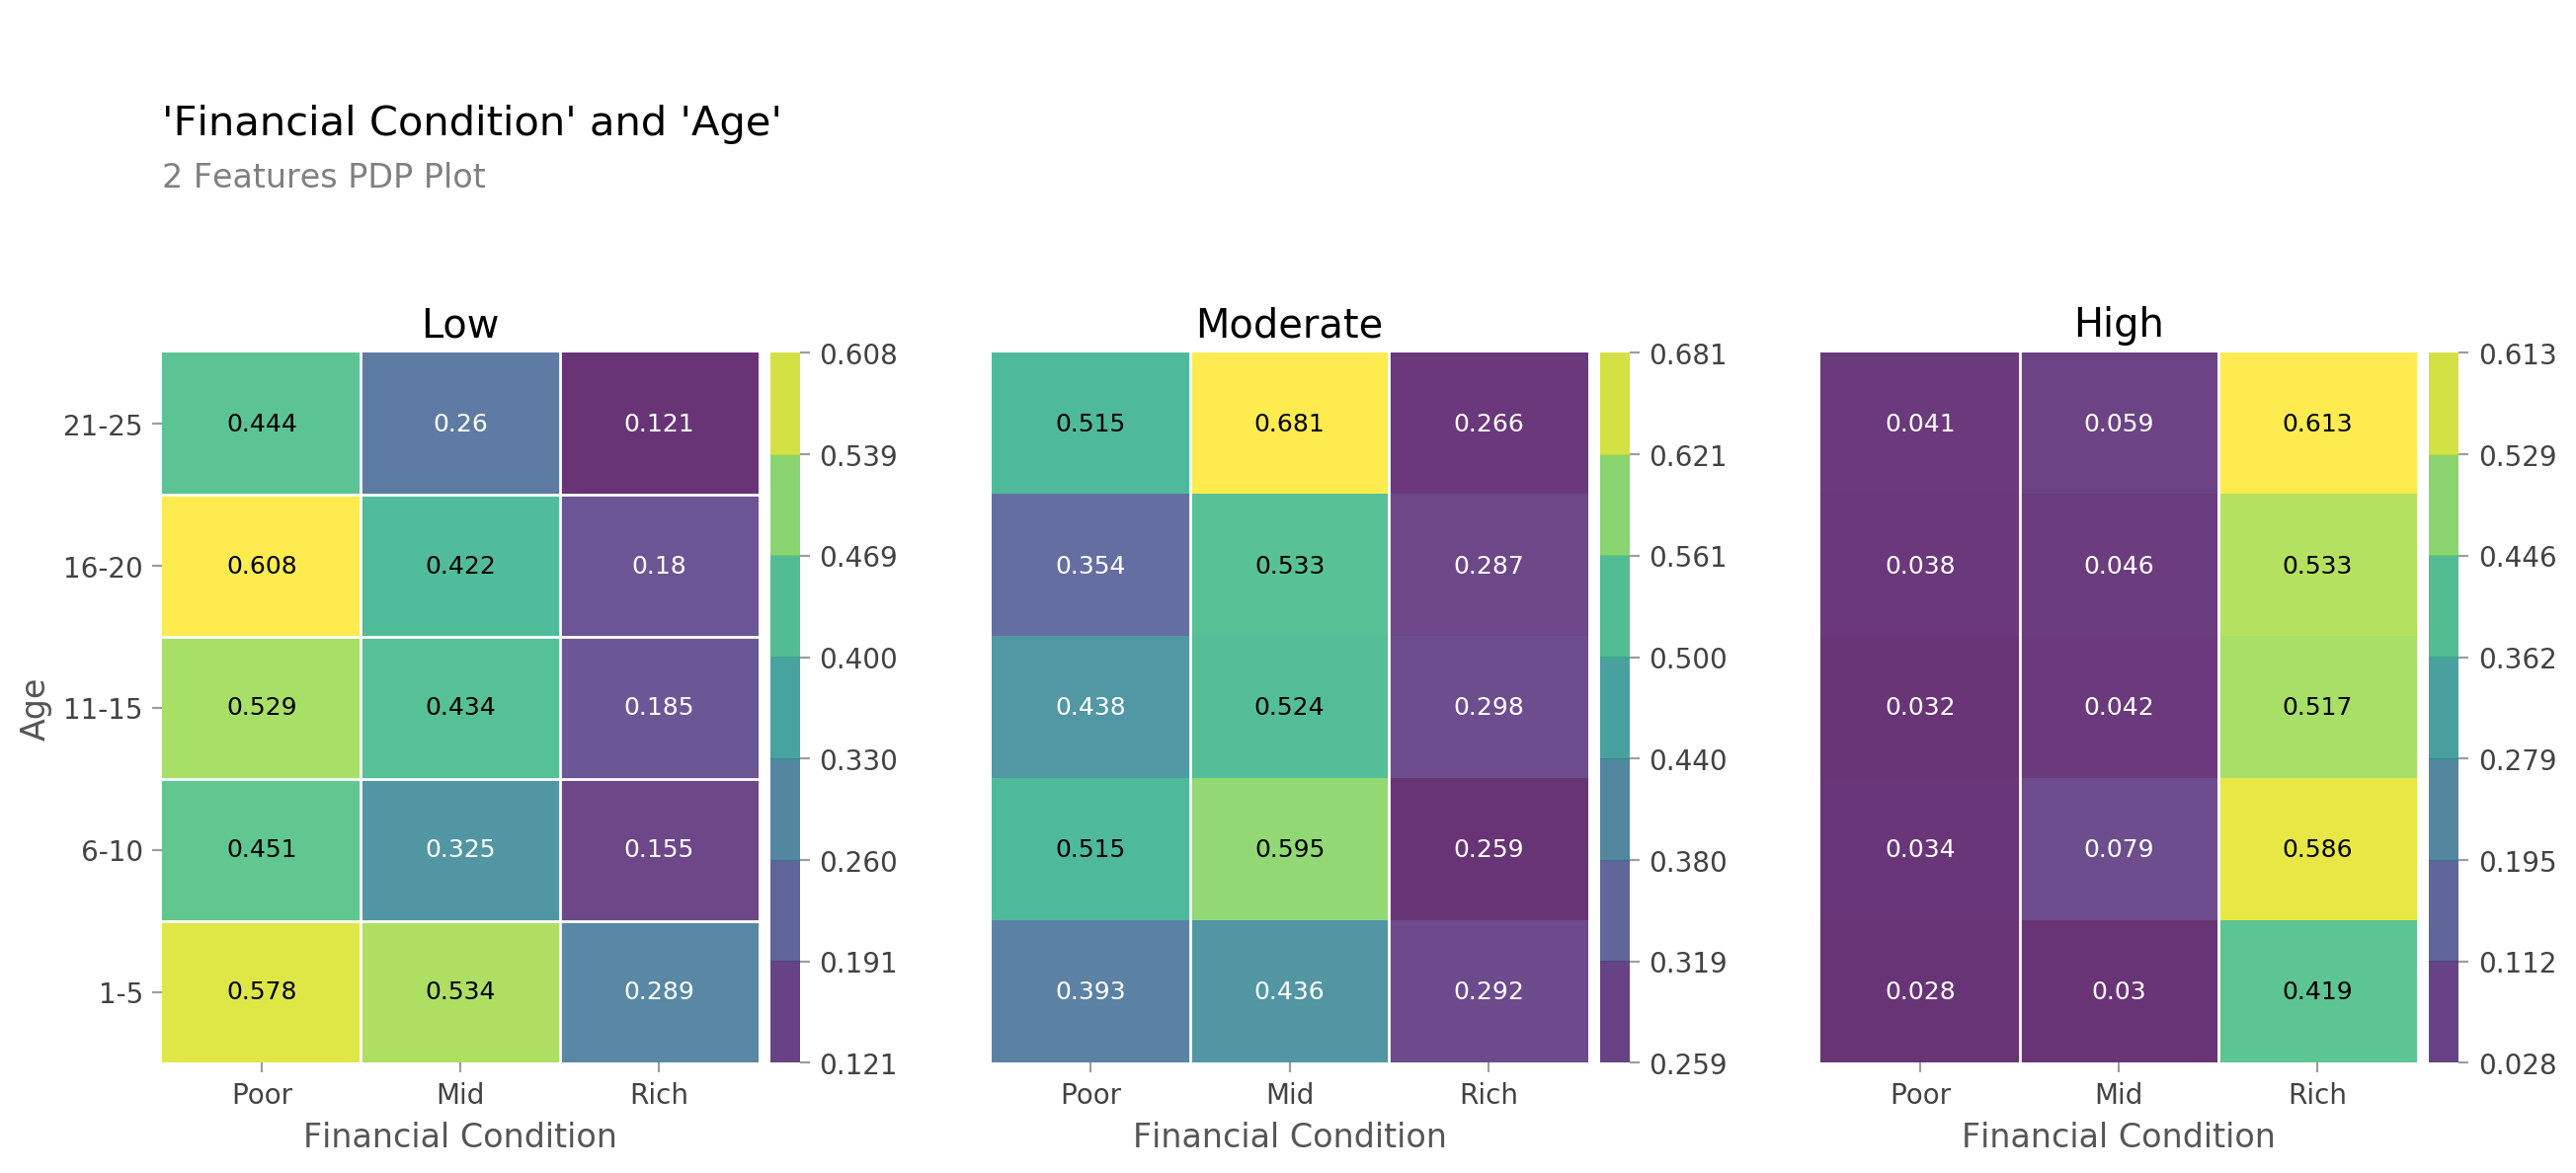

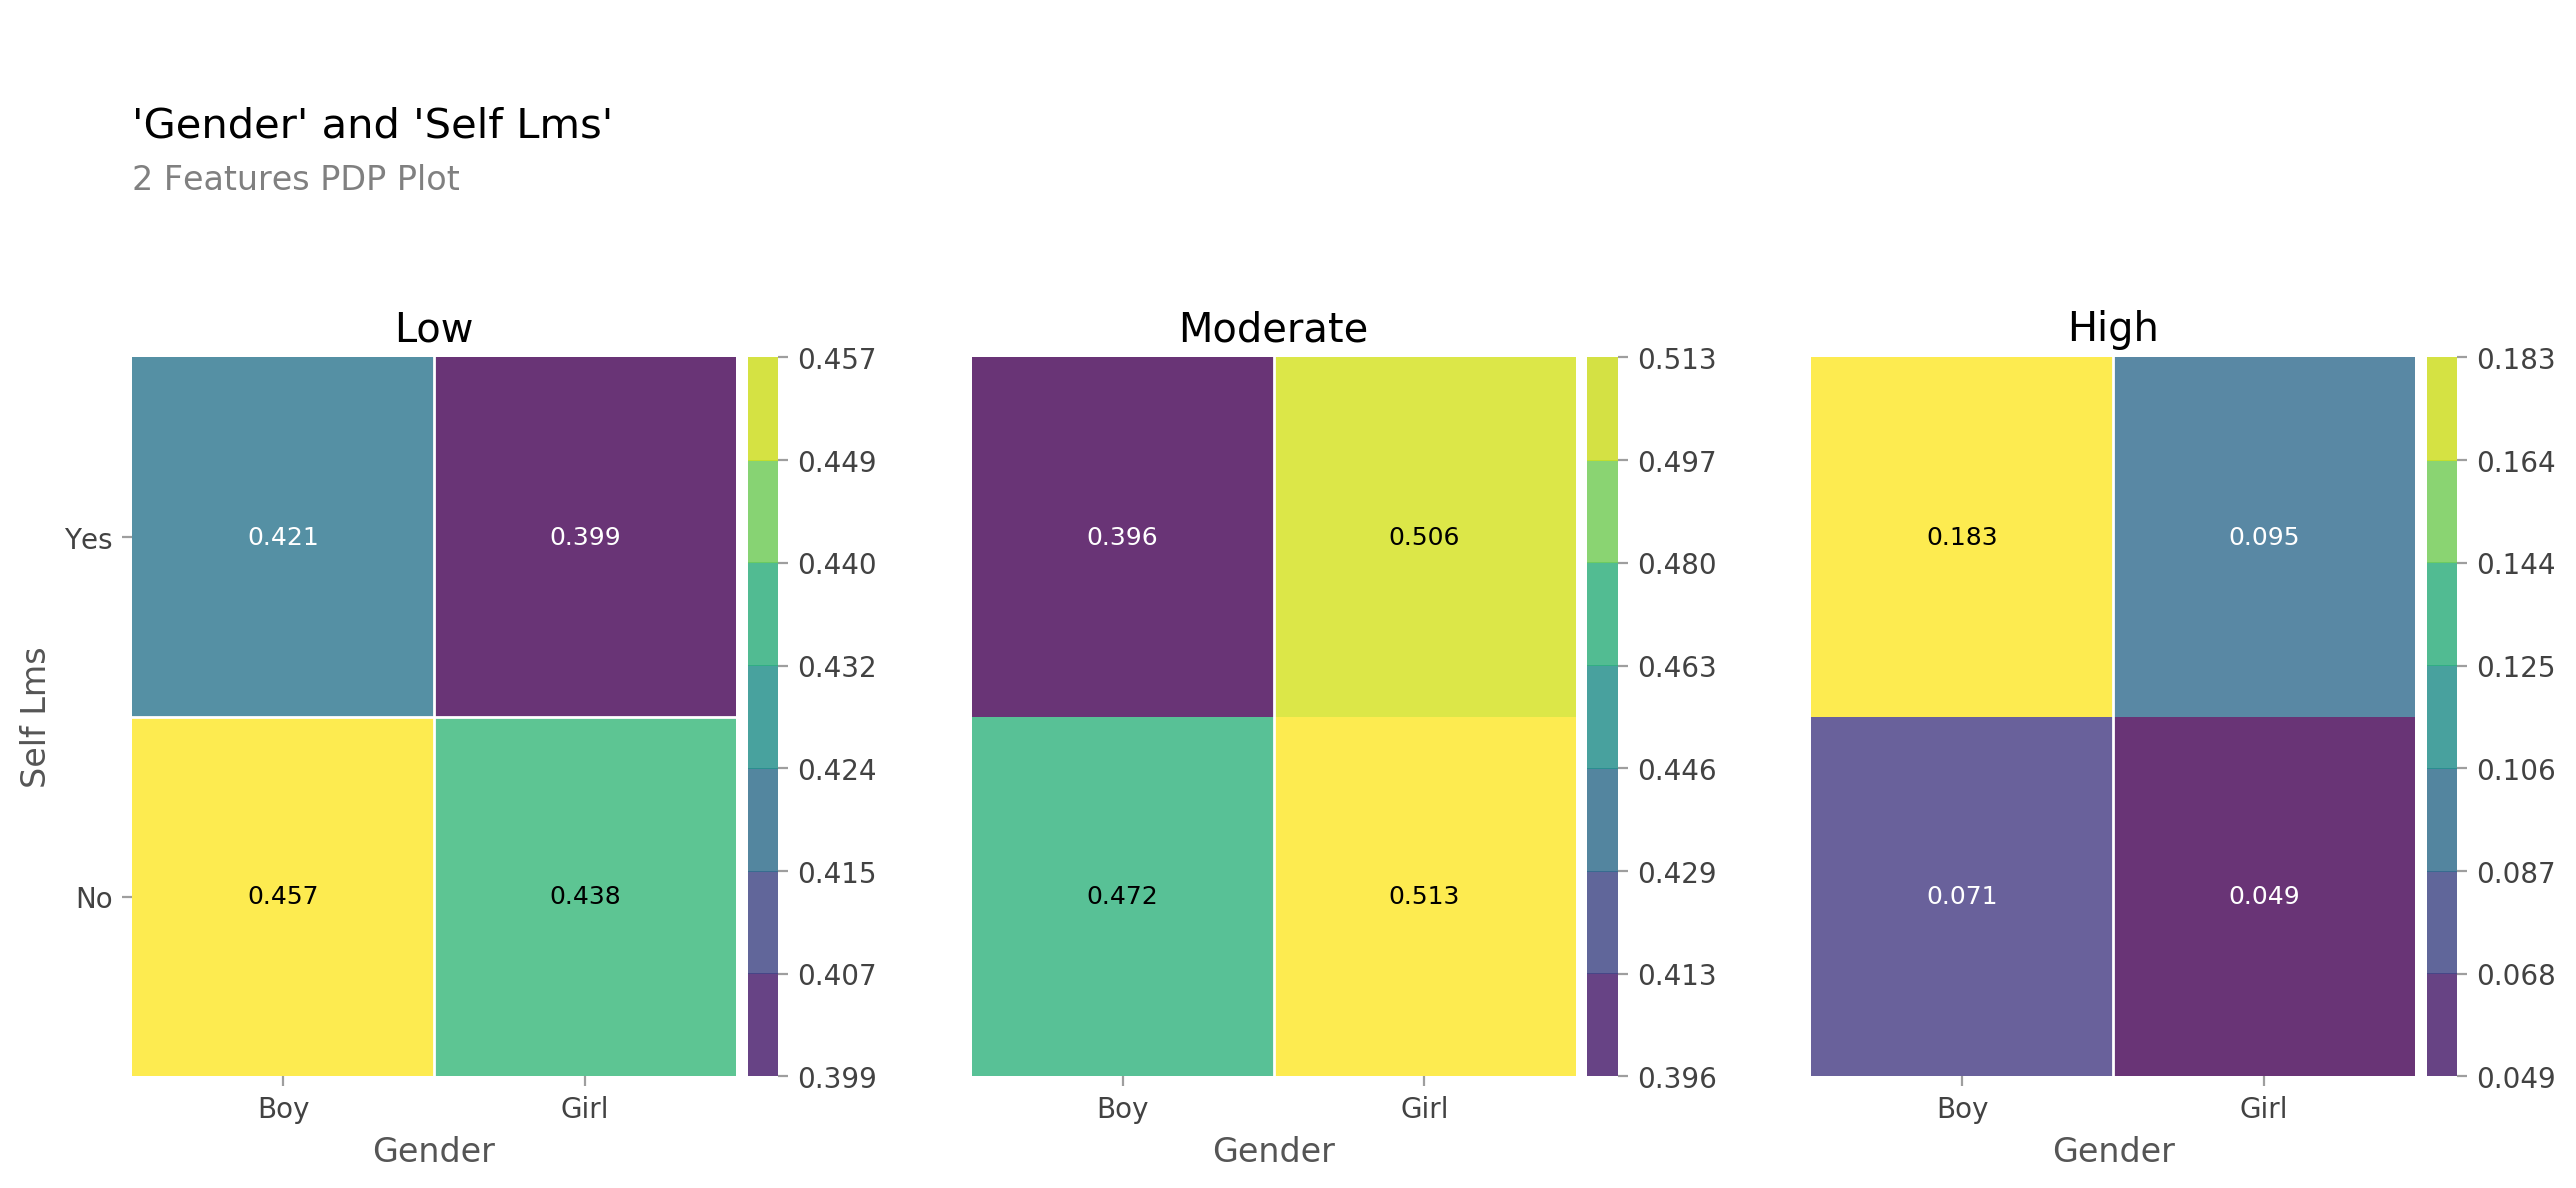

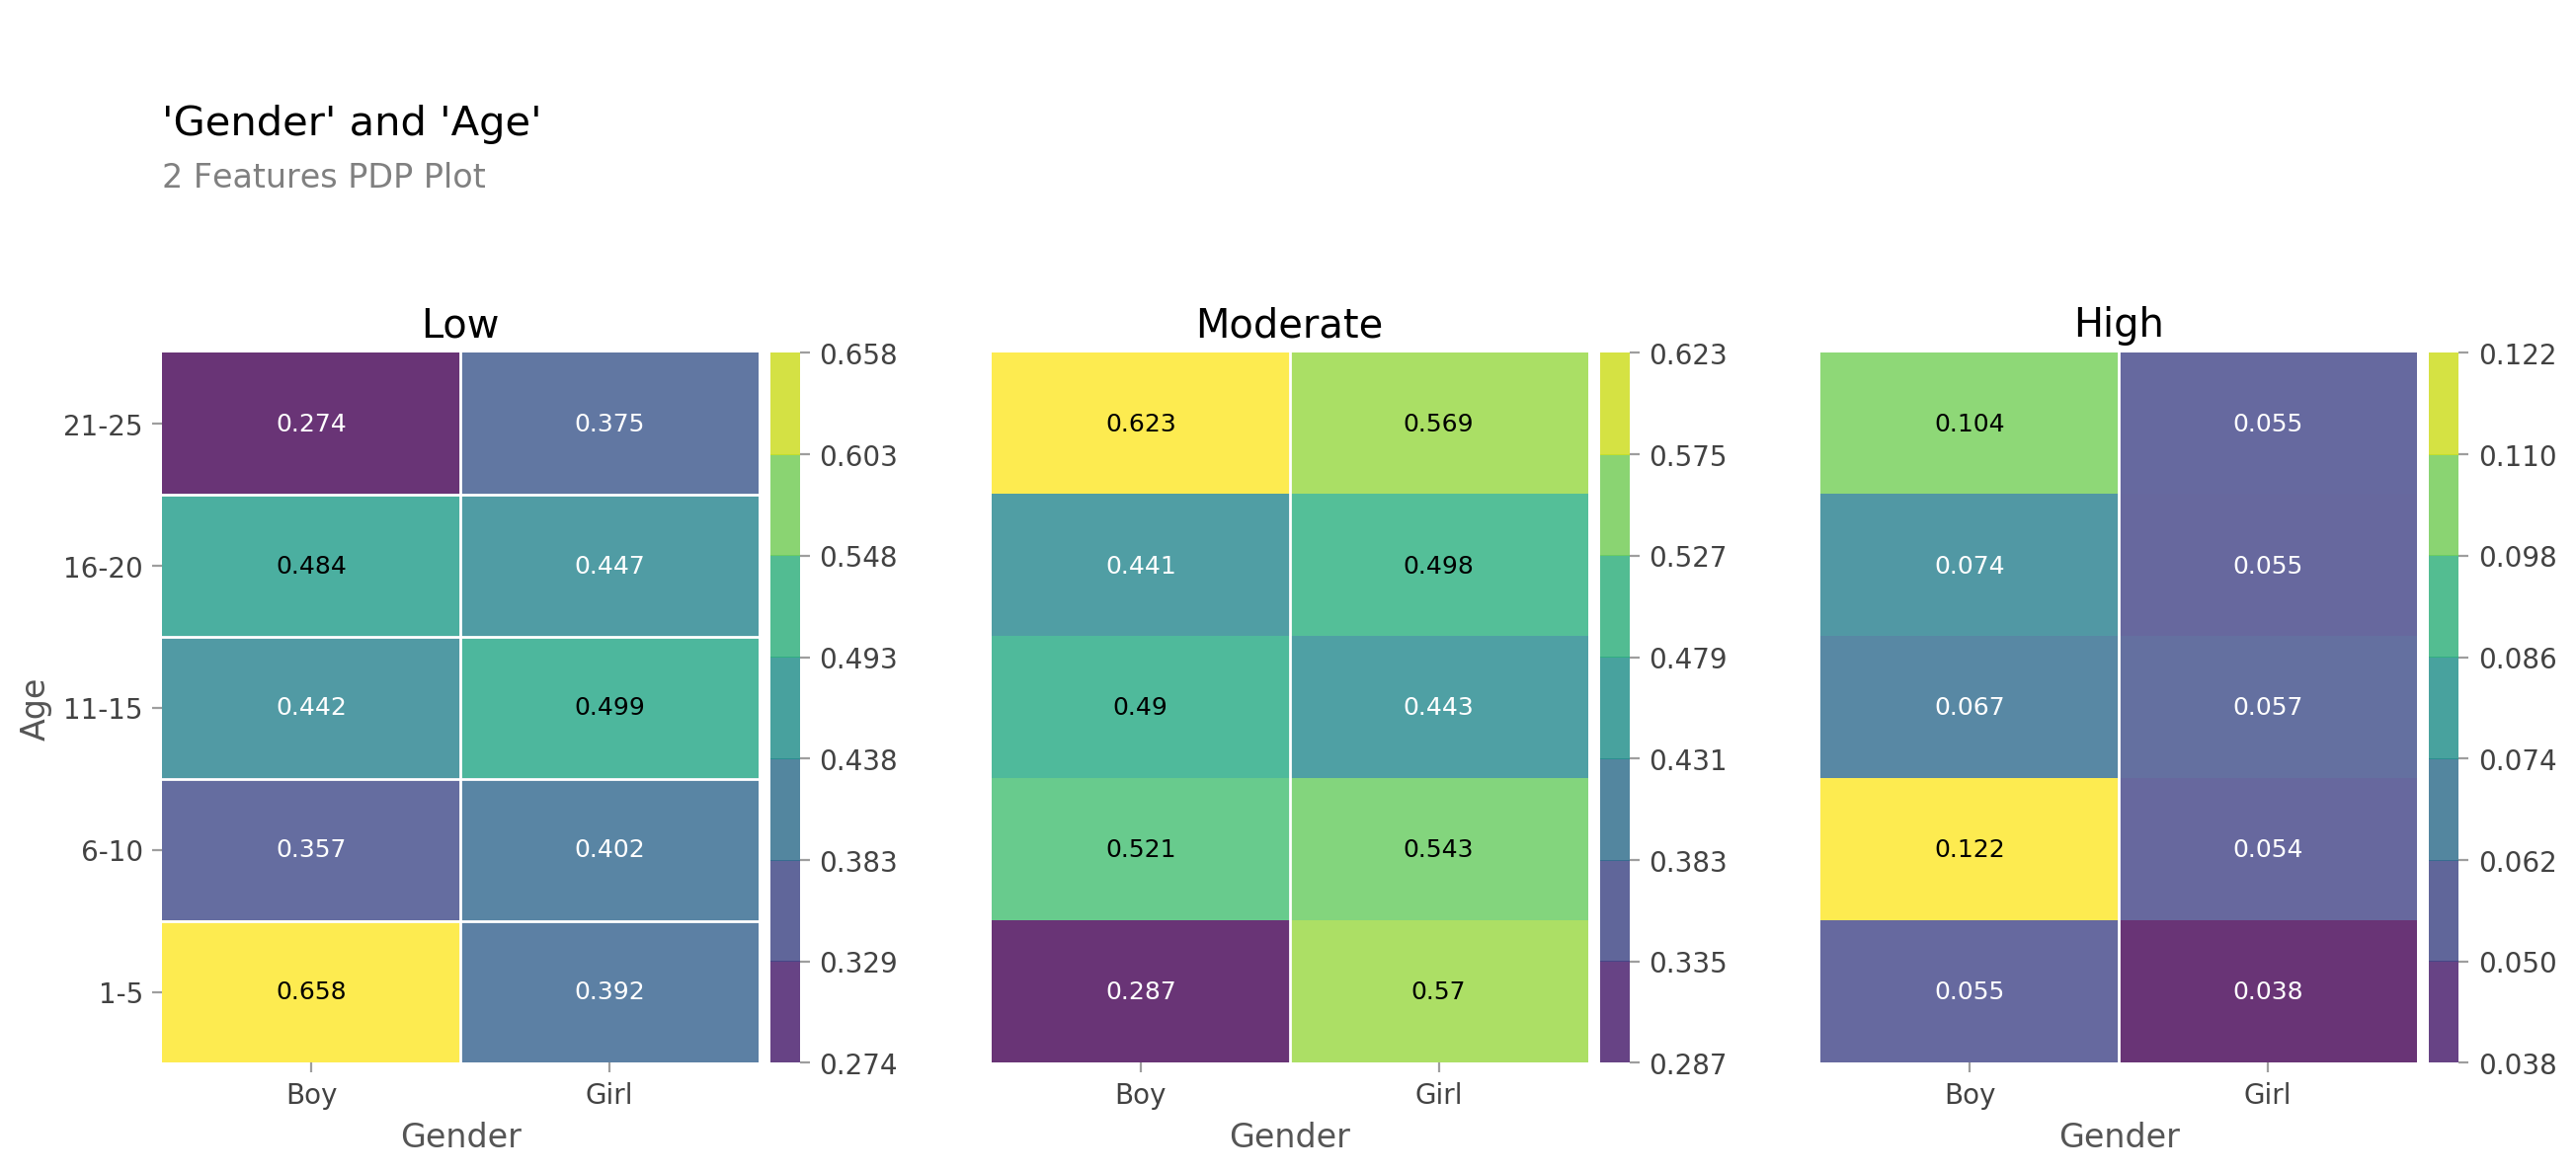

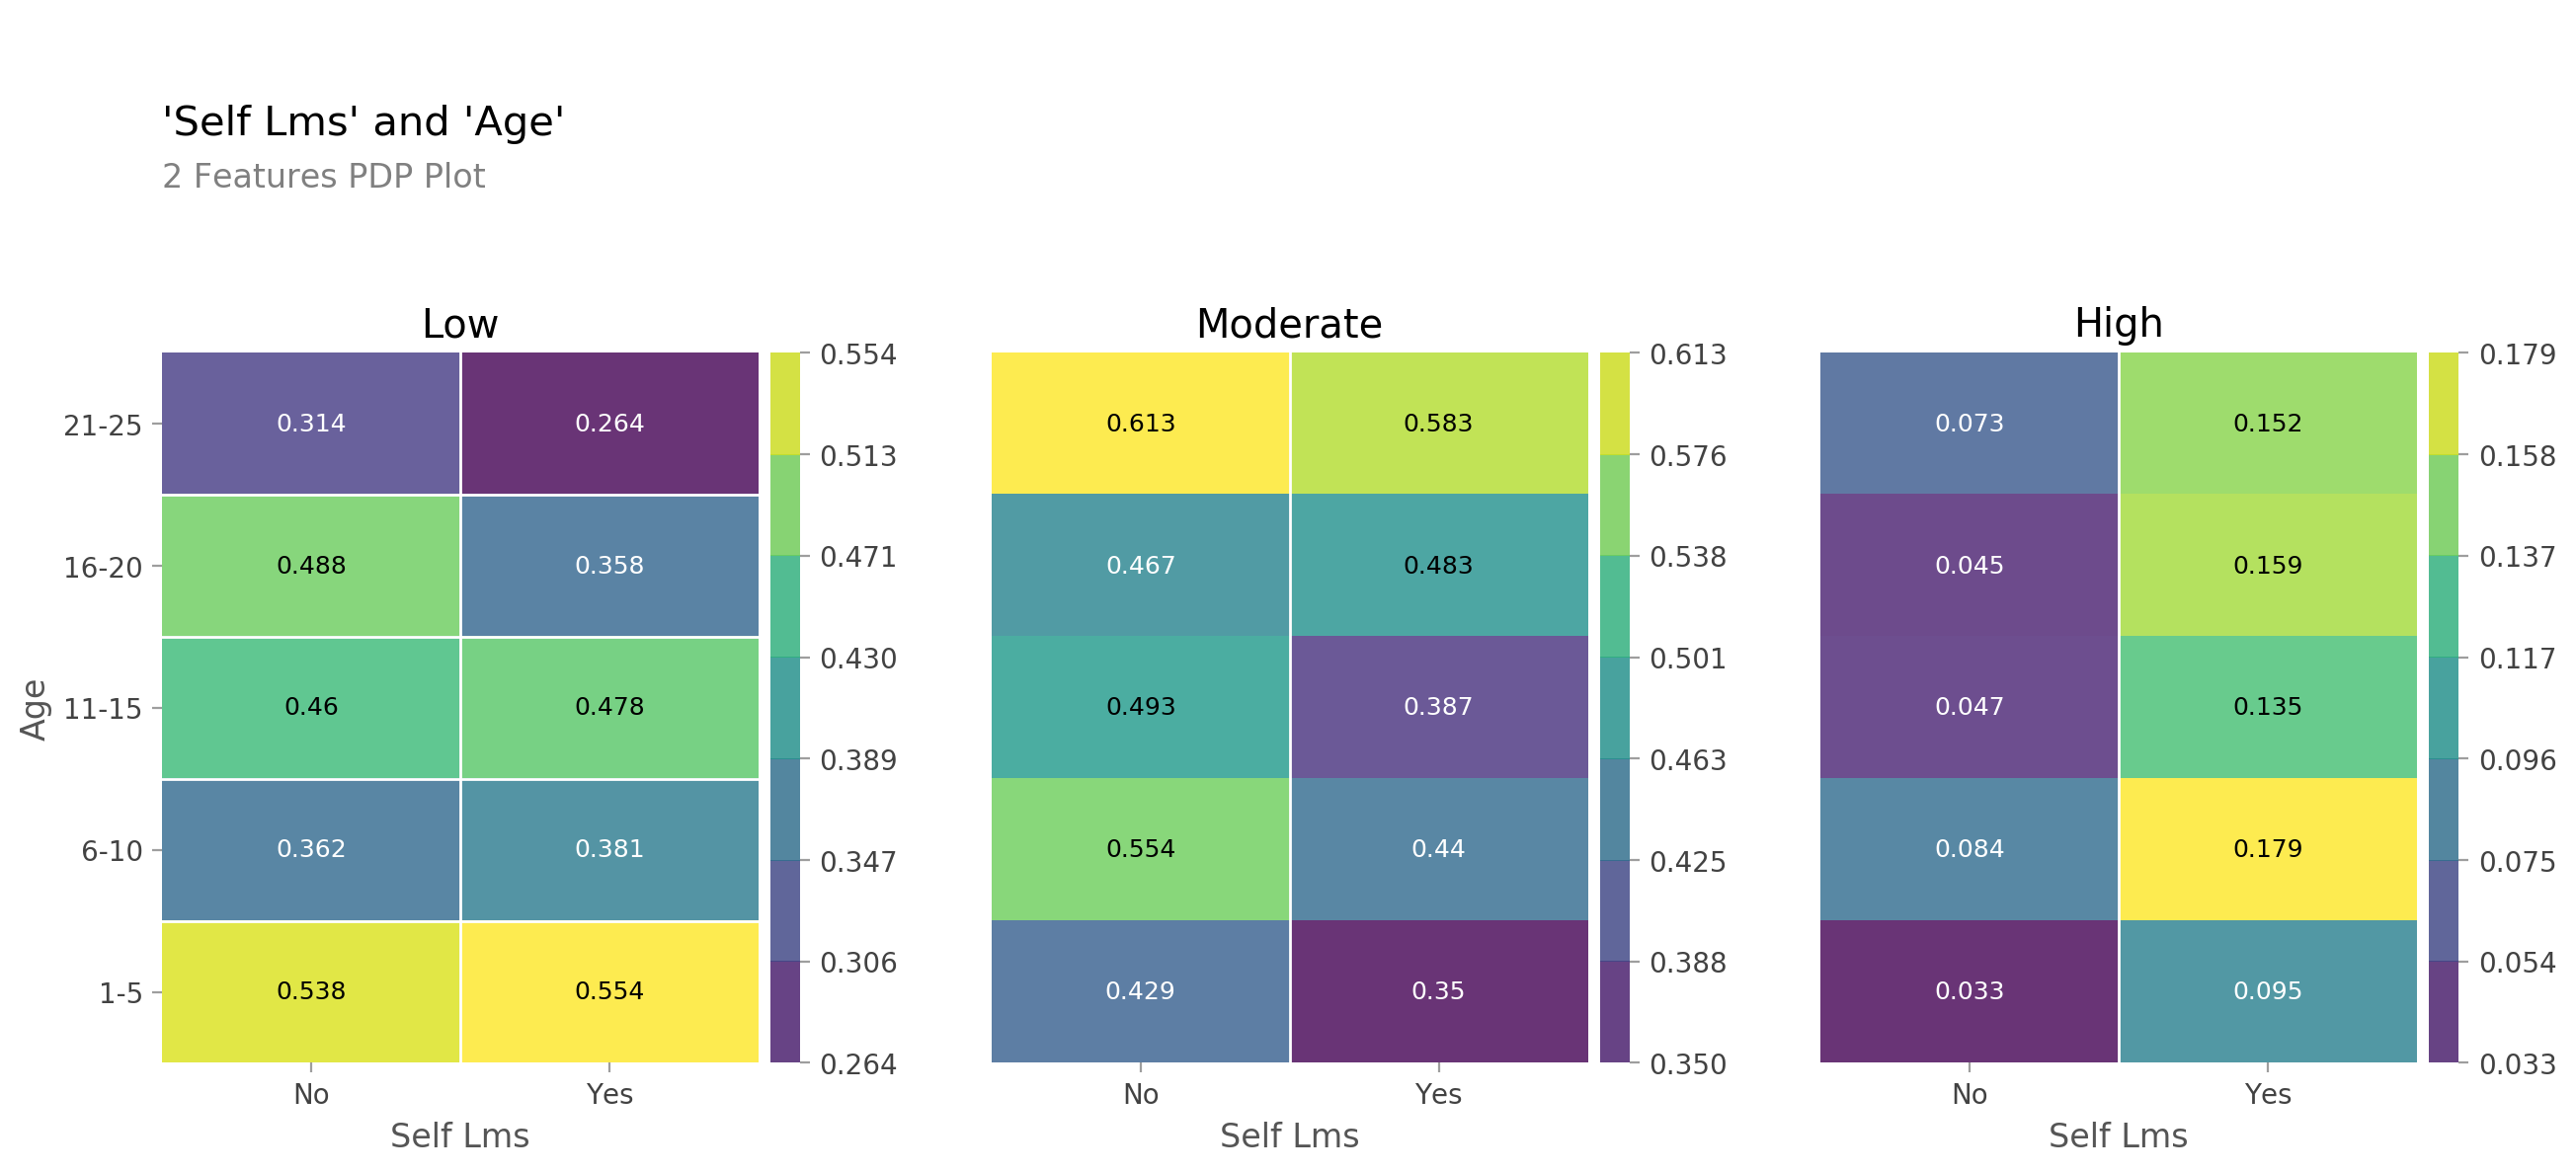

In [83]:
from itertools import combinations, permutations
comb = combinations(features, 2)
for f in comb:
    xticks = list(reverse_mapping[f[0]].keys())
    xlabels = list(reverse_mapping[f[0]].values())
    yticks = list(reverse_mapping[f[1]].keys())
    ylabels = list(reverse_mapping[f[1]].values())
    interact = pdp_interact(
        model = optimal_model,
        dataset=X_test, 
        model_features=X_test.columns, 
        features=f
    )
    fig, axes = pdp_interact_plot(
        pdp_interact_out=interact,
        feature_names=f,
        plot_type='grid',
        ncols=3,
        plot_params={
            "title":"'%s' and '%s'" %f,
            "subtitle":"2 Features PDP Plot",
        }
    )
    for class_idx, ax in enumerate(axes["pdp_inter_ax"]):
        ax.set_xticklabels(labels=xlabels)
        ax.set_xlabel(xlabel=f[0])
        ax.set_yticklabels(labels=ylabels)
        ax.set_title(target_mapping[class_idx])
        ax.grid(False)
        if class_idx > 0:
            ax.set_yticklabels(labels="")
            ax.axes.yaxis.set_visible(False)
    # plt.savefig("2_features_{}_{}_pdp.png".format(f[0], f[1]), dpi=300)

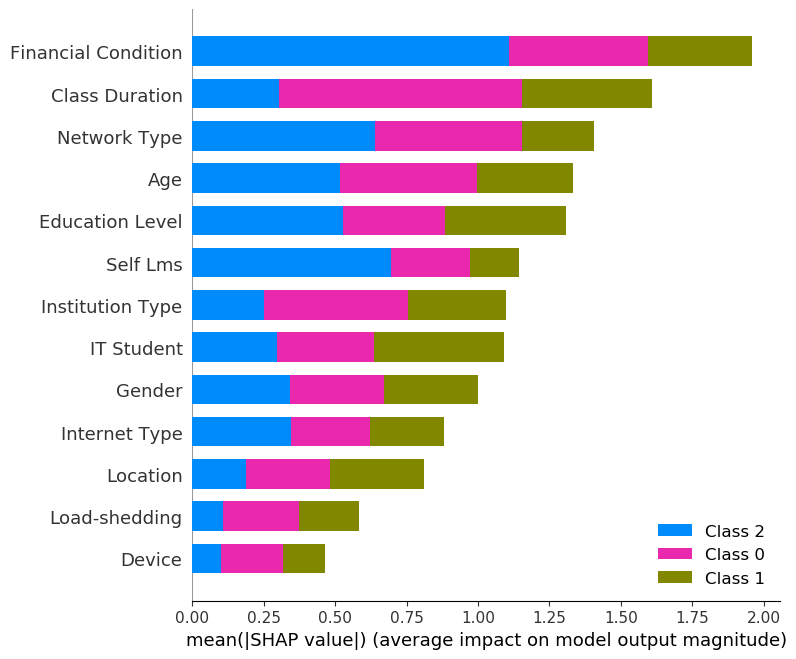

<Figure size 640x480 with 0 Axes>

In [94]:
explainer = shap.TreeExplainer(optimal_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(8,6.5))
shap.summary_plot(shap_values, X_test)
# plt.savefig("feature_importance_shap.png", dpi=300)

In [85]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0],
    features=X_test
)

In [86]:
plt.rcParams.update(plt.rcParamsDefault)

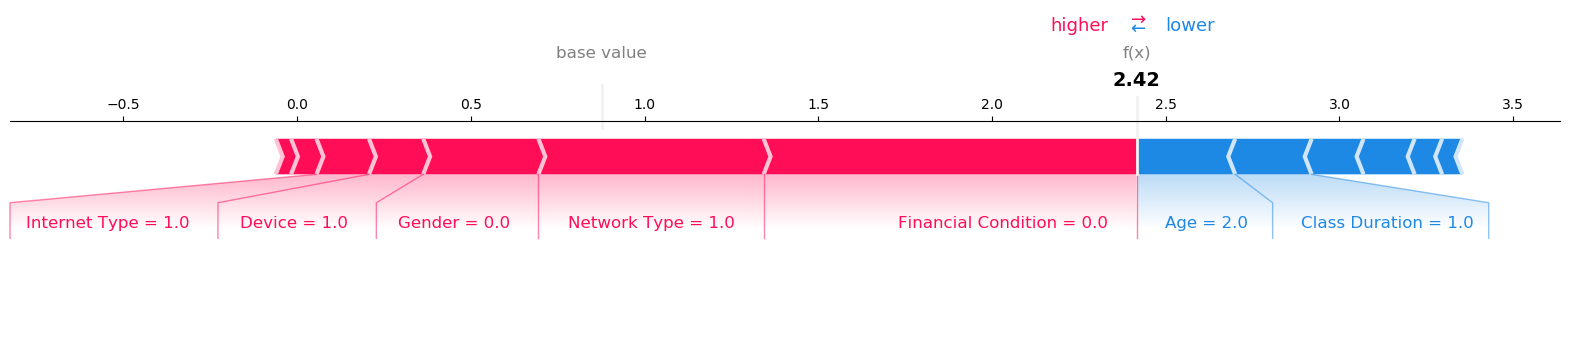

<Figure size 640x480 with 0 Axes>

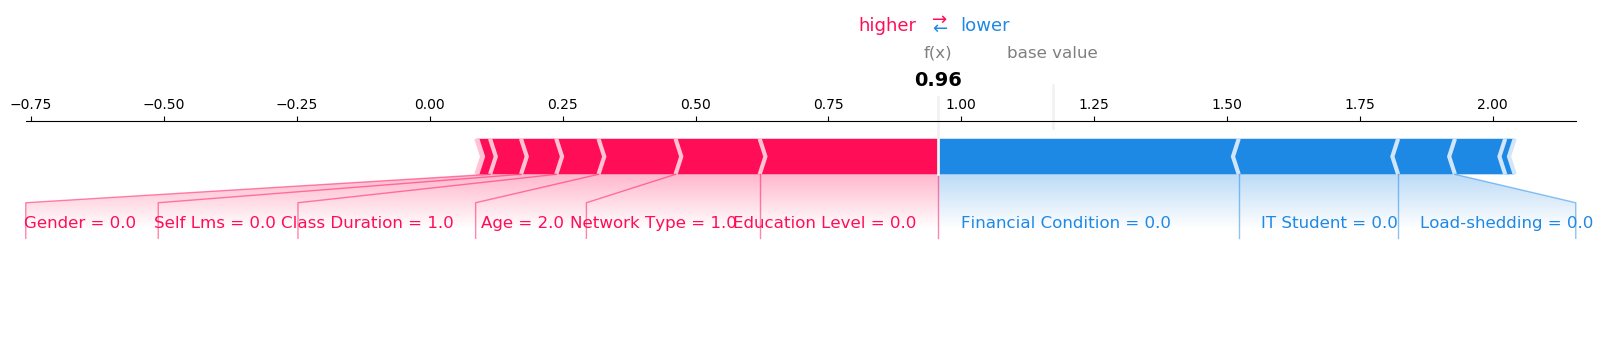

<Figure size 640x480 with 0 Axes>

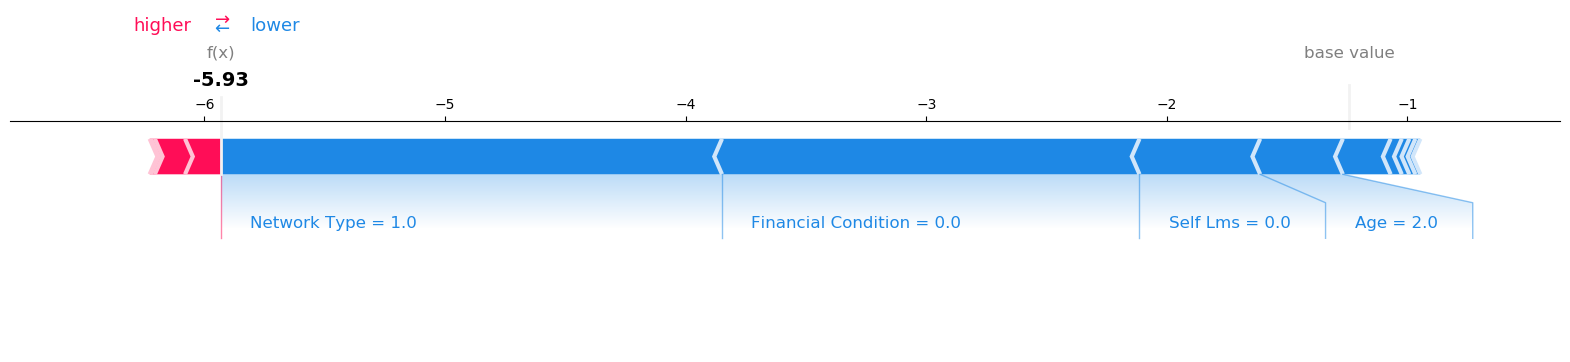

<Figure size 640x480 with 0 Axes>

In [89]:
sample1 = X_test.sample(random_state=2342)

shap_values_sample1 = explainer.shap_values(sample1)
for i in range(n_classes):
    shap.force_plot(
        base_value=explainer.expected_value[i], 
        shap_values=shap_values_sample1[i],
        features=sample1,
        matplotlib=True
    )
    # plt.savefig("shap_sample_try1_class{}.png".format(i), dpi=300)

In [90]:
s1 = sample1.iloc[0]
s1_idx = s1.index.tolist()
for idx, value in enumerate(s1):
    print(s1_idx[idx], ":", reverse_mapping[s1_idx[idx]][value])

Gender : Boy
Age : 11-15
Education Level : School
Institution Type : Non Government
IT Student : No
Location : Yes
Load-shedding : Low
Financial Condition : Poor
Internet Type : Mobile Data
Network Type : 3G
Class Duration : 1-3
Self Lms : No
Device : Mobile


In [96]:
optimal_model.predict(sample1)

array([0])

In [102]:
y_test.loc[sample1.index[0]]

0

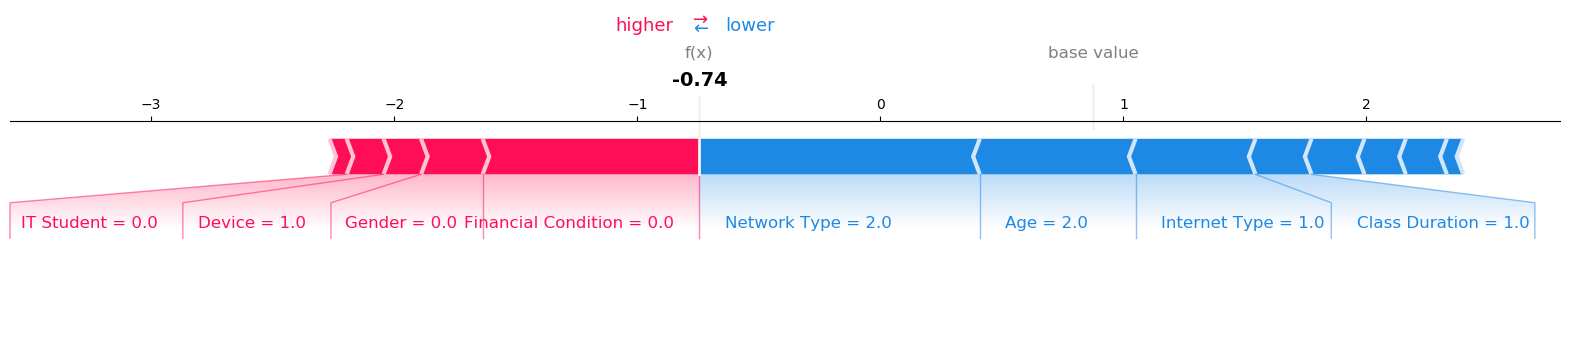

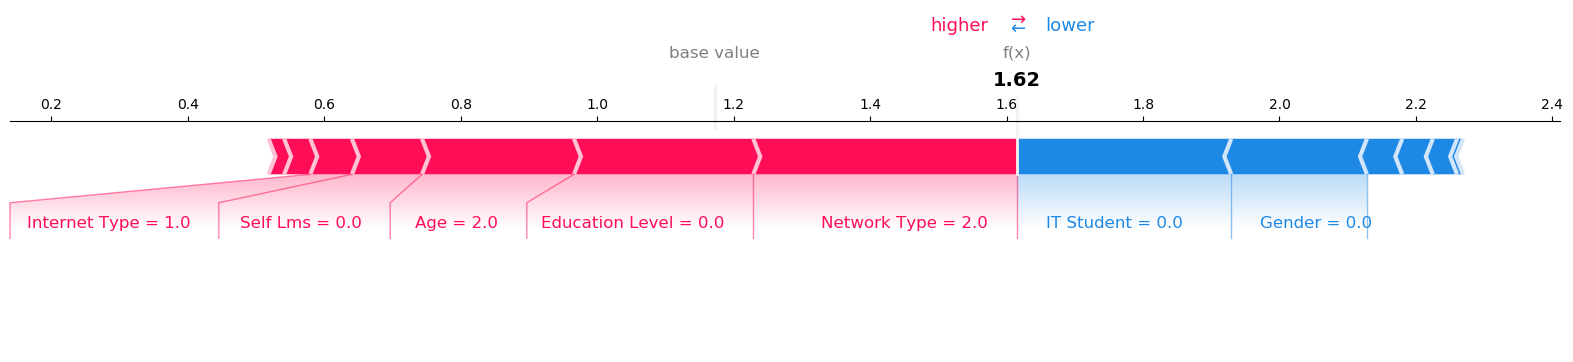

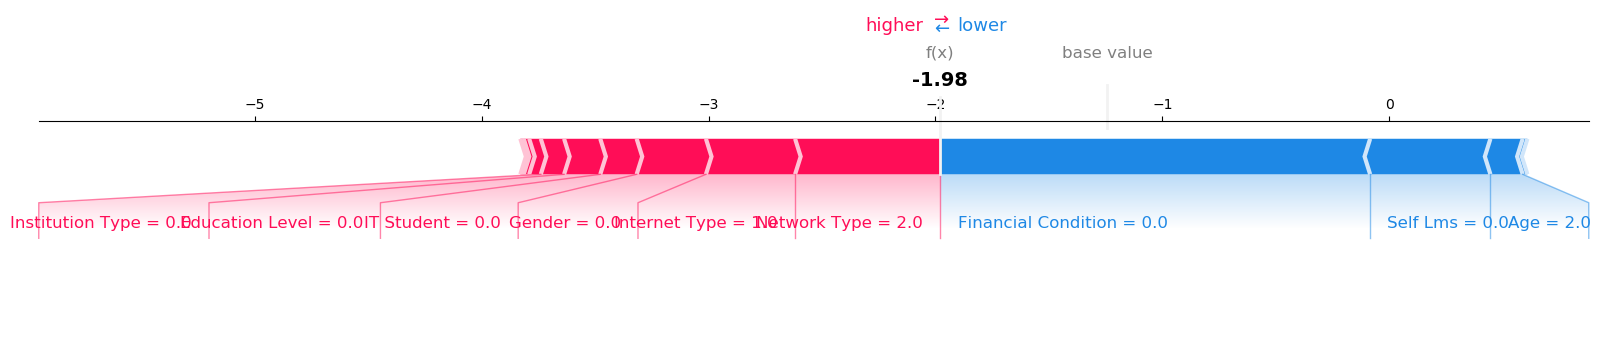

In [97]:
sample2 = sample1.copy()
sample2["Network Type"] = 2
shap_values_sample1 = explainer.shap_values(sample2)
for i in range(n_classes):
    shap.force_plot(
        base_value=explainer.expected_value[i], 
        shap_values=shap_values_sample1[i],
        features=sample2,
        matplotlib=True
    )

In [103]:
optimal_model.predict(sample2)

array([1])

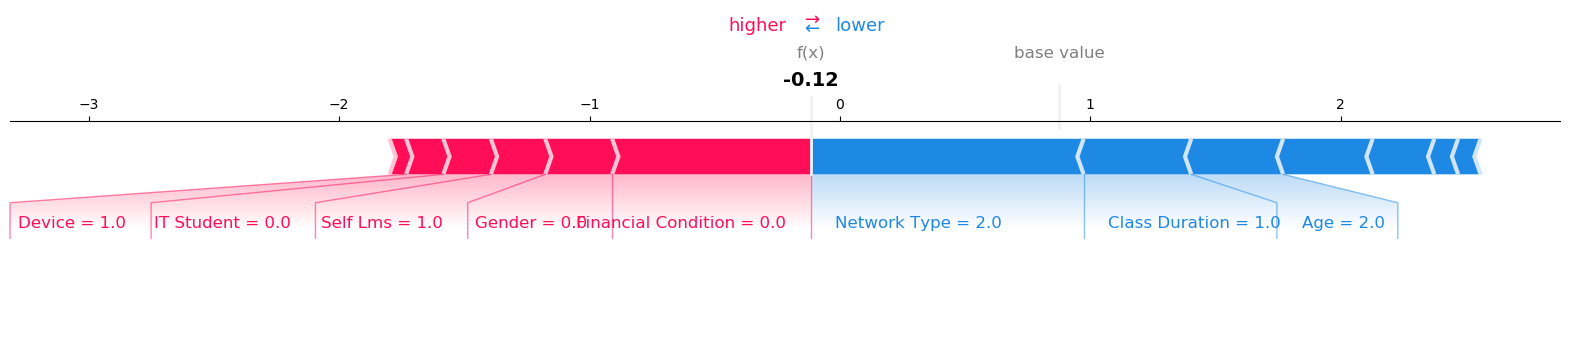

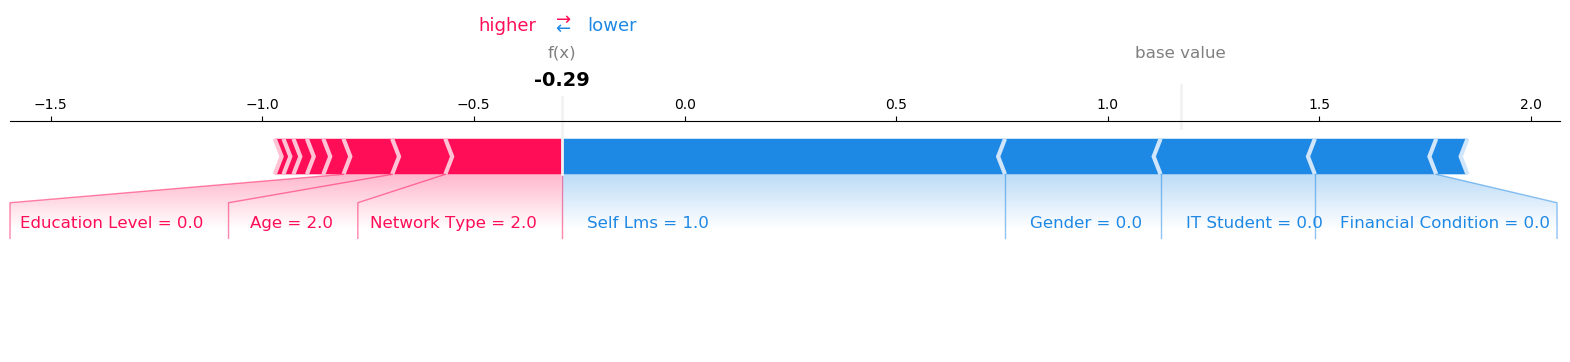

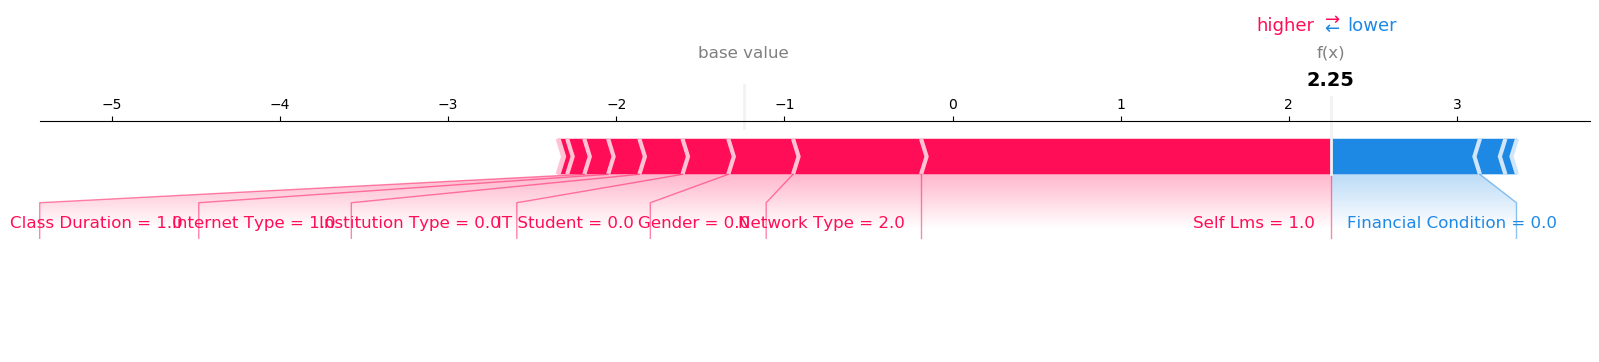

In [104]:
sample2["Self Lms"] = 1
shap_values_sample1 = explainer.shap_values(sample2)
for i in range(n_classes):
    shap.force_plot(
        base_value=explainer.expected_value[i], 
        shap_values=shap_values_sample1[i],
        features=sample2,
        matplotlib=True
    )

In [105]:
optimal_model.predict(sample2)

array([2])

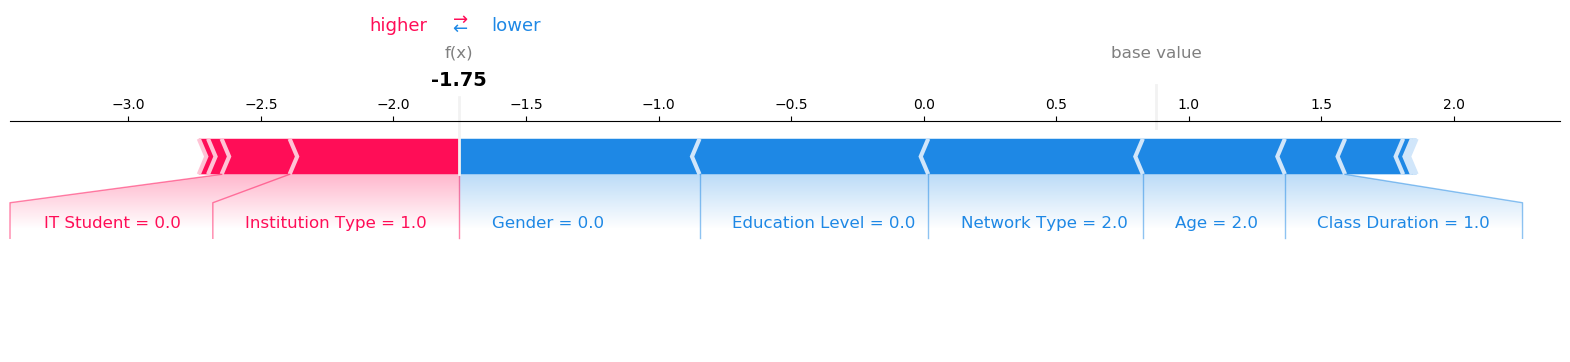

<Figure size 640x480 with 0 Axes>

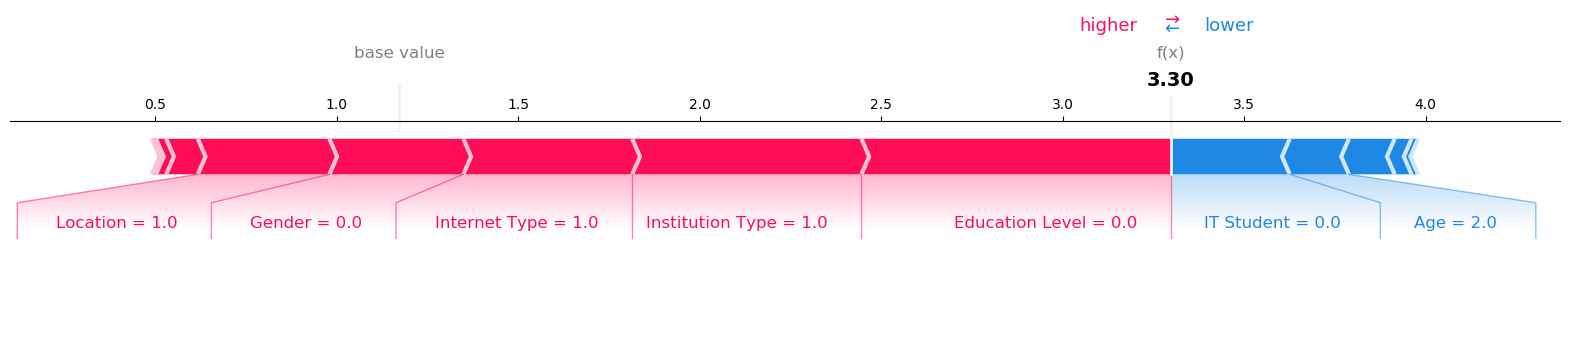

<Figure size 640x480 with 0 Axes>

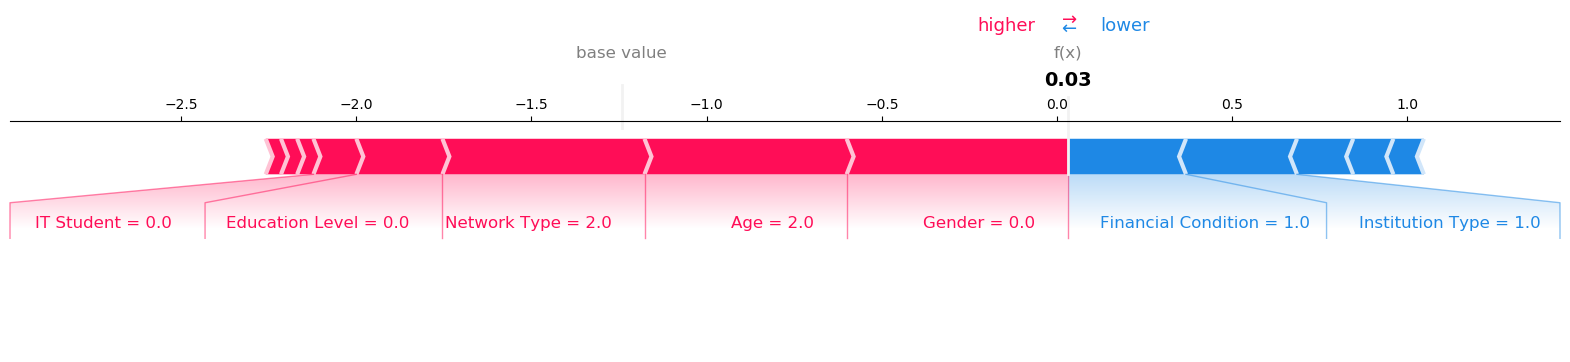

<Figure size 640x480 with 0 Axes>

In [93]:
sample2["Self Lms"] = 0
sample2["Institution Type"] = 1
sample2["Financial Condition"] = 1
shap_values_sample1 = explainer.shap_values(sample2)
for i in range(n_classes):
    shap.force_plot(
        base_value=explainer.expected_value[i], 
        shap_values=shap_values_sample1[i],
        features=sample2,
        matplotlib=True
    )
    # plt.savefig("shap_sample_try4_class{}.png".format(i), dpi=300)